<a href="https://colab.research.google.com/github/akshaya-nagarajan/MachineLearning/blob/master/MLFinals_AlternusVeraNodeRank_Akshaya.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Course code : CMPE-257
## Name: Akshaya Nagarajan - 014535014


---


## Process Followed:

### Data Collection and feature engineering
1.   Load Liar-Liar dataset and Kaggle News Category
2.   Scrape the Website from Google search to identify where the News was published for Liar Liar Dataset.
3.   Calculate Page Rank, number of Nodes, number of edges for Liar-Liar and Kaggle News category Dataset using NetworkX.
4.   Construct Graph structure to visualize the above collected data.
---

### Multiclass Classification
1.   Apply XGBoost, RandomForest, Decision Tree, MultinomialNB on Liar-Liar.
2. Note the classification report(accuracy, f1-score, precision, recall)
3. Plot Confusion Matrix
4. Plot ROC Curve
---

### Amalgamation
1.   Amalgamate Liar-Liar and Kaggle News Category
2.   Apply 4 classification models, note the classification report(accuracy, f1-score, precision, recall)
3. Feature Importance based on Decision Tree Gini Index, Random Forest Classifier and XGBoost are plotted.
4. Plot Confusion Matrix
5. Plot ROC Curve
---

### Distillation
1. Perform LDA, Ranking and Sentiment Score
2. Apply 4 classification models, note the classification report(accuracy, f1-score, precision, recall)
3. Feature Importance based on Decision Tree Gini Index, Random Forest Classifier and XGBoost are plotted.
4. Plot Confusion Matrix
5. Plot ROC Curve
---

### Compare the results - Before Amalgamation, After Amalgamation, After Distillation

---

### Working with Imbalanced Dataset

----

### BERT Classifier

---

## Mounting Drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/MLSpring2020/"
base_dir = root_dir + 'the_expendables_AirQuality_Traffic'
myDrive = "/content/gdrive/My Drive/"

Mounted at /content/gdrive


## Importing Libraries

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, accuracy_score, mean_squared_error, f1_score
from sklearn import metrics

from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.naive_bayes import MultinomialNB

from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import roc_curve, auc
from xgboost import plot_importance
from dateutil.parser import parse 
from sklearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier 
plt.rcParams.update({'figure.figsize': (10, 7), 'figure.dpi': 120})

from textblob import TextBlob

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Loading Liar Liar Dataset

In [0]:
liarFilepath = base_dir + '/Alternus_vera/liar_dataset/Liardataset.csv'

In [0]:
df_liar = pd.read_csv(liarFilepath, encoding= 'unicode_escape')

In [5]:
print('Liar-Liar - Fake and Truth Combined', df_liar.shape)

Liar-Liar - Fake and Truth Combined (12791, 14)


## Drop off unwanted columns

In [0]:
df_liar = df_liar.drop(columns=['json', 'subject', 'speaker_job_title', 'state_info', 'party_affiliation', 'barely_true_counts', 'false_counts', 'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts', 'context'])

In [7]:
df_liar.head(1)

class                                          statement       speaker
0  FALSE  Says the Annies List political group supports ...  dwayne-bohac

## Code for getting the news source of the article as Politifact.com returns a node rank of 1.0 all the time. Therefore getting the direct source of the news article by scaping the URLs from Google search.

In [0]:
import urllib.request as urllib2
from lxml import html
import requests

def get_page_tree(url):
    page = requests.get(url=url, verify=False)
    return html.fromstring(page.text)

def get_title(url):
    tree = get_page_tree(url)
    return tree.xpath('//title//text()')[0].strip().split(' -')[0]

def find_other_news_sources(url,title):
    forwarding_identifier = '/url?q='
    if not title:
        title = get_title(url=url)
    google_news_search_url = 'http://www.google.com/search?q=' + urllib2.quote(title) + '&tbm=nws' + url
    google_news_search_tree = get_page_tree(url=google_news_search_url)
    other_news_sources_links = [a_link.replace(forwarding_identifier, '').split('&')[0] for a_link in google_news_search_tree.xpath('//a//@href') if forwarding_identifier in a_link]
    return other_news_sources_links

In [9]:
# df_liar['link'] = df_liar.head(1).apply(lambda x: find_other_news_sources("www.politifact.com", x['statement']), axis=1)
link = df_liar.head(1).apply(lambda x: find_other_news_sources("www.politifact.com", x['statement']), axis=1)
print(link[0])

['https://www.politifact.com/factchecks/2010/oct/20/dwayne-bohac/texas-rep-dwayne-bohac-says-annies-list-supports-t/', 'https://www.politifact.com/factchecks/list/%3Fspeaker%3Ddwayne-bohac', 'https://www.pbs.org/newshour/politics/where-2020-democrats-stand-on-abortion', 'https://www.nytimes.com/2019/11/25/us/politics/abortion-laws-2020-democrats.html', 'https://www.cbsnews.com/news/late-term-abortions-two-bills-banning-blocked-senate-democrats/', 'https://www.washingtonpost.com/politics/amid-a-shifting-legal-landscape-on-abortion-both-parties-seek-political-advantage/2019/02/11/8e289cb4-2be1-11e9-b011-d8500644dc98_story.html', 'https://www.theatlantic.com/politics/archive/2019/06/2020-democrats-abortion/590701/', 'https://www.usnews.com/elections/abortion-2020', 'https://en.wikipedia.org/wiki/Abortion_law', 'https://www.npr.org/2019/04/30/718546468/opponents-fight-efforts-to-protect-late-term-abortion-rights', 'https://accounts.google.com/ServiceLogin%3Fcontinue%3Dhttp://www.google.com

In [0]:
# for key, value in df_liar.iterrows():
#   if key >= 2433 and key <= 2434:    
#     value.link = find_other_news_sources("www.politifact.com", value.statement)
#     df_liar['link'][key] = value.link

In [0]:
# df_liar['link'][2433]

## Saving the Sources of 3000 scraped news articles URLs in CSV file.

In [0]:
# with open(base_dir + '/Alternus_vera/liarwithsource.csv', 'a') as f:
#   df_liar.to_csv(f)

In [0]:
liarWithSourceFilepath = base_dir + '/Alternus_vera/liarwithsource.csv'

In [0]:
df = pd.read_csv(liarWithSourceFilepath, encoding= 'unicode_escape')

In [15]:
df.shape

(3002, 6)

In [16]:
df.head(1)

Unnamed: 0  ...                                               link
0           0  ...  ['https://www.politifact.com/factchecks/2010/o...

[1 rows x 6 columns]

## Dropping off unwanted columns

In [0]:
df = df.drop(columns=['Unnamed: 0', 'fakeness'])

In [18]:
df.head(10)

class  ...                                               link
0        FALSE  ...  ['https://www.politifact.com/factchecks/2010/o...
1    half-true  ...  ['https://www.politifact.com/factchecks/2015/f...
2  mostly-true  ...  ['https://www.politifact.com/factchecks/2008/f...
3        FALSE  ...  ['https://www.politifact.com/truth-o-meter/sta...
4    half-true  ...  ['https://www.politifact.com/factchecks/2014/m...
5         TRUE  ...  ['https://www.politifact.com/factchecks/2016/j...
6  barely-true  ...  ['https://www.politifact.com/factchecks/2010/s...
7    half-true  ...  ['https://www.politifact.com/factchecks/2007/o...
8    half-true  ...  ['https://www.politifact.com/factchecks/2012/m...
9  mostly-true  ...  ['https://www.politifact.com/factchecks/2014/a...

[10 rows x 4 columns]

## Cleaning the links from google search which has quotes and brackets.

In [0]:
def processLinks(link):
  allUrls = link.split(",")
  sourceList = []
  for i in range(len(allUrls)):
    sourceList.append(allUrls[i].replace('\'', '').replace('[', '').replace('\'', '').replace(' ', ''))
  return sourceList

In [0]:
df['source'] = df.apply(lambda x: processLinks(x['link']), axis=1)

## Cleaned links are stored in the source column

In [21]:
df['source']

0       [https://www.politifact.com/factchecks/2010/oc...
1       [https://www.politifact.com/factchecks/2015/fe...
2       [https://www.politifact.com/factchecks/2008/fe...
3       [https://www.politifact.com/truth-o-meter/stat...
4       [https://www.politifact.com/factchecks/2014/ma...
                              ...                        
2997    [https://www.politifact.com/factchecks/2008/fe...
2998    [https://www.politifact.com/factchecks/2012/no...
2999    [https://www.politifact.com/factchecks/2010/ju...
3000    [https://www.politifact.com/factchecks/2011/se...
3001    [https://www.thebalance.com/job-creation-by-pr...
Name: source, Length: 3002, dtype: object

In [22]:
df.head(1)

class  ...                                             source
0  FALSE  ...  [https://www.politifact.com/factchecks/2010/oc...

[1 rows x 5 columns]

## Considering the link (other than politifact domain) from a list of scraped Links from google search.

In [0]:
def considerSingleSource(links):
  link = ""
  for i in range(len(links)):
    if "politifact" not in links[i]:
      return links[i]
  return links[0]

In [0]:
df['singlesource']= df.apply(lambda x: considerSingleSource(x['source']), axis=1)

## Link for which pagerank/node rank is to be calculated is in singlesource column


In [25]:
df['singlesource']

0       https://www.theatlantic.com/politics/archive/2...
1       https://www.theatlantic.com/politics/archive/2...
2       https://www.outsidethebeltway.com/obama_ties_c...
3       https://www.cnbc.com/2018/03/27/work-health-in...
4       https://www.nbcnews.com/politics/politics-news...
                              ...                        
2997    https://www.investors.com/politics/editorials/...
2998      https://americansfortaxfairness.org/type/media/
2999    https://www.georgiastandards.org/Georgia-Stand...
3000    https://www.aei.org/economics/aging/how-genero...
3001    https://www.thebalance.com/job-creation-by-pre...
Name: singlesource, Length: 3002, dtype: object

In [26]:
df.head()

class  ...                                       singlesource
0        FALSE  ...  https://www.theatlantic.com/politics/archive/2...
1    half-true  ...  https://www.theatlantic.com/politics/archive/2...
2  mostly-true  ...  https://www.outsidethebeltway.com/obama_ties_c...
3        FALSE  ...  https://www.cnbc.com/2018/03/27/work-health-in...
4    half-true  ...  https://www.nbcnews.com/politics/politics-news...

[5 rows x 6 columns]

In [27]:
pip install git+https://github.com/mitsuhiko/flask-oauth

  Cloning https://github.com/mitsuhiko/flask-oauth to /tmp/pip-req-build-zu5ueao7
  Running command git clone -q https://github.com/mitsuhiko/flask-oauth /tmp/pip-req-build-zu5ueao7
  Running command git submodule update --init --recursive -q
  Created wheel for Flask-OAuth: filename=Flask_OAuth-0.13-cp36-none-any.whl size=7300 sha256=931cd1048771f361acc7e0277c28d652f9455ee8ea78f2631ec4625dad9f966d
  Stored in directory: /tmp/pip-ephem-wheel-cache-8i2z_gxk/wheels/c4/bc/23/62f2b06186a0307601258efa25becf1cb4b114a73c17eafecc
Successfully built Flask-OAuth


## Code to web scrape the URLs in singlesource column - Outlinks from the page, Calculating the Page rank, number of nodes and number of edges, finally constructing a graph for each node.

In [0]:
import subprocess
from urllib.parse import urlparse
try:
    import urllib.request as urllib2
except ImportError:
    import urllib2
from urllib.parse import urlencode
import socket
from multiprocessing import Queue
import threading
import getopt
import sys
import os
import networkx as nx
from bs4 import BeautifulSoup
import matplotlib

import matplotlib.pyplot as plt

import threading, queue
import re
q = queue.Queue()
max_threads=50
next_url=queue.Queue()
crawled_urls=[]

def check_link(url):
    domain = '.'.join(urlparse(url).netloc.split('.')[-2:])
    filetype = urlparse(url).path.split('/')[-1:][0].split('.')[-1:][0]
    if  (domain == 'politifact.com' and filetype != 'pdf'):
      return True
    else:
      return False

def get_host(url):
  try:
    return socket.gethostbyname(urlparse(url).netloc)
  except:
      pass
  return None

def get_links_from_page(url):
    urllist = []
    try:
      res=urllib2.urlopen(url)
      htmlpage=res.read()
    except:
      return urllist

    try:
      page=BeautifulSoup(htmlpage)
    except:
      return urllist

    #refs=page.findAll("a")
    pattern = re.compile(r"https://www.*.com/*")
    refs = page.findAll("a", href=pattern)[25:35]
    for a in refs:
      try:
        link = a['href']
        if link[:4] == 'http':
          urllist.append(link)
      except:
        pass

    return urllist

def find_links(url_tuple,graph):
    '''Crawls to a given depth using a tuple structure to tag urls with their depth'''
    global crawled_urls, next_url, max_depth
    url = url_tuple[0]
    depth = url_tuple[1]
    if (depth < 2) :
      links = get_links_from_page(url)
      for link in links:
        '''These two lines create the graph'''
        graph.add_node(link)
        graph.add_edge(url,link)
        '''If the link has not been crawled yet, add it in the queue with additional depth'''
        if link not in crawled_urls:
          next_url.put((link, depth+1))
          crawled_urls.append(link)
    return 

class crawler_thread(threading.Thread):
    def __init__(self,queue,graph):
      threading.Thread.__init__(self)
      self.to_be_crawled=queue
      self.graph=graph
      while self.to_be_crawled.empty() is False:
        find_links(self.to_be_crawled.get(), self.graph)

def draw_graph(graph, graph_file_name):
	'''Function to draw the graph and save the files'''
	nx.draw(graph,with_labels=False)
	nx.write_dot(graph,os.cwd()+graph_file_name+'.dot')
	plt.savefig(os.cwd()+graph_file_name+'.png')


In [0]:
# root_url = 'https://www.politico.com/story/2010/02/underwear-bomber-talking-again-032413' # --------- 0.005 , edges  -------- 6600, nodes --- 1900
# root_url='https://www.theatlantic.com/politics/archive/2019/06/2020-democrats-abortion/590701/'
# root_url = 'https://taxfoundation.org/summary-latest-federal-income-tax-data-2018-update/' # ------- 0.0042217689303551105 , edges ---- 160000, nodes ---2300

def calculatePageRank(url):
  print(str(url))
  root_url = url
  parser_flag = 'beautifulsoup'
  max_depth=2

  next_url.put((root_url,0))
  crawled_urls.append(root_url)
  ip_list=[]
  g=nx.Graph()
  g.add_node(root_url)
  thread_list=[]

  for i in range(max_threads): #changed
    t=crawler_thread(next_url,g)
    t.daemon=True
    t.start()
    thread_list.append(t)

  for t in thread_list:
    t.join()

  # for url in crawled_urls:
  #   ip_list.append(socket.gethostbyname(urlparse(url).netloc))
  #   ip_set=set(ip_list)
  #   ip_list = [*ip_set, ]

  # print("Unique Host: %s " % len(ip_list))
  pagerank = nx.pagerank_numpy(g, alpha=0.85, personalization=None,  weight='weight', dangling=None)
  edgeNumber = g.number_of_edges()
  nodeNumber = g.number_of_nodes()
  nodesize=[g.degree(n)*10 for n in g]
  pos=nx.spring_layout(g,iterations=20)

  nx.draw(g,with_labels=False)
  nx.draw_networkx_nodes(g,pos,node_size=nodesize,node_color='r')
  nx.draw_networkx_edges(g,pos)
  plt.figure(figsize=(5,5))
  plt.show()
  # return np.array(len(ip_list), pagerank.get(url), edgeNumber, nodeNumber)
  return pd.Series([pagerank.get(url), edgeNumber, nodeNumber], index=['pagerank','edges', 'nodes'])

## Graph Structure - Node represent the URLs and edges are the outlinks. Red nodes vary in size based on the degree of importance of the nodes. Each Article has many outlinks. For Simplicity, considering only 5 to 10 nodes in each article.

https://www.theatlantic.com/politics/archive/2019/06/2020-democrats-abortion/590701/


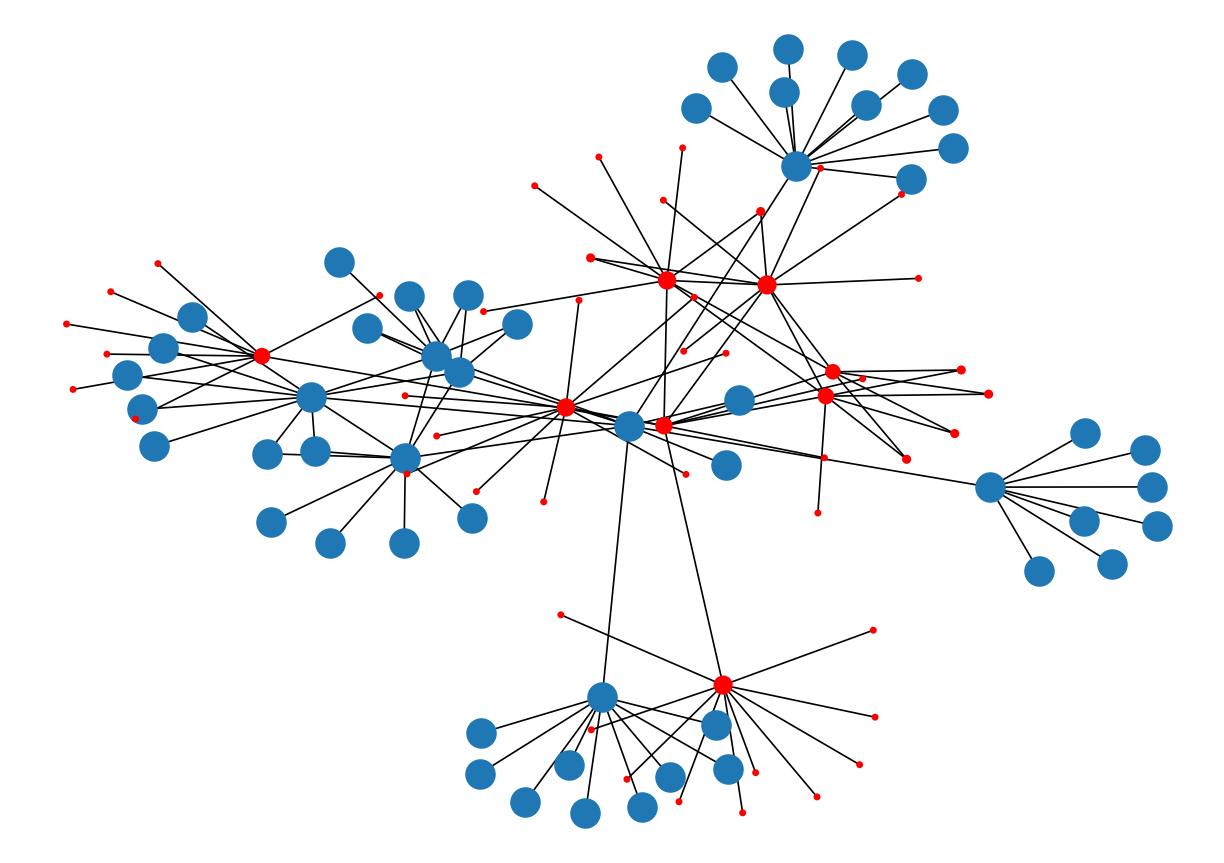

<Figure size 600x600 with 0 Axes>

https://www.theatlantic.com/politics/archive/2019/06/2020-democrats-abortion/590701/


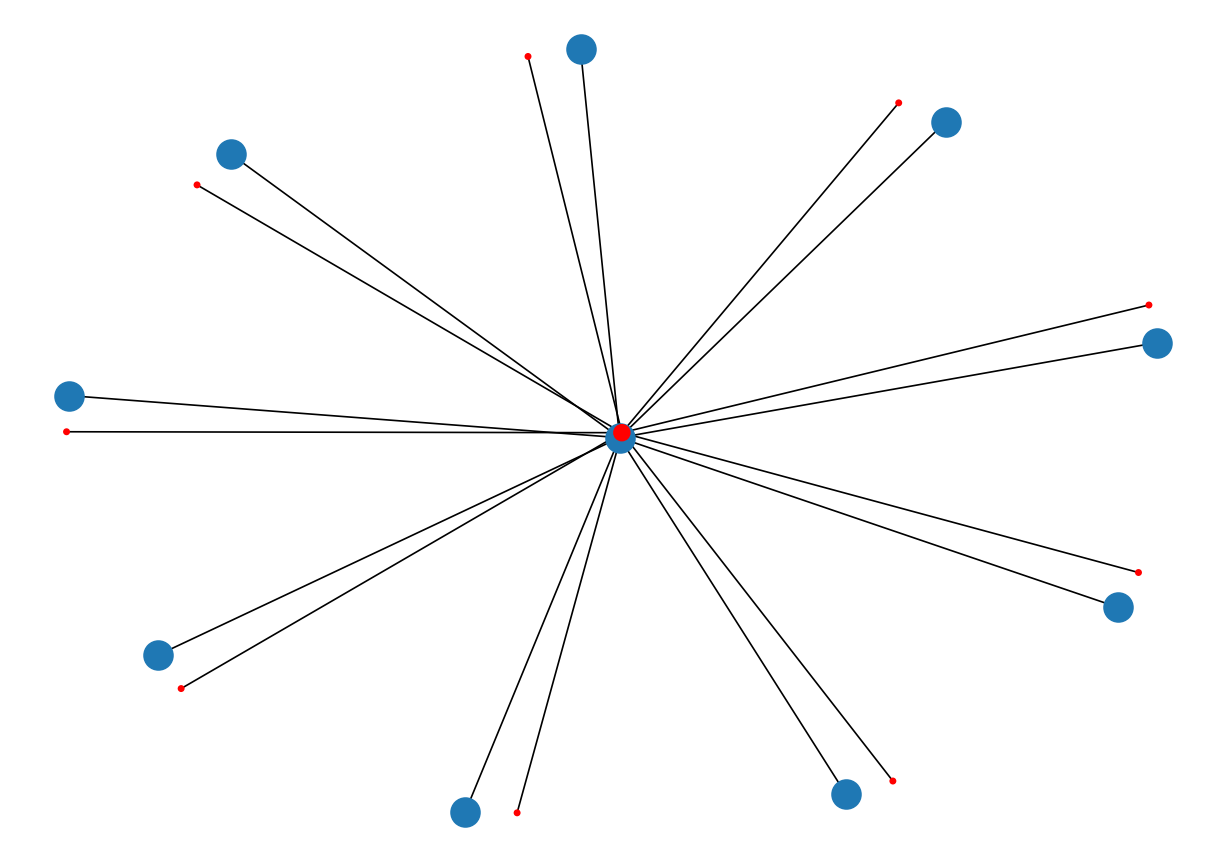

<Figure size 600x600 with 0 Axes>

In [30]:
df[['pagerank','edges', 'nodes']] = df.head(1).apply(lambda x: calculatePageRank(x['singlesource']), axis=1)

## Sample node rank/ number of edges and nodes calculation. This process consumes time. Therefore calculating them in batches and stored in CSV file below.

https://www.theatlantic.com/politics/archive/2019/06/2020-democrats-abortion/590701/


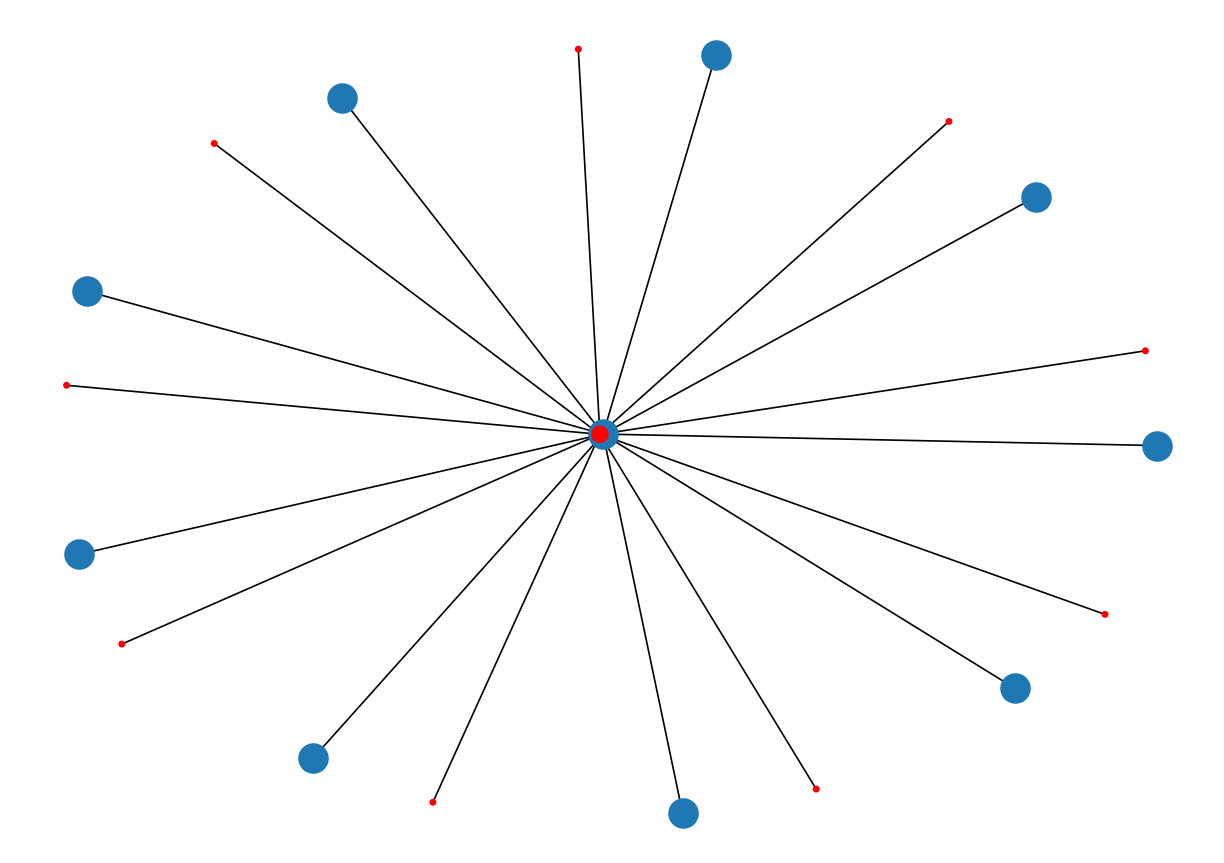

<Figure size 600x600 with 0 Axes>

0.4675675675675677
9.0
10.0
https://www.theatlantic.com/politics/archive/2013/10/coal-countrys-decline-has-a-long-history/453144/


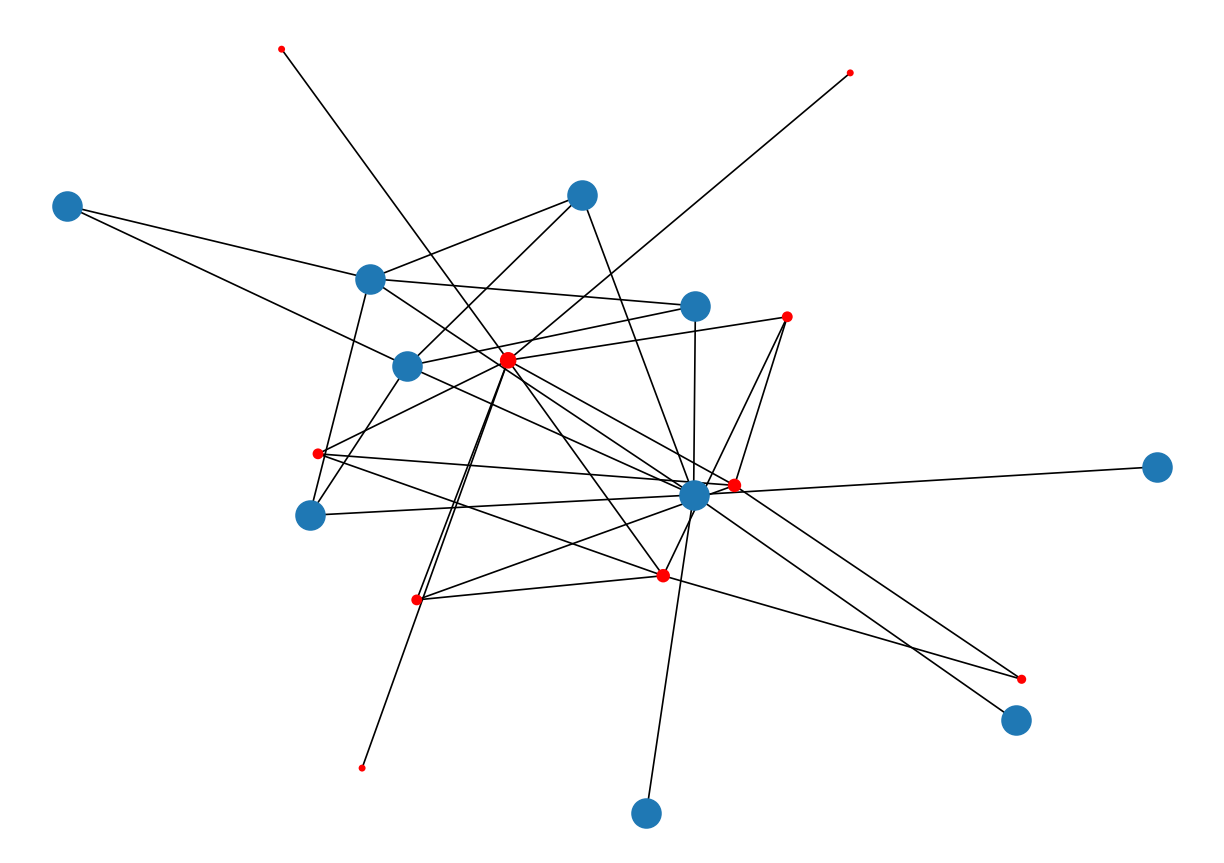

<Figure size 600x600 with 0 Axes>

0.24706192565772622
16.0
10.0
https://www.outsidethebeltway.com/obama_ties_clinton_policies_to_bushs/


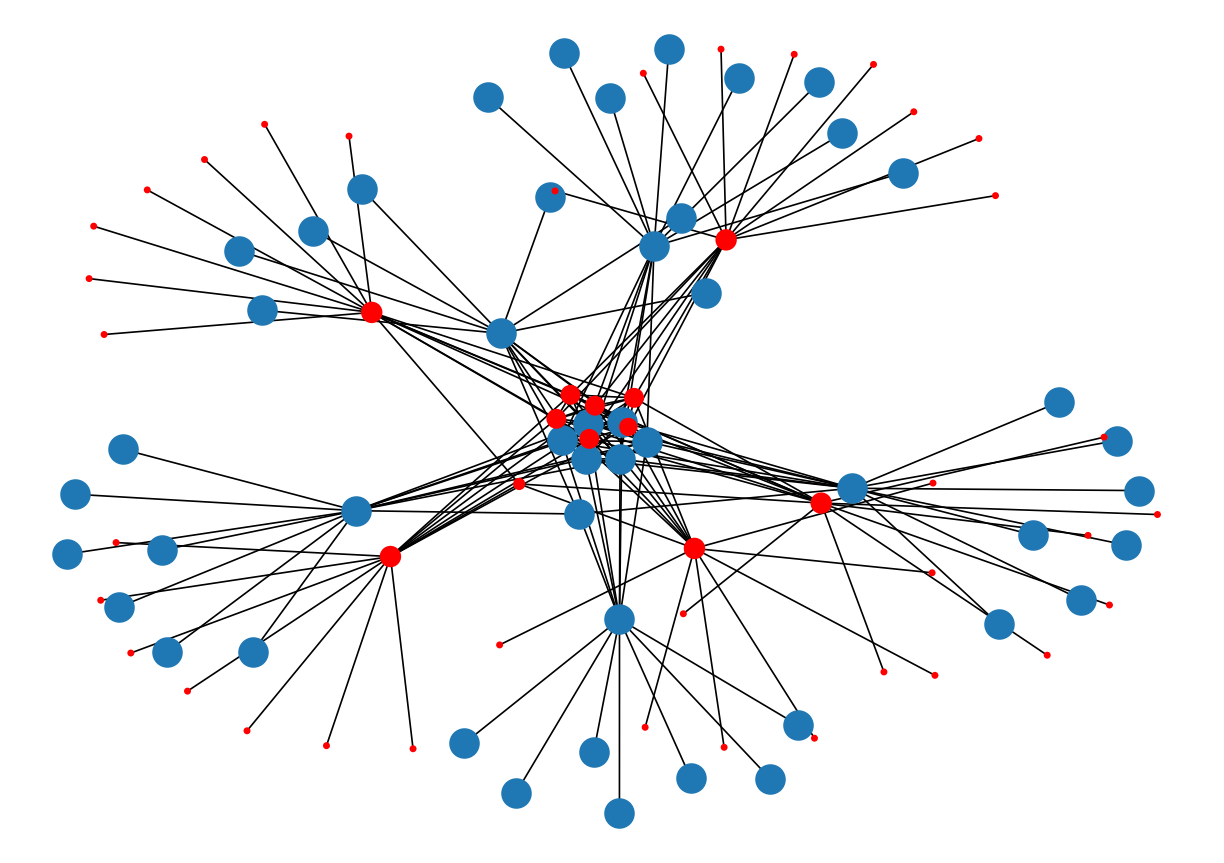

<Figure size 600x600 with 0 Axes>

0.046558446774521665
90.0
48.0


In [31]:
for key, value in df.iterrows():
  if key >= 0 and key <= 2:    
    value.pagerank, value.edges, value.nodes = calculatePageRank(value.singlesource)
    print(value.pagerank)
    print(value.edges)
    print(value.nodes)

## Loading the previously computed node rank, edges and nodes in dataframe for Liar-Liar dataset.

In [0]:
noderank_liar = base_dir + '/Alternus_vera/noderank.csv'

In [0]:
df_noderank_liar = pd.read_csv(noderank_liar, lineterminator='\n')

In [34]:
df_noderank_liar.head(5)

Unnamed: 0        class  ... edges nodes\r
0           0        FALSE  ...   2.0     3.0
1           1    half-true  ...   4.0     5.0
2           2  mostly-true  ...   6.0     6.0
3           3        FALSE  ...   5.0     3.0
4           4    half-true  ...   5.0     3.0

[5 rows x 10 columns]

## Dropping off unwanted columns

In [0]:
df_noderank_liar = df_noderank_liar.drop(columns=['Unnamed: 0', 'link', 'source'])

## Renaming the columns


In [0]:
df_noderank_liar=df_noderank_liar.rename(columns={'class':'labels', 'nodes\r': 'nodes'})

In [37]:
df_noderank_liar.head(5)

labels                                          statement  ... edges nodes
0        FALSE  Says the Annies List political group supports ...  ...   2.0   3.0
1    half-true  When did the decline of coal start? It started...  ...   4.0   5.0
2  mostly-true  Hillary Clinton agrees with John McCain "by vo...  ...   6.0   6.0
3        FALSE  Health care reform legislation is likely to ma...  ...   5.0   3.0
4    half-true  The economic turnaround started at the end of ...  ...   5.0   3.0

[5 rows x 7 columns]

In [0]:
df_noderank_liar = df_noderank_liar[:-1]

## Method for ROC-AUC curve - Multiclass Classification

In [0]:
def plot_multiclass_roc(clf, X_test, y_test, n_classes, figsize=(25,10)):
    y_score = clf.predict_proba(X_test)
   
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=(25,10))
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %i' % (roc_auc[i], i))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

## Method for Plotting Confusion Matrix

In [0]:
def plot_confusion_mat(y_test, y_pred):  
  conf_matrix = confusion_matrix(y_test.round(),y_pred.round())
  sns.set(font_scale=1.4) # for label size
  sns.heatmap(conf_matrix, annot=True) # font size
  plt.xlabel('Actual Labels')
  plt.ylabel('Predicted Labels');
  plt.show()

# Applying Classification model only on Liar-Liar - Considering only pagerank, edges, nodes

In [0]:
le = preprocessing.LabelEncoder()
le.fit(df_noderank_liar.labels)
df_noderank_liar['labels_cat'] = le.fit_transform(df_noderank_liar['labels'])

In [42]:
list(le.classes_)

['FALSE', 'TRUE', 'barely-true', 'half-true', 'mostly-true', 'pants-fire']

In [43]:
le.transform(['FALSE', 'TRUE', 'barely-true', 'half-true', 'mostly-true', 'pants-fire'])

array([0, 1, 2, 3, 4, 5])

In [44]:
labels = list(le.inverse_transform([0, 1, 2, 3, 4, 5]))
labels

['FALSE', 'TRUE', 'barely-true', 'half-true', 'mostly-true', 'pants-fire']

In [45]:
df_noderank_liar.head()

labels  ... labels_cat
0        FALSE  ...          0
1    half-true  ...          3
2  mostly-true  ...          4
3        FALSE  ...          0
4    half-true  ...          3

[5 rows x 8 columns]

In [46]:
unique_val = df_noderank_liar.speaker.unique()
len(unique_val)

1270

In [47]:
df_noderank_liar.speaker.dtype

dtype('O')

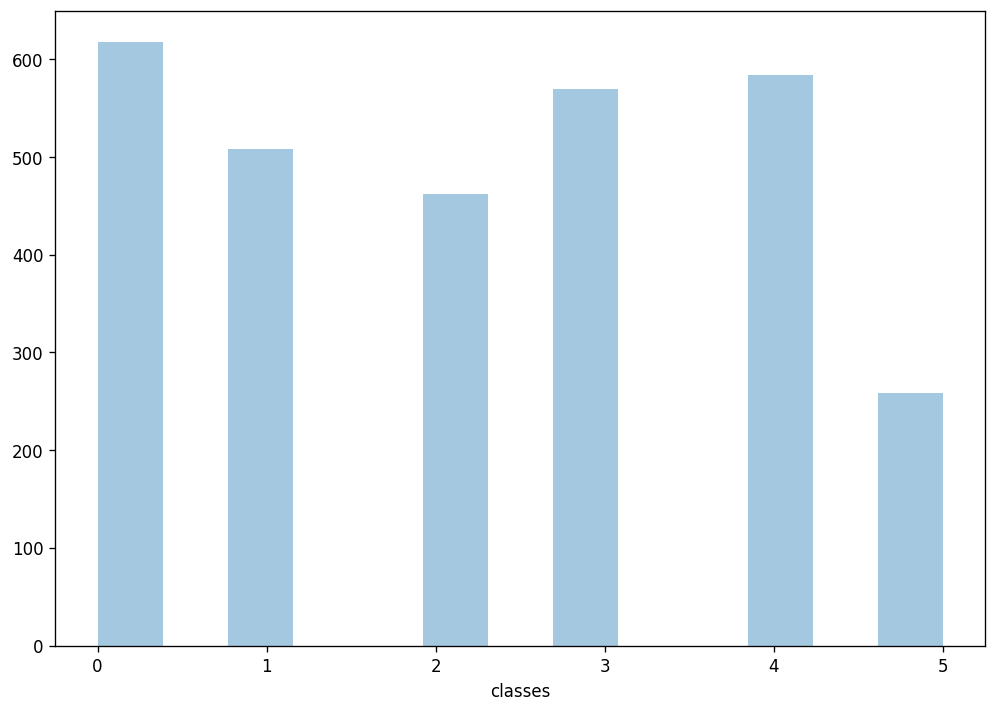

In [48]:
sns.distplot(pd.Series(df_noderank_liar.labels_cat, name="classes"), kde=False)

In [0]:
df_noderank_liar['pagerank'] = df_noderank_liar['pagerank'].apply(lambda x: x*10)

In [50]:
X = df_noderank_liar[['pagerank', 'edges', 'nodes']]
#X = df_noderank_liar[['pagerank']]
y = df_noderank_liar.labels_cat
#y = df_noderank_liar.bin_labels

#Print the shape of X and Y
print(X.shape)
print(y.shape)

(3001, 3)
(3001,)


In [0]:
# scaler = MinMaxScaler()
# X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [0]:
#X = preprocessing.scale(X)

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [55]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(2400, 3) (2400,)
(601, 3) (601,)


### Random Forest Classifier on Liar-Liar

In [56]:
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [0]:
rf_predictions = rf_classifier.predict(X_test)  

In [0]:
rf_predictions_labels = [np.argmax(p) for p in rf_predictions]

In [59]:
class_report = classification_report(y_test, rf_predictions_labels, output_dict=True)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [60]:
accuracy = accuracy_score(y_test, rf_predictions_labels)* 100.0
precision = metrics.precision_score(y_test, rf_predictions_labels, average='weighted')*100.0
recall = metrics.recall_score(y_test, rf_predictions_labels, average='weighted') * 100.0
f1score = metrics.f1_score(y_test, rf_predictions_labels, average='weighted') * 100.0

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### Overall Metrics DataFrame

In [61]:
val = {'Model': ['RandomForest (on Liar-Liar)'], 'Accuracy': [accuracy], 'Precision': [precision], 'Recall': [recall], 'F1-Score': f1score}
outputDf = pd.DataFrame(val, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])
outputDf.head()

Model   Accuracy  Precision     Recall  F1-Score
0  RandomForest (on Liar-Liar)  19.633943   3.854917  19.633943  6.444521

#### Plotting Confusion Matrix

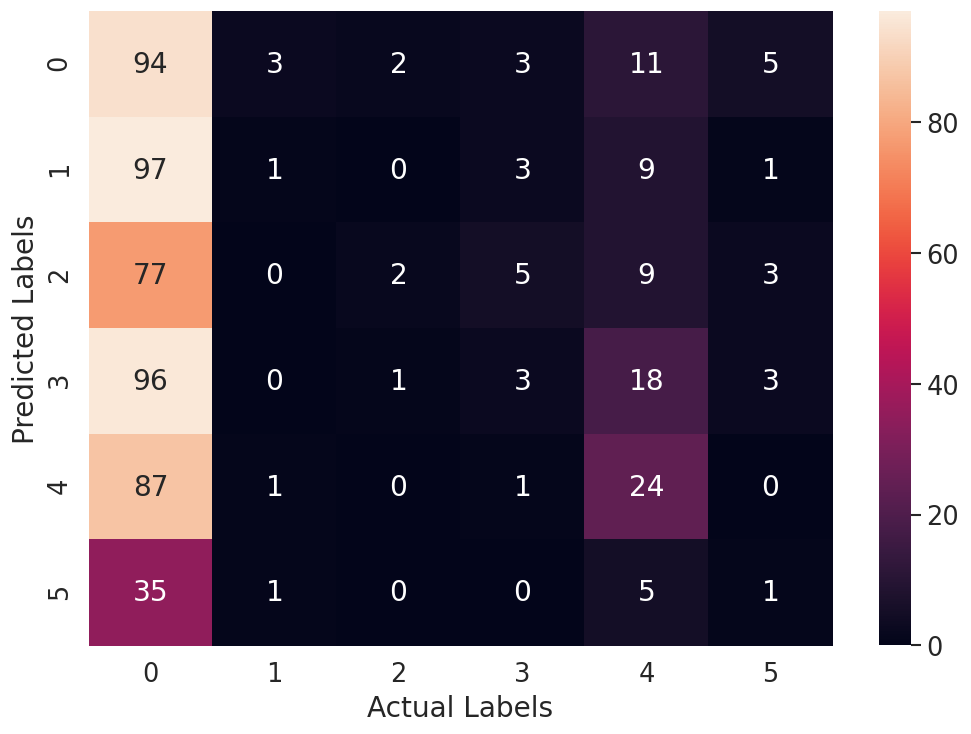

In [62]:
plot_confusion_mat(y_test, rf_predictions)

#### ROC Curve

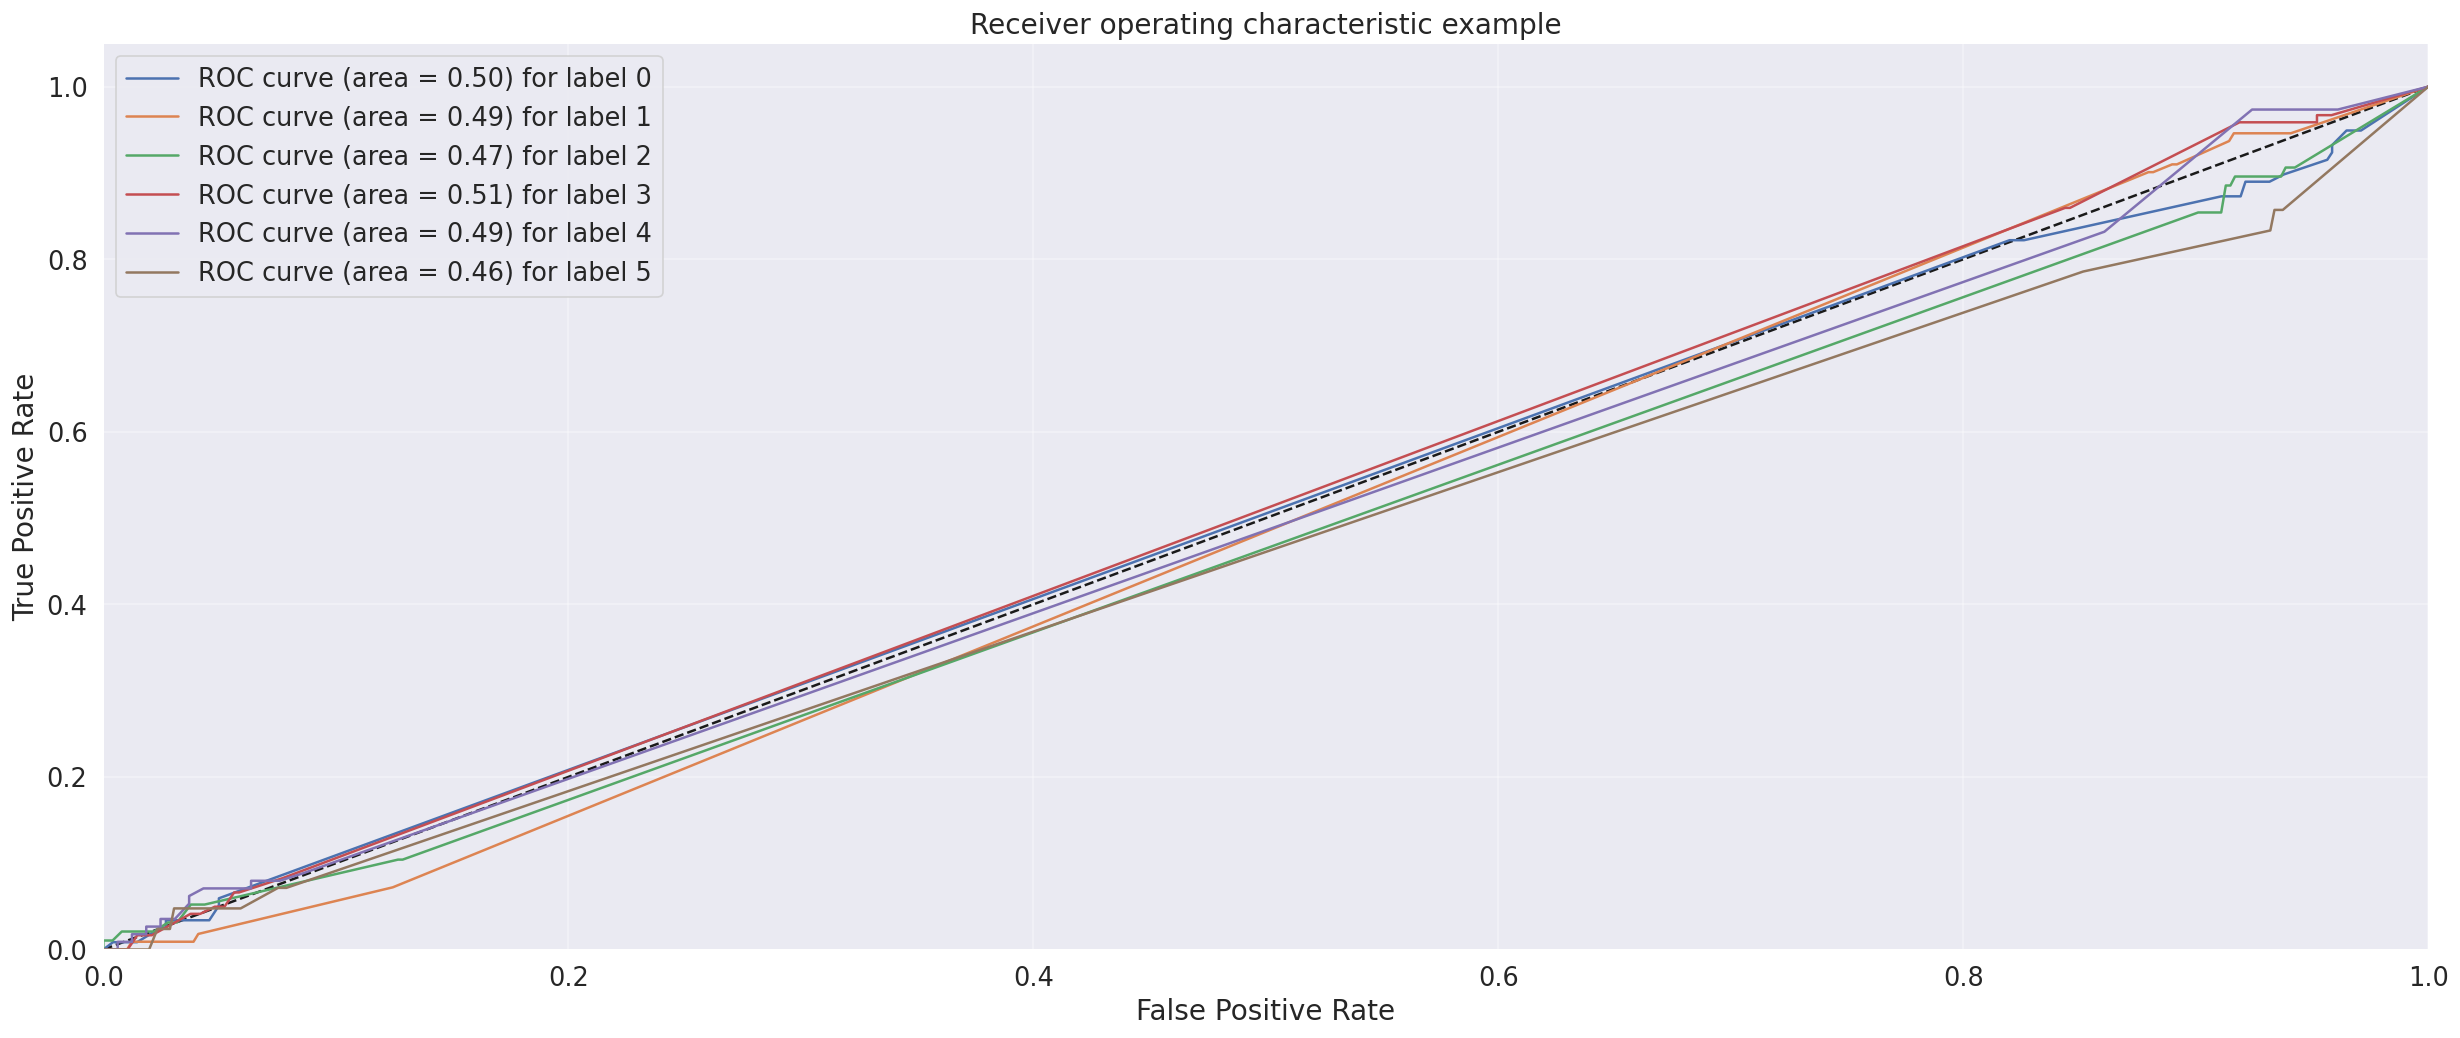

In [63]:
plot_multiclass_roc(rf_classifier, X_test, y_test, n_classes=6, figsize=(7, 5))

### Decision Tree on Liar Liar Dataset

In [0]:
clf = tree.DecisionTreeClassifier() 
clf = clf.fit(X_train, y_train)

In [0]:
tree_pred = clf.predict(X_test)

In [0]:
tree_pred_labels = [np.argmax(p) for p in tree_pred]

In [67]:
class_report = classification_report(y_test, tree_pred_labels, output_dict=True)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [68]:
accuracy = accuracy_score(y_test, tree_pred_labels)* 100.0
precision = metrics.precision_score(y_test, tree_pred_labels, average='weighted')*100.0
recall = metrics.recall_score(y_test, tree_pred_labels, average='weighted') * 100.0
f1score = metrics.f1_score(y_test, tree_pred_labels, average='weighted') * 100.0

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### Overall Metrics DataFrame

In [69]:
val = {'Model': ['Decision Tree (on Liar-Liar)'], 'Accuracy': [accuracy], 'Precision': [precision], 'Recall': [recall], 'F1-Score': f1score}
outputDf1 = pd.DataFrame(val, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])
outputDf = pd.concat([outputDf, outputDf1], ignore_index=True, sort=False)
outputDf.head()

Model   Accuracy  Precision     Recall  F1-Score
0   RandomForest (on Liar-Liar)  19.633943   3.854917  19.633943  6.444521
1  Decision Tree (on Liar-Liar)  19.633943   3.854917  19.633943  6.444521

#### Plotting Confusion Matrix

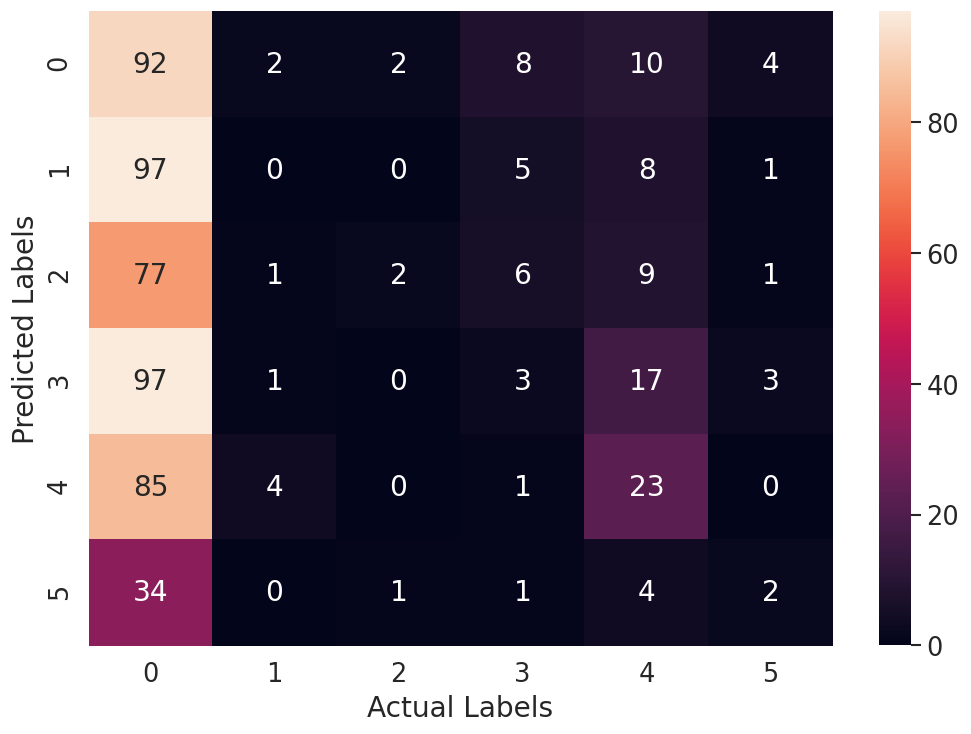

In [70]:
plot_confusion_mat(y_test, tree_pred)

#### ROC Curve

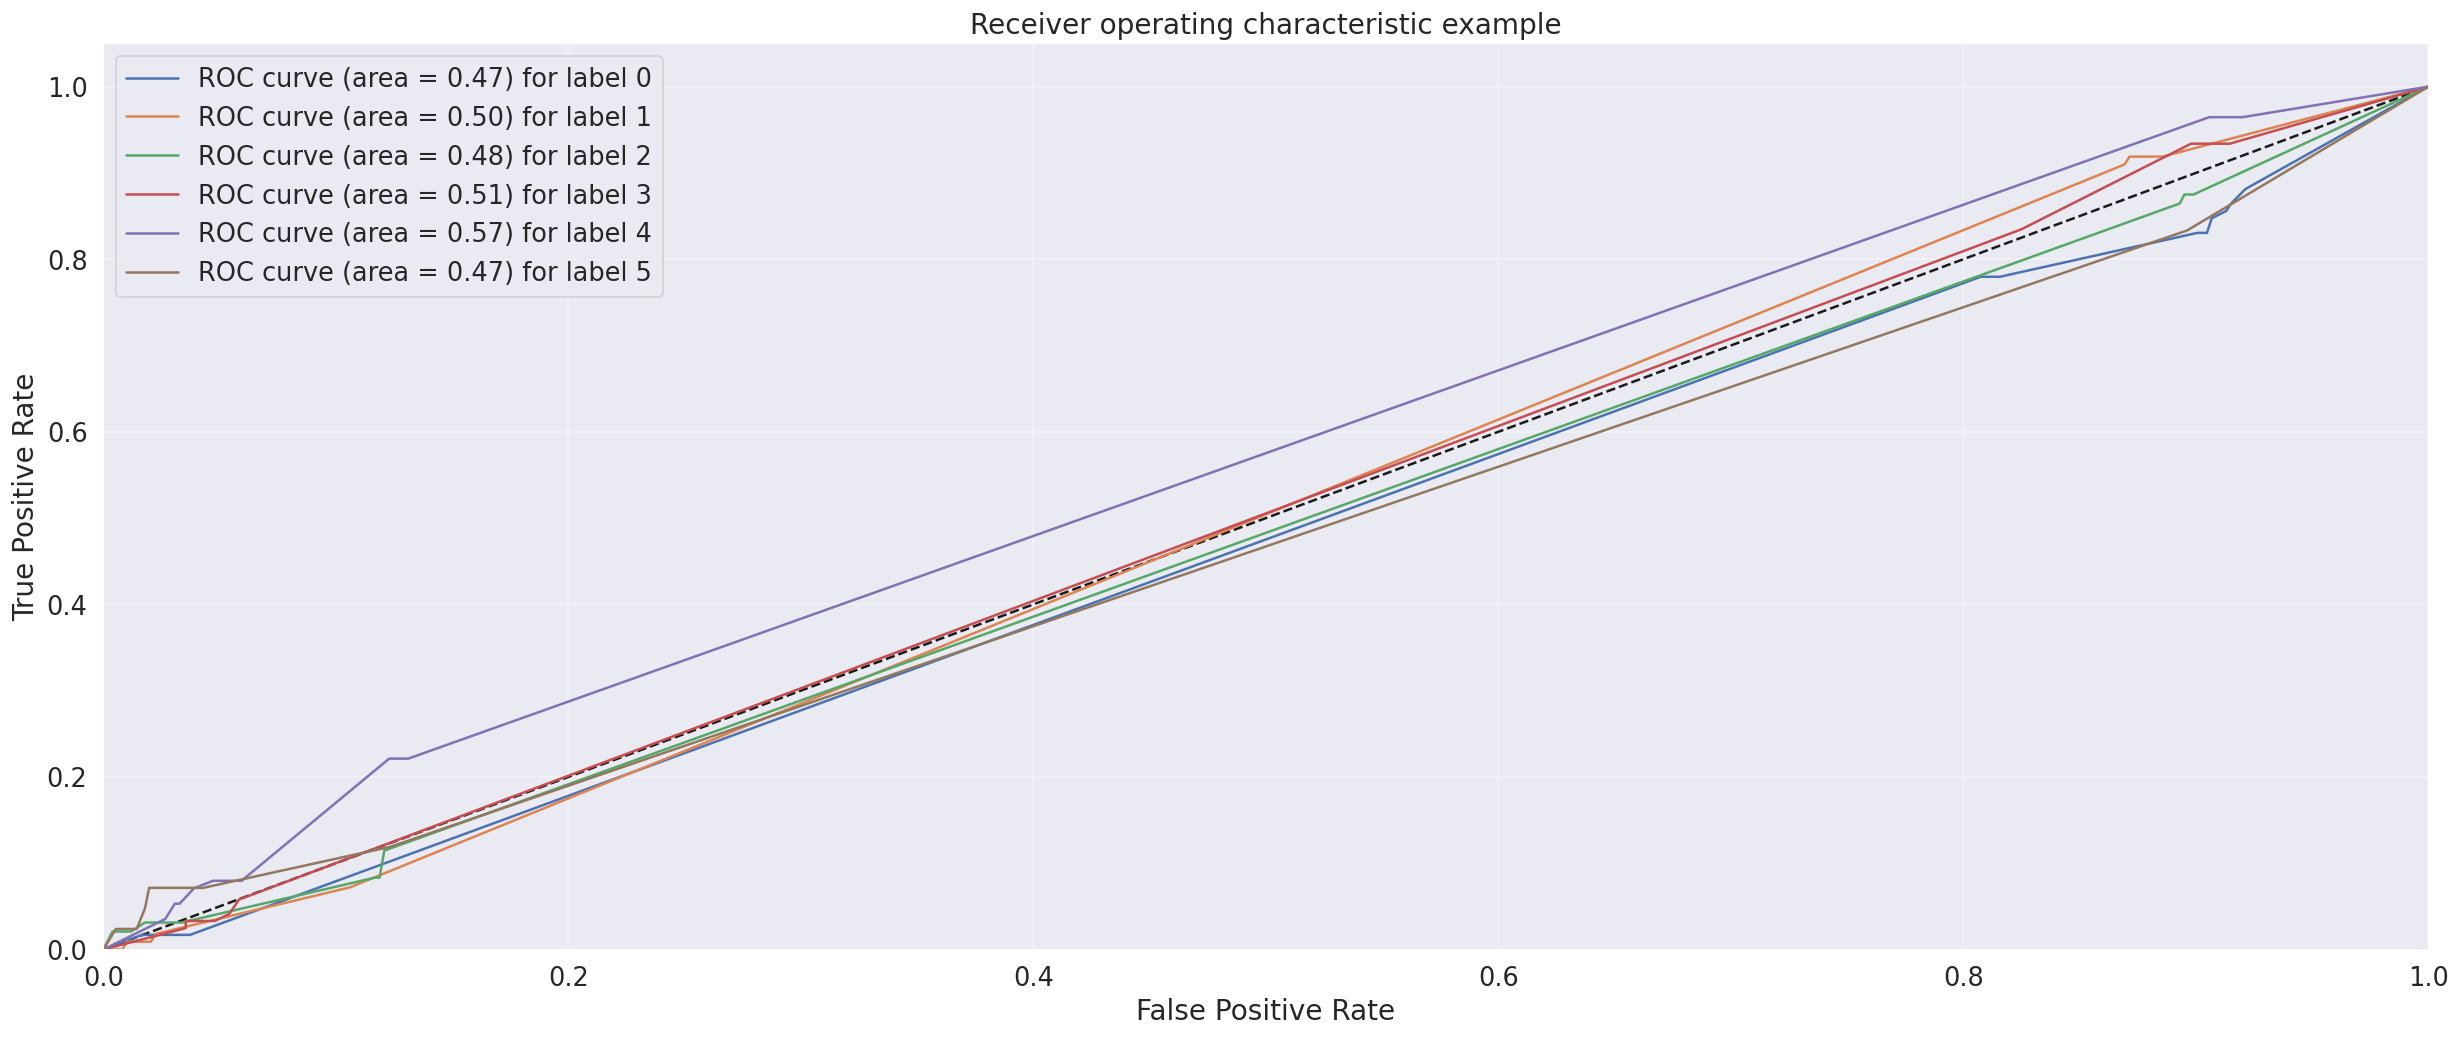

In [71]:
plot_multiclass_roc(clf, X_test, y_test, n_classes=6, figsize=(7, 5))

### XGBoost on Liar Liar Dataset

In [72]:
xgModel = XGBClassifier()
xgModel.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='multi:softprob', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

In [0]:
y_pred = xgModel.predict(X_test)
xgb_predictions_labels = [round(value) for value in y_pred]

In [0]:
accuracy = accuracy_score(y_test, xgb_predictions_labels)* 100.0
precision = metrics.precision_score(y_test, xgb_predictions_labels, average='weighted')*100.0
recall = metrics.recall_score(y_test, xgb_predictions_labels, average='weighted') * 100.0
f1score = metrics.f1_score(y_test, xgb_predictions_labels, average='weighted') * 100.0

#### Overall Metrics DataFrame

In [75]:
val = {'Model': ['XGBoost (on Liar-Liar)'], 'Accuracy': [accuracy], 'Precision': [precision], 'Recall': [recall], 'F1-Score': f1score}
outputDf3 = pd.DataFrame(val, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])
outputDf = pd.concat([outputDf, outputDf3], ignore_index=True, sort=False)
outputDf.head()

Model   Accuracy  Precision     Recall   F1-Score
0   RandomForest (on Liar-Liar)  19.633943   3.854917  19.633943   6.444521
1  Decision Tree (on Liar-Liar)  19.633943   3.854917  19.633943   6.444521
2        XGBoost (on Liar-Liar)  20.133111  12.931965  20.133111  11.448511

#### Plotting Confusion Matrix

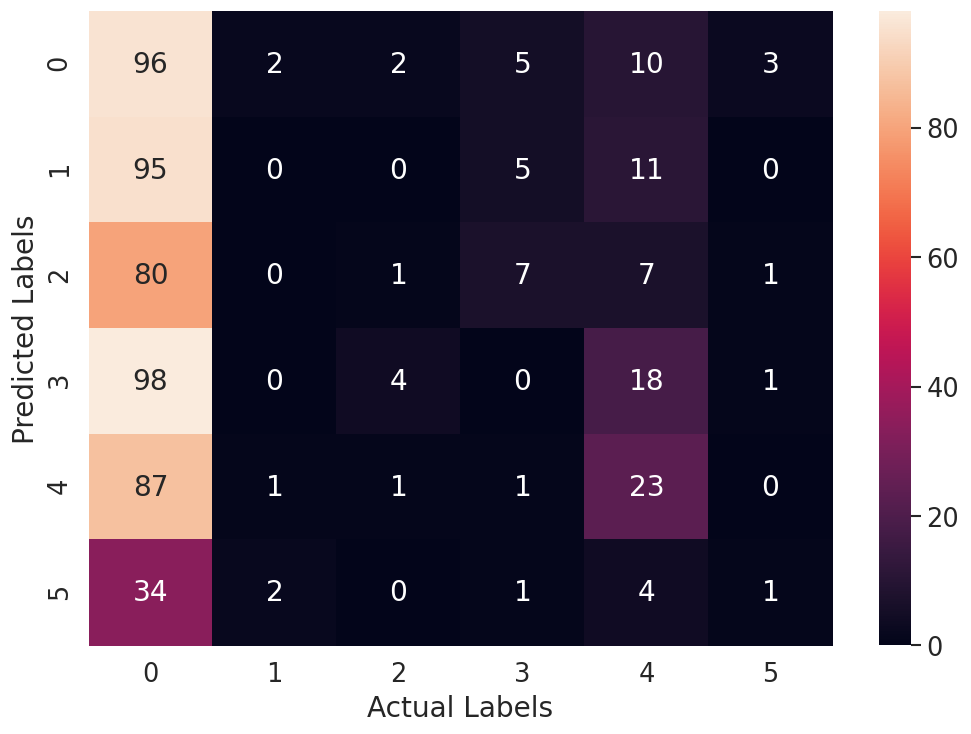

In [76]:
plot_confusion_mat(y_test, y_pred)

#### ROC Curve

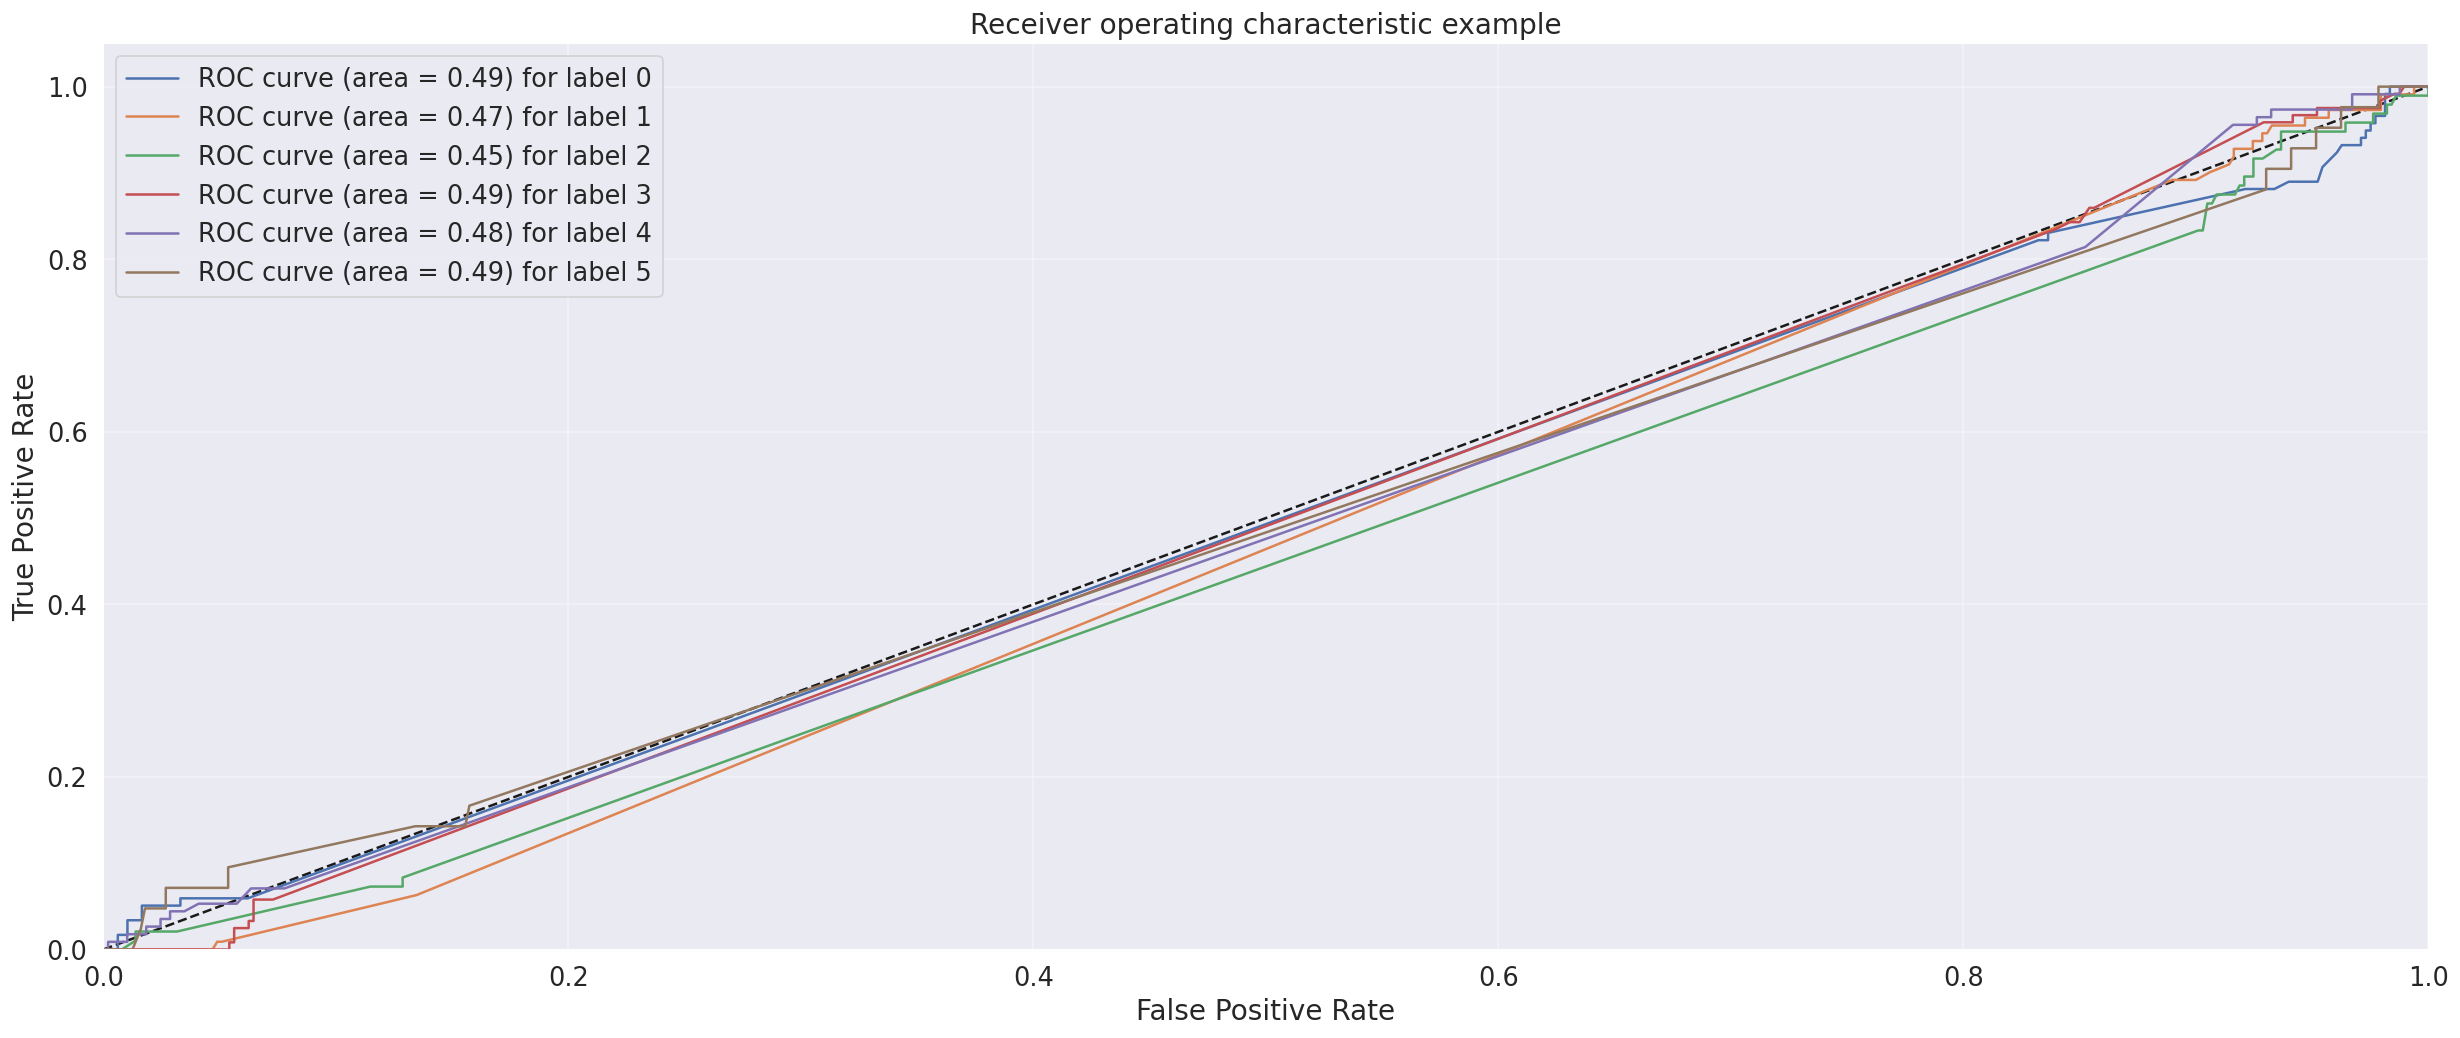

In [77]:
plot_multiclass_roc(xgModel, X_test, y_test, n_classes=6, figsize=(7, 5))

## MultinomialNB on Liar Liar Dataset

In [78]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [0]:
y_pred = clf.predict(X_test)

In [80]:
accuracy = accuracy_score(y_test, y_pred)* 100.0
precision = metrics.precision_score(y_test, y_pred, average='weighted')*100.0
recall = metrics.recall_score(y_test, y_pred, average='weighted') * 100.0
f1score = metrics.f1_score(y_test, y_pred, average='weighted') * 100.0

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### Overall Metrics DataFrame

In [81]:
val = {'Model': ['MultinomialNB (on Liar-Liar)'], 'Accuracy': [accuracy], 'Precision': [precision], 'Recall': [recall], 'F1-Score': f1score}
outputDf10 = pd.DataFrame(val, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])
outputDf = pd.concat([outputDf, outputDf10], ignore_index=True, sort=False)
outputDf.head()

Model   Accuracy  Precision     Recall   F1-Score
0   RandomForest (on Liar-Liar)  19.633943   3.854917  19.633943   6.444521
1  Decision Tree (on Liar-Liar)  19.633943   3.854917  19.633943   6.444521
2        XGBoost (on Liar-Liar)  20.133111  12.931965  20.133111  11.448511
3  MultinomialNB (on Liar-Liar)  17.970050  11.771429  17.970050   8.394355

#### Plotting Confusion Matrix

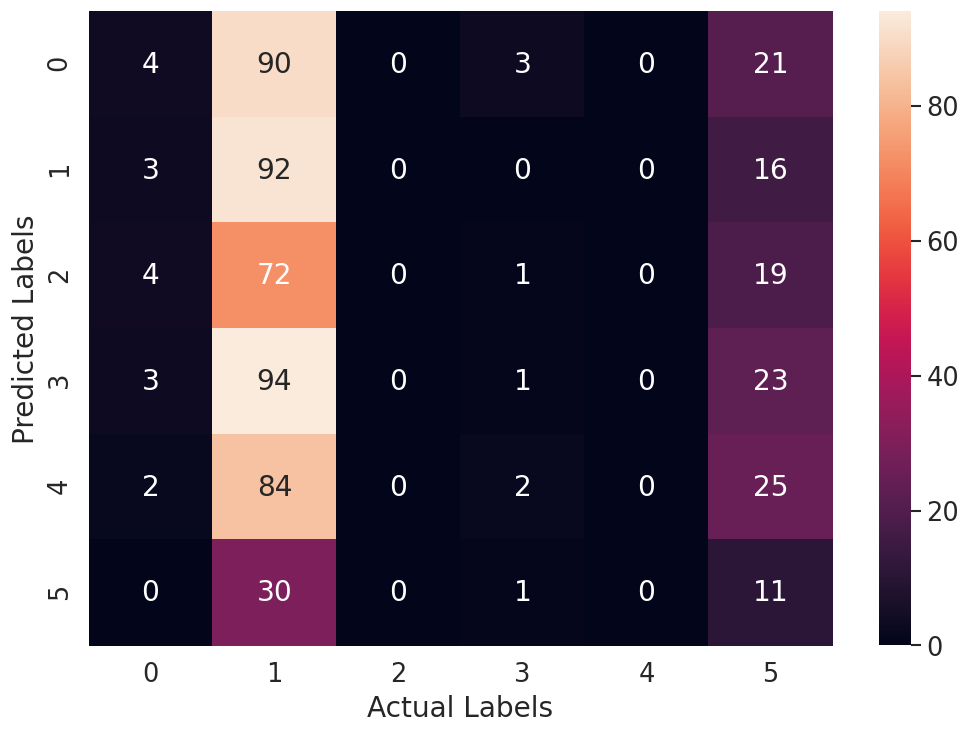

In [82]:
plot_confusion_mat(y_test, y_pred)

#### ROC Curve

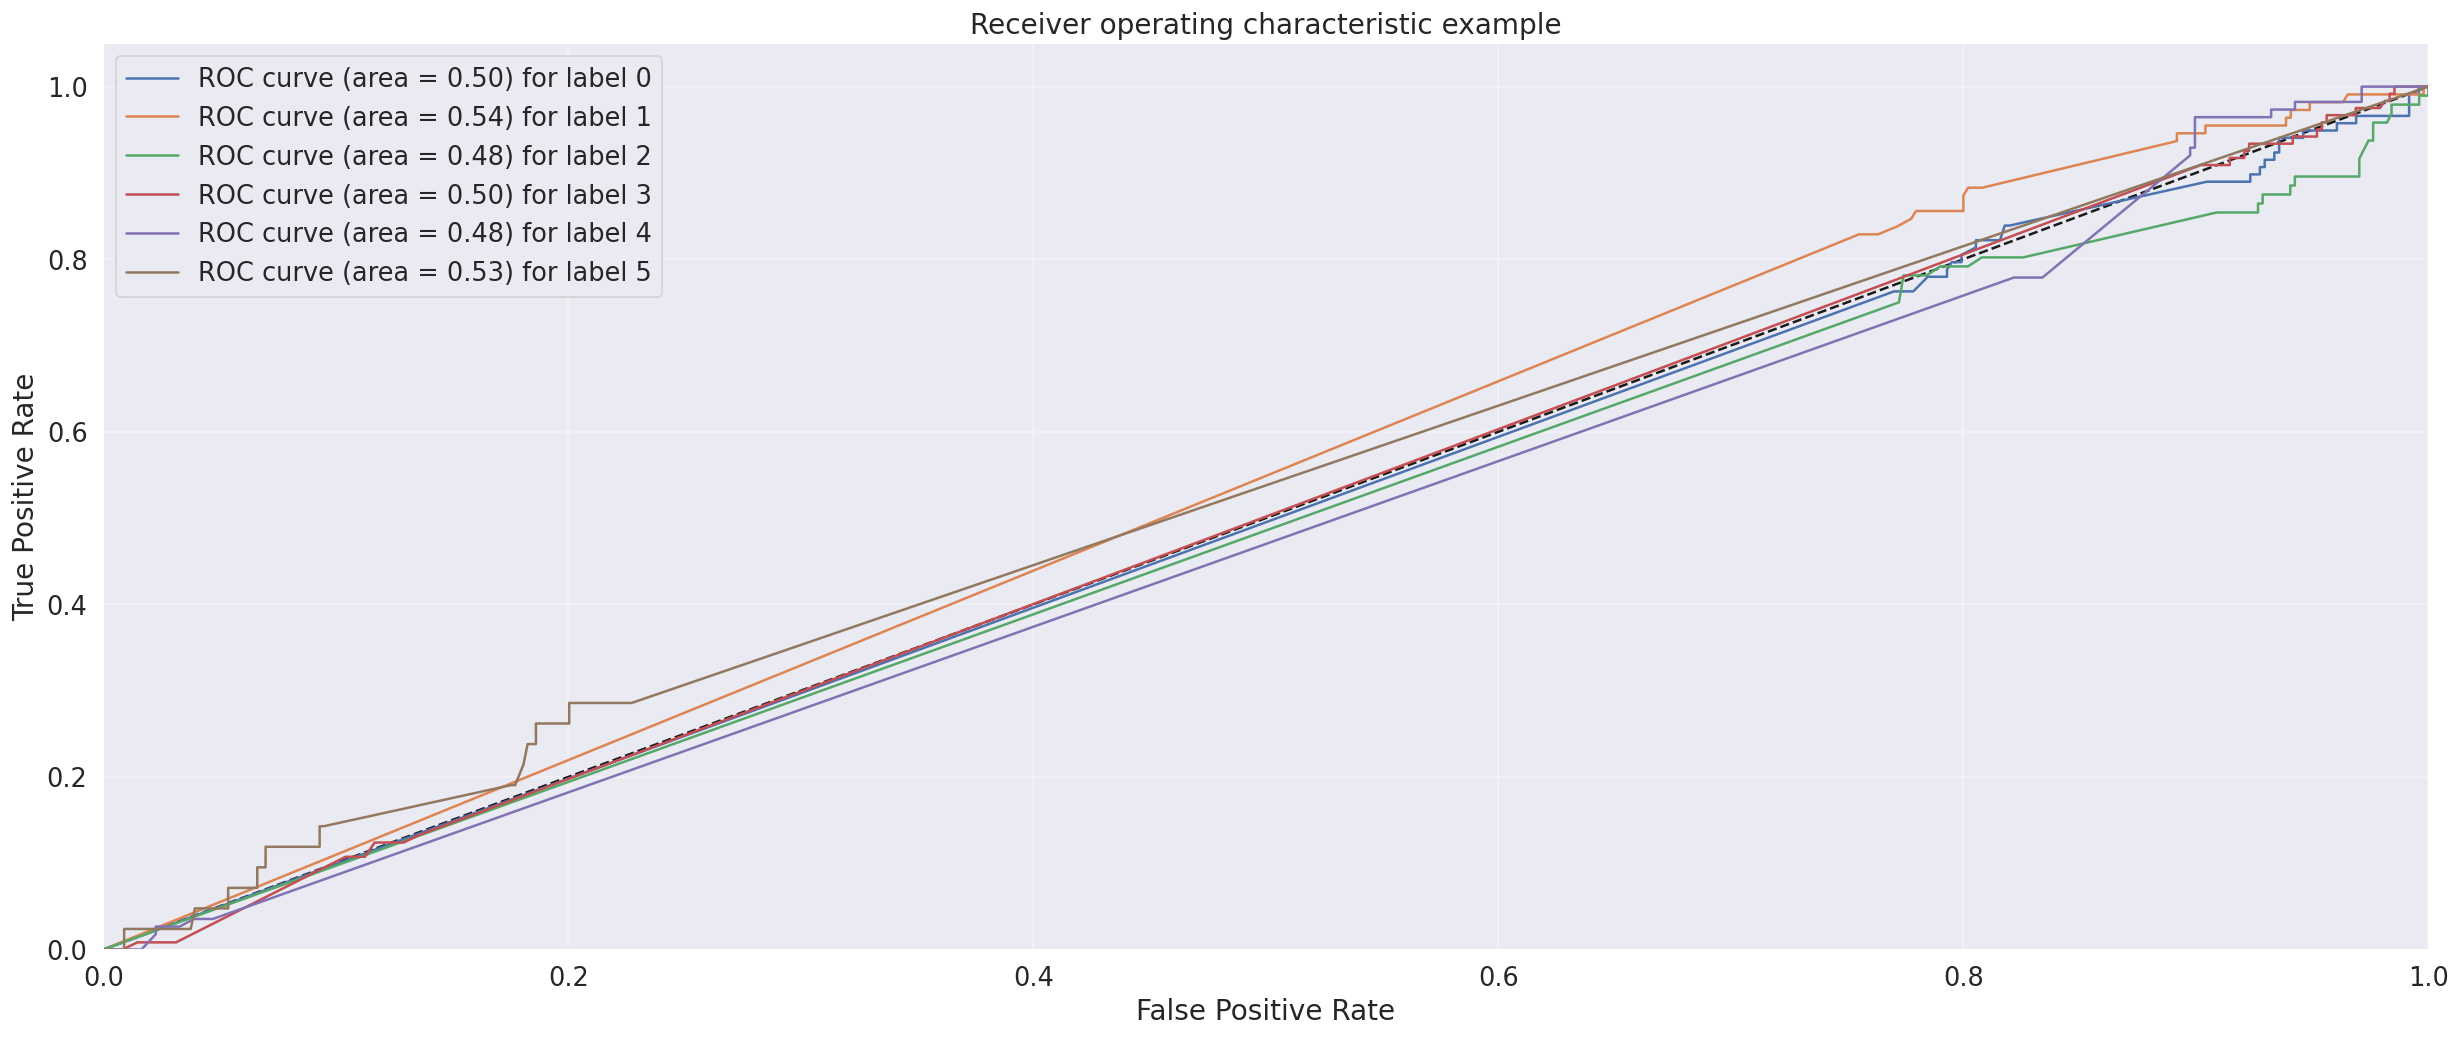

In [83]:
plot_multiclass_roc(clf, X_test, y_test, n_classes=6, figsize=(7, 5))

# Loading News Category Dataset

In [0]:
noderank_newscat = base_dir + '/Alternus_vera/noderanknewscat.csv'

In [0]:
df_noderank_newscat = pd.read_csv(noderank_newscat, lineterminator='\n')

In [86]:
df_noderank_newscat.shape

(32739, 8)

In [0]:
df_noderank_newscat = df_noderank_newscat.head(1100)

In [0]:
df_noderank_newscat = df_noderank_newscat[['headline', 'authors','link', 'pagerank','edges','nodes\r']].head(1100)

In [0]:
df_noderank_newscat=df_noderank_newscat.rename(columns={'nodes\r': 'nodes'})

In [90]:
df_noderank_newscat.shape

(1100, 6)

In [0]:
newscat_labels = base_dir + '/Alternus_vera/newsCatLabels.csv'

In [0]:
df_newscat_labels = pd.read_csv(newscat_labels, lineterminator='\n')

In [0]:
df_newscat_labels = df_newscat_labels.head(1100)

In [94]:
df_newscat_labels.shape

(1100, 9)

In [0]:
df_newscat_labels = df_newscat_labels.rename(columns={'headline':'headlines', 'authors': 'speakers', 'link':'links'})

In [0]:
df_newscat = pd.concat([df_noderank_newscat, df_newscat_labels], axis=1, sort=False)

In [97]:
df_newscat.head(2)

headline  ...  textlabel
0  Trump's Crackdown On Immigrant Parents Puts Mo...  ...  half-true
1  Trump's Son Should Be Concerned': FBI Obtained...  ...  half-true

[2 rows x 15 columns]

In [0]:
cols = [6,7,8,9,10,12]
df_newscat.drop(df_newscat.columns[cols], axis=1, inplace=True)

In [99]:
df_newscat.head(2)

headline  ...  textlabel
0  Trump's Crackdown On Immigrant Parents Puts Mo...  ...  half-true
1  Trump's Son Should Be Concerned': FBI Obtained...  ...  half-true

[2 rows x 9 columns]

# Amalgamating News Category and Liar Liar Dataset

In [100]:
df_newscat.head(2)

headline  ...  textlabel
0  Trump's Crackdown On Immigrant Parents Puts Mo...  ...  half-true
1  Trump's Son Should Be Concerned': FBI Obtained...  ...  half-true

[2 rows x 9 columns]

In [101]:
df_noderank_liar.head(2)

labels  ... labels_cat
0      FALSE  ...          0
1  half-true  ...          3

[2 rows x 8 columns]

In [0]:
df_noderank_liar.drop(df_noderank_liar.columns[7], axis=1, inplace=True)

In [0]:
df_newscat.drop(df_newscat.columns[[0, 6]], axis=1, inplace=True)

In [0]:
df_newscat = df_newscat.rename(columns={'clean_text':'clean_statement', 'authors': 'speaker', 'textlabel':'labels'})

In [105]:
df_newscat.head(2)

speaker  ...     labels
0  Elise Foley and Roque Planas  ...  half-true
1   Michael Isikoff, Yahoo News  ...  half-true

[2 rows x 7 columns]

In [0]:
df_noderank_liar = df_noderank_liar.rename(columns={'statement':'clean_statement', 'singlesource':'link'})

In [107]:
df_noderank_liar.head(2)

labels                                    clean_statement  ... edges nodes
0      FALSE  Says the Annies List political group supports ...  ...   2.0   3.0
1  half-true  When did the decline of coal start? It started...  ...   4.0   5.0

[2 rows x 7 columns]

In [0]:
frames = [df_noderank_liar, df_newscat]
df_amalgamate = pd.concat(frames)

In [109]:
df_amalgamate.head(10)

labels                                    clean_statement  ... edges nodes
0        FALSE  Says the Annies List political group supports ...  ...   2.0   3.0
1    half-true  When did the decline of coal start? It started...  ...   4.0   5.0
2  mostly-true  Hillary Clinton agrees with John McCain "by vo...  ...   6.0   6.0
3        FALSE  Health care reform legislation is likely to ma...  ...   5.0   3.0
4    half-true  The economic turnaround started at the end of ...  ...   5.0   3.0
5         TRUE  The Chicago Bears have had more starting quart...  ...   0.0   1.0
6  barely-true  Jim Dunnam has not lived in the district he re...  ...   0.0   1.0
7    half-true  I'm the only person on this stage who has work...  ...   0.0   1.0
8    half-true  However, it took $19.5 million in Oregon Lotte...  ...   2.0   2.0
9  mostly-true  Says GOP primary opponents Glenn Grothman and ...  ...   0.0   1.0

[10 rows x 7 columns]

In [110]:
df_amalgamate.shape

(4101, 7)

# Applying Classifier models on amalgamated dataset - Liar Liar and NewsCat - Considering only pagerank, edges, nodes

In [0]:
le = preprocessing.LabelEncoder()
le.fit(df_amalgamate.labels)
df_amalgamate['labels_cat'] = le.fit_transform(df_amalgamate['labels'])

In [112]:
df_amalgamate.head(1)

labels                                    clean_statement  ... nodes labels_cat
0  FALSE  Says the Annies List political group supports ...  ...   3.0          0

[1 rows x 8 columns]

In [0]:
#df_amalgamate['pagerank'] = df_amalgamate['pagerank'].apply(lambda x: x*10)

In [0]:
numericDF1 = df_amalgamate[['pagerank', 'edges', 'nodes']]

In [0]:
col_names_list = list(numericDF1.columns.values)

In [116]:
X = df_amalgamate[['pagerank', 'edges', 'nodes']]
y = df_amalgamate.labels_cat

print(X.shape)
print(y.shape)

(4101, 3)
(4101,)


In [0]:
scaler = MinMaxScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [118]:
list(le.classes_)

['FALSE', 'TRUE', 'barely-true', 'half-true', 'mostly-true', 'pants-fire']

In [119]:
le.transform(['FALSE', 'TRUE', 'barely-true', 'half-true', 'mostly-true', 'pants-fire'])

array([0, 1, 2, 3, 4, 5])

In [120]:
df_amalgamate.shape

(4101, 8)

In [121]:
df_amalgamate.head(2)

labels  ... labels_cat
0      FALSE  ...          0
1  half-true  ...          3

[2 rows x 8 columns]

In [0]:
#X = preprocessing.scale(X)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Random Forest on Liar Liar and News Category

In [124]:
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [0]:
rf_predictions = rf_classifier.predict(X_test)  

In [0]:
rf_predictions_labels = [np.argmax(p) for p in rf_predictions]

In [127]:
accuracy = accuracy_score(y_test, rf_predictions_labels)* 100.0
precision = metrics.precision_score(y_test, rf_predictions_labels, average='weighted')*100.0
recall = metrics.recall_score(y_test, rf_predictions_labels, average='weighted') * 100.0
f1score = metrics.f1_score(y_test, rf_predictions_labels, average='weighted') * 100.0

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### Overall Metrics DataFrame

In [128]:
val = {'Model': ['RandomForest (on Liar-Liar/News Category)'], 'Accuracy': [accuracy], 'Precision': [precision], 'Recall': [recall], 'F1-Score': f1score}
outputDf4 = pd.DataFrame(val, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])
outputDf = pd.concat([outputDf, outputDf4], ignore_index=True, sort=False)
outputDf.head()

Model   Accuracy  ...     Recall   F1-Score
0                RandomForest (on Liar-Liar)  19.633943  ...  19.633943   6.444521
1               Decision Tree (on Liar-Liar)  19.633943  ...  19.633943   6.444521
2                     XGBoost (on Liar-Liar)  20.133111  ...  20.133111  11.448511
3               MultinomialNB (on Liar-Liar)  17.970050  ...  17.970050   8.394355
4  RandomForest (on Liar-Liar/News Category)  16.321559  ...  16.321559   4.580291

[5 rows x 5 columns]

#### Feature Importance

In [129]:
feature_imp = pd.Series(rf_classifier.feature_importances_, index=['pagerank', 'edges', 'nodes']).sort_values(ascending=False)
feature_imp

nodes       0.456463
edges       0.310079
pagerank    0.233458
dtype: float64

No handles with labels found to put in legend.


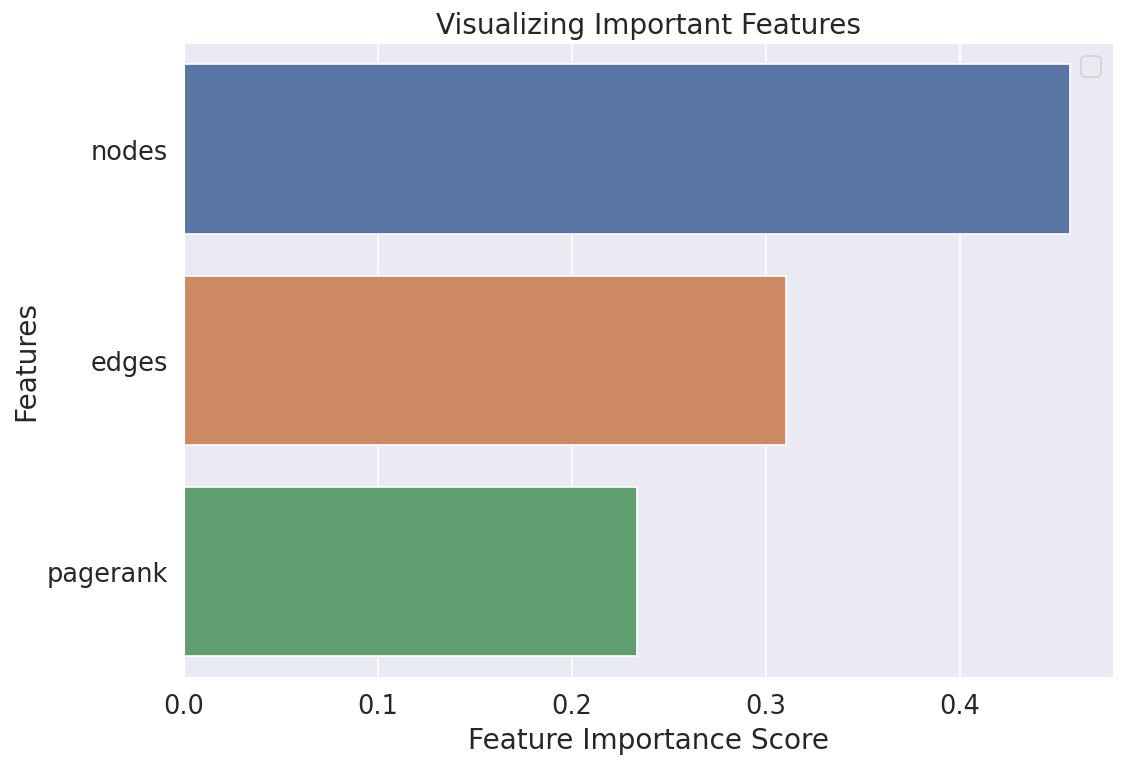

In [130]:
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.rcParams['figure.figsize'] = [15, 7]
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

#### Plotting Confusion Matrix

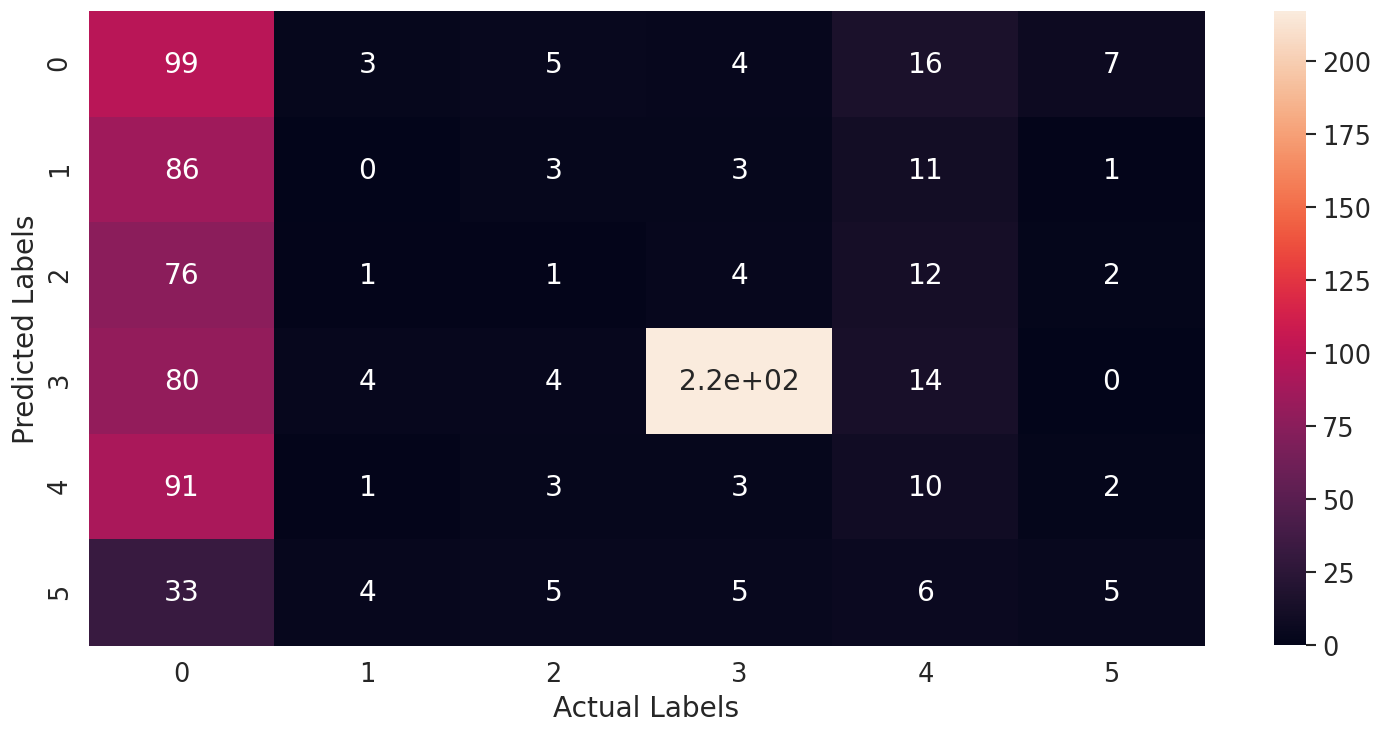

In [131]:
plot_confusion_mat(y_test, rf_predictions)

#### ROC Curve

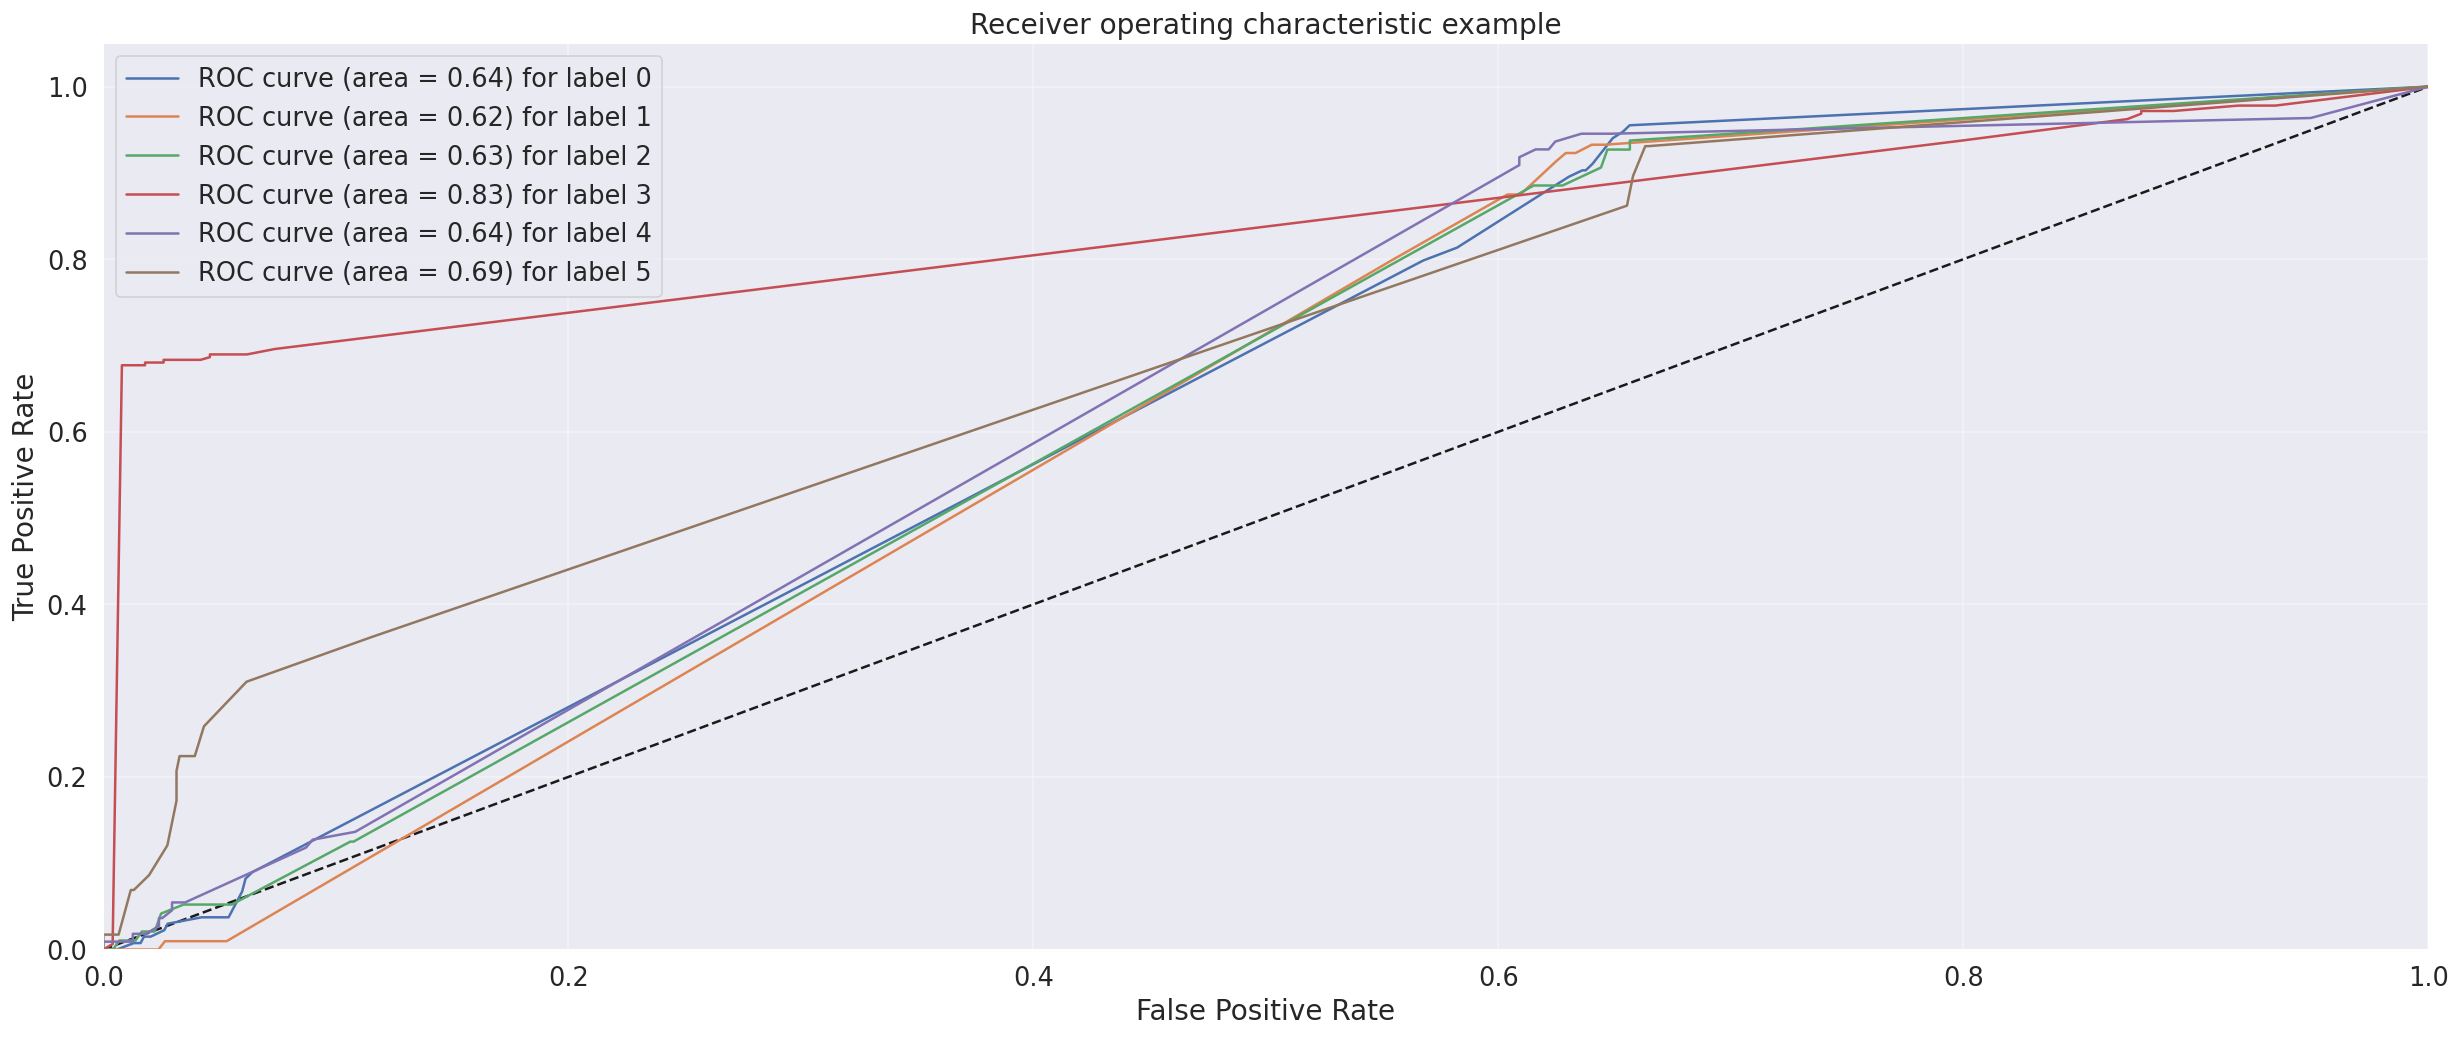

In [132]:
plot_multiclass_roc(rf_classifier, X_test, y_test, n_classes=6, figsize=(7, 5))

## XGBoost on Liar Liar and News Category

In [133]:
xgModel = XGBClassifier()
xgModel.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='multi:softprob', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

In [0]:
y_pred = xgModel.predict(X_test)
xgb_predictions_labels = [round(value) for value in y_pred]

In [0]:
accuracy = accuracy_score(y_test, xgb_predictions_labels)* 100.0
precision = metrics.precision_score(y_test, xgb_predictions_labels, average='weighted')*100.0
recall = metrics.recall_score(y_test, xgb_predictions_labels, average='weighted') * 100.0
f1score = metrics.f1_score(y_test, xgb_predictions_labels, average='weighted') * 100.0

#### Overall Metrics DataFrame

In [136]:
val = {'Model': ['XGBoost (on Liar-Liar/News Category)'], 'Accuracy': [accuracy], 'Precision': [precision], 'Recall': [recall], 'F1-Score': f1score}
outputDf5 = pd.DataFrame(val, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])
outputDf = pd.concat([outputDf, outputDf5], ignore_index=True, sort=False)
outputDf.head(20)

Model   Accuracy  ...     Recall   F1-Score
0                RandomForest (on Liar-Liar)  19.633943  ...  19.633943   6.444521
1               Decision Tree (on Liar-Liar)  19.633943  ...  19.633943   6.444521
2                     XGBoost (on Liar-Liar)  20.133111  ...  20.133111  11.448511
3               MultinomialNB (on Liar-Liar)  17.970050  ...  17.970050   8.394355
4  RandomForest (on Liar-Liar/News Category)  16.321559  ...  16.321559   4.580291
5       XGBoost (on Liar-Liar/News Category)  40.925700  ...  40.925700  38.623256

[6 rows x 5 columns]

#### Feature Importance

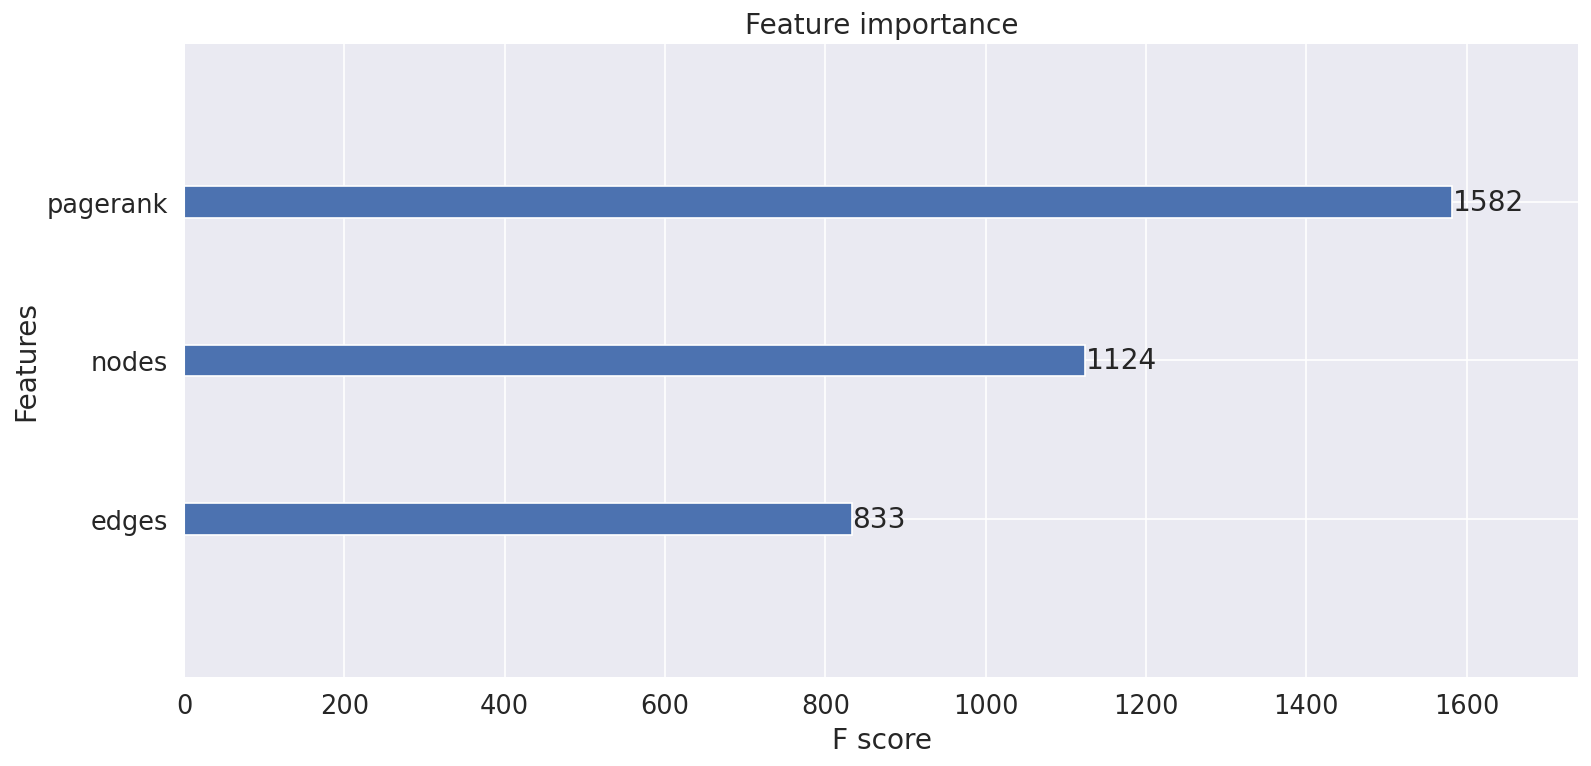

In [137]:
plot_importance(xgModel)
plt.show()

#### Plotting Confusion Matrix

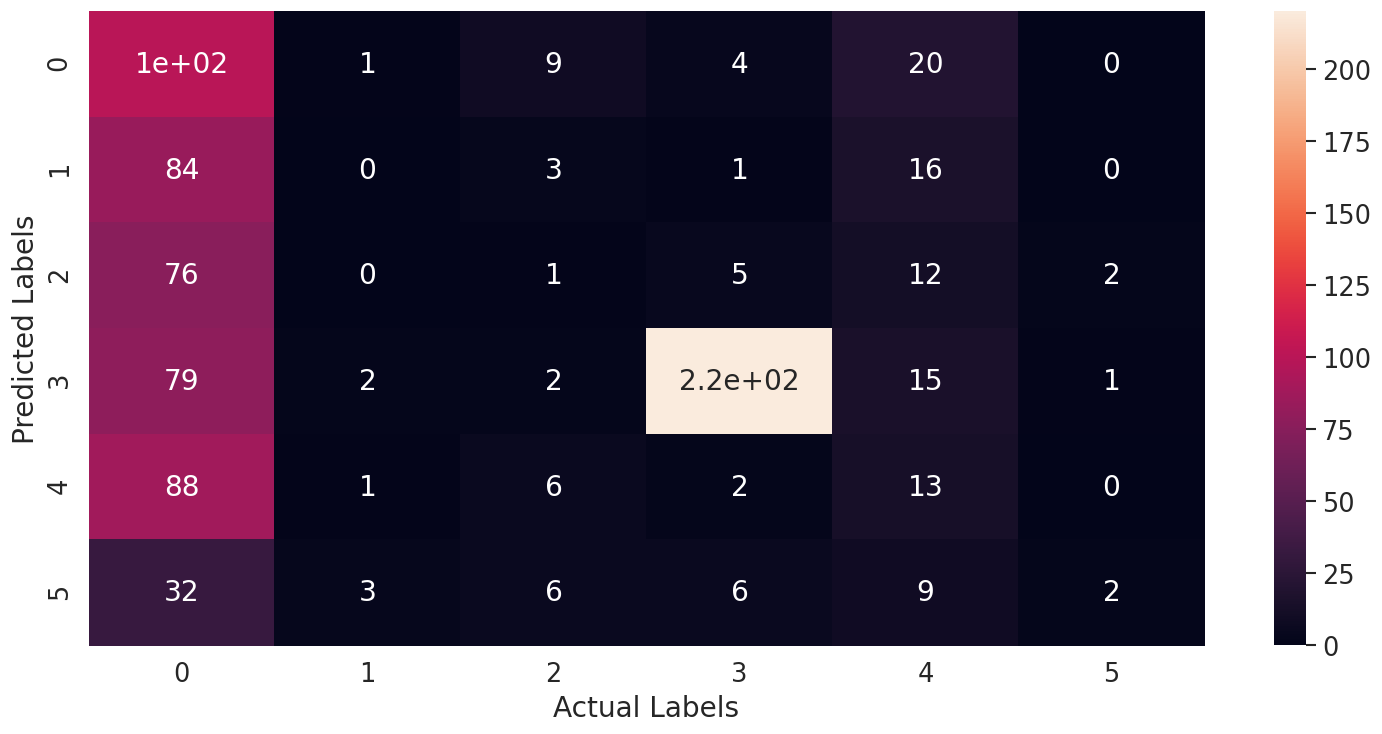

In [138]:
plot_confusion_mat(y_test, y_pred)

#### ROC Curve

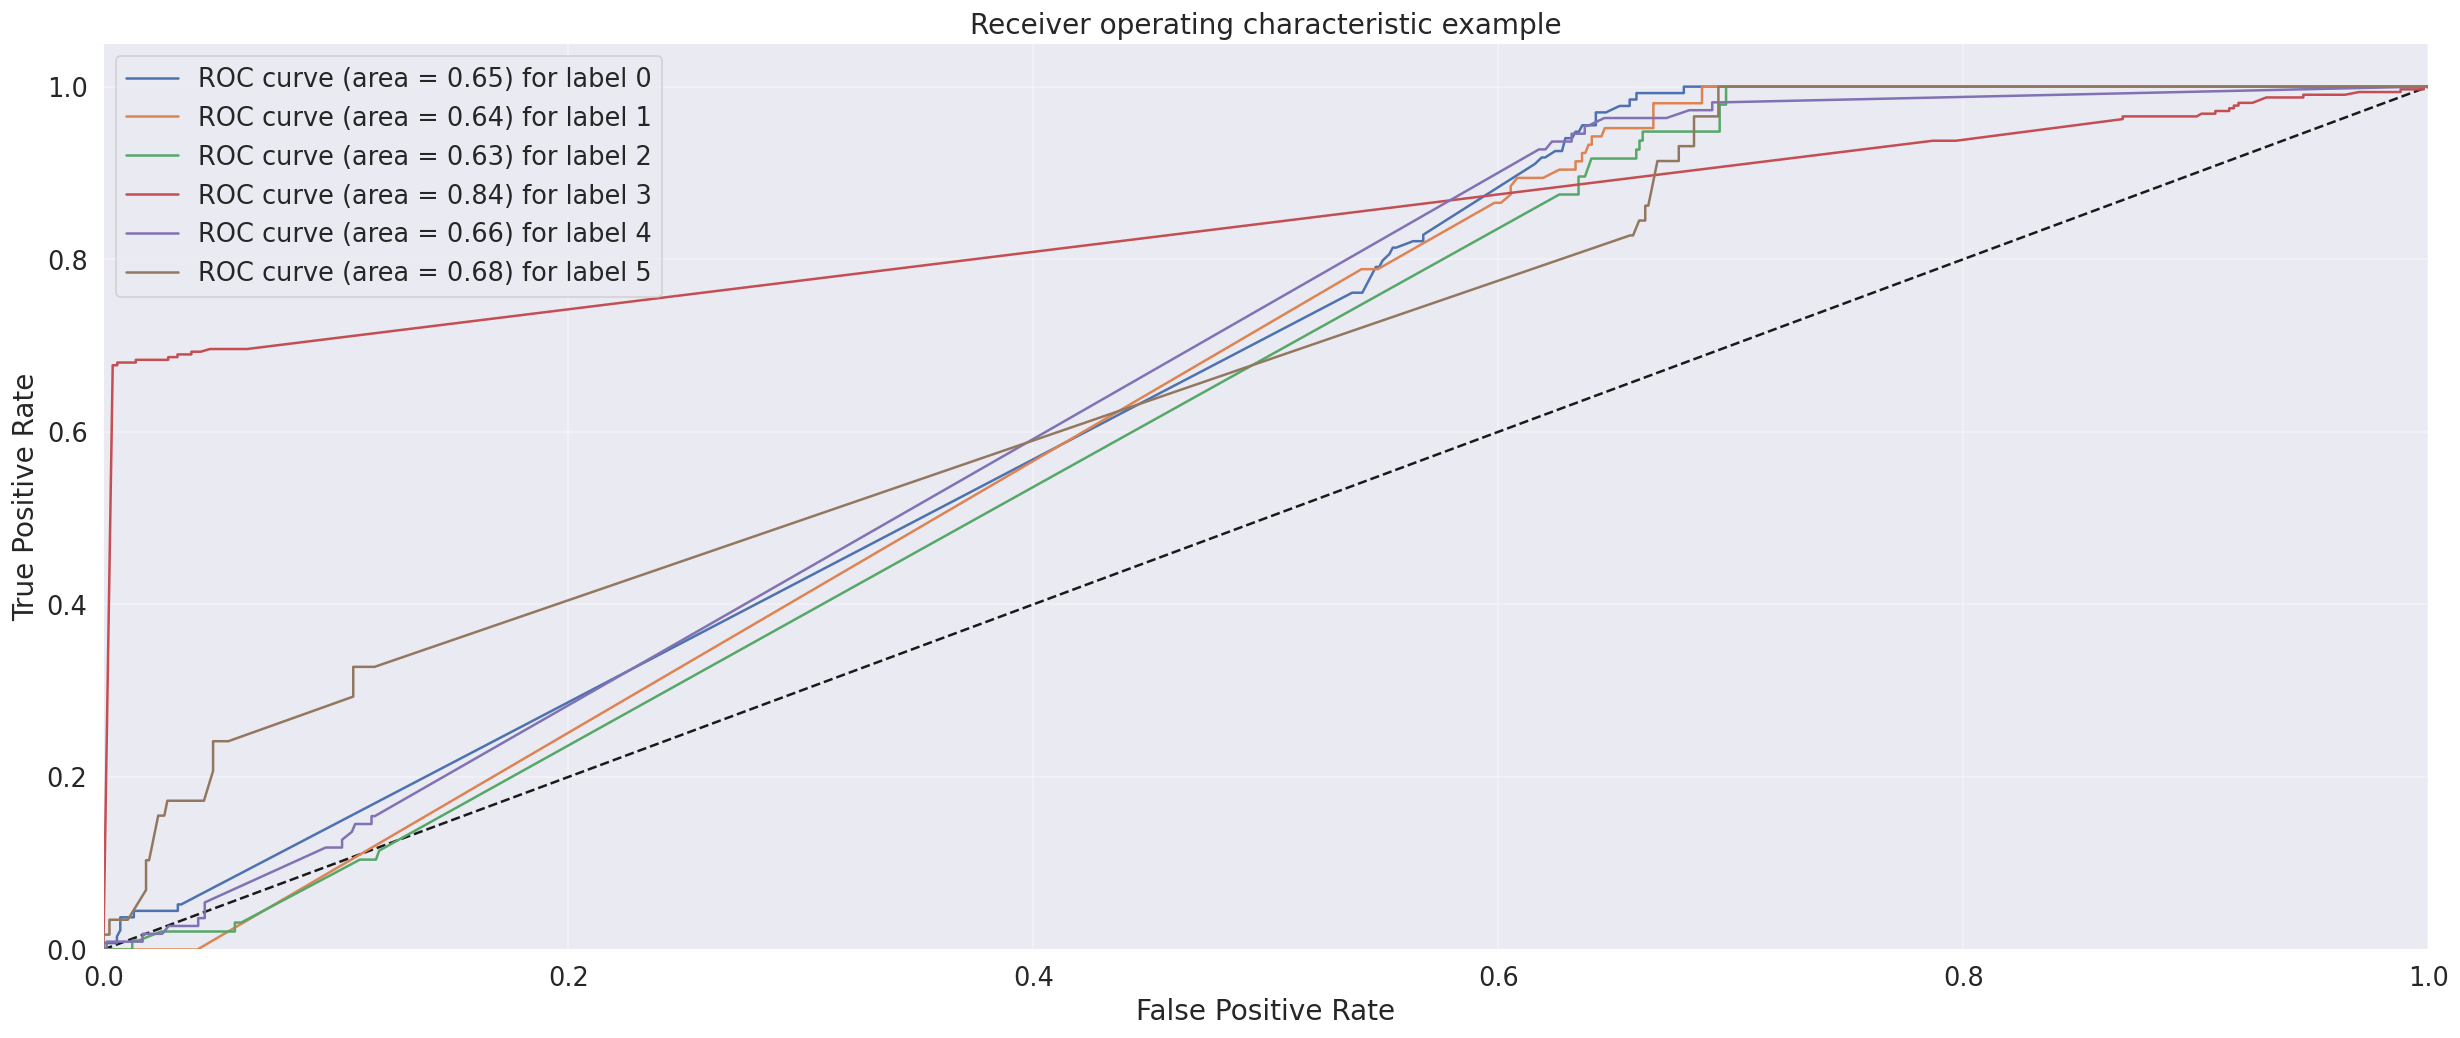

In [139]:
plot_multiclass_roc(xgModel, X_test, y_test, n_classes=6, figsize=(7, 5))

## Decision Tree on Liar-Liar and News category

In [0]:
clf1 = tree.DecisionTreeClassifier(criterion='gini', max_depth=6) 
clf1 = clf1.fit(X_train, y_train)

In [0]:
tree_pred = clf1.predict(X_test)

#### Plot for Feature Importance based on Gini Index

Text(0, 0.5, 'Feature Importance')

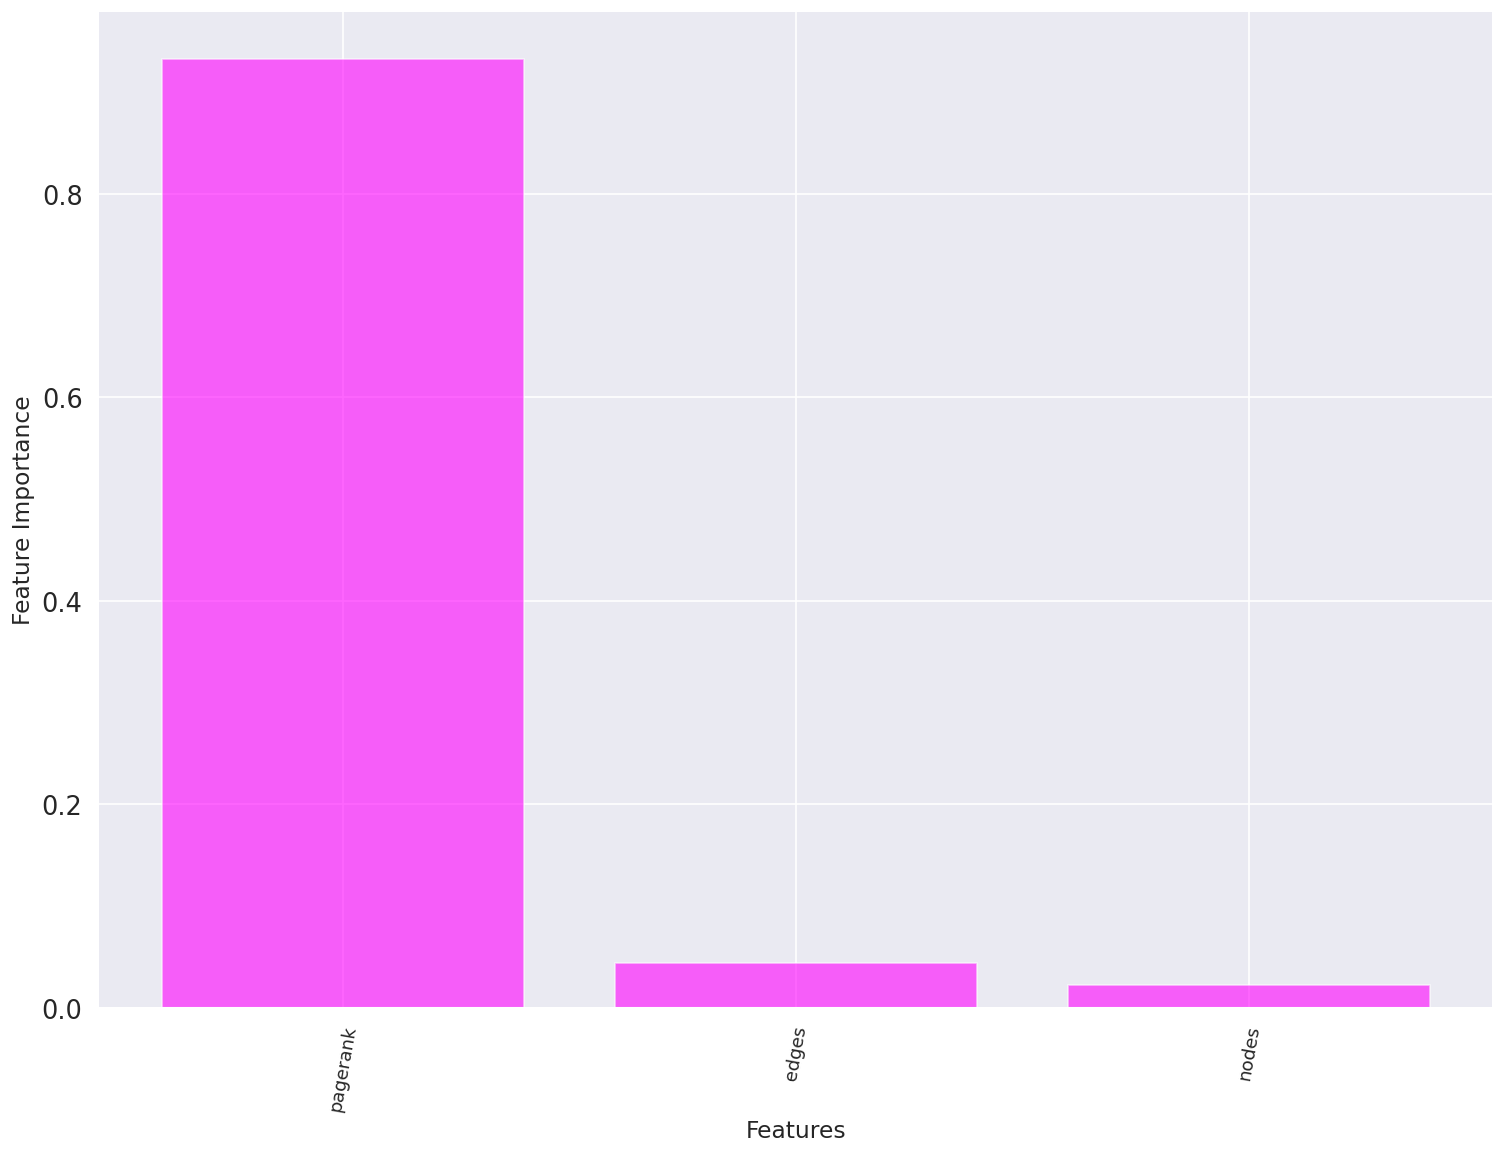

In [142]:
n_features = len(col_names_list)
fig = plt.figure(figsize=(15, 11))
fig.tight_layout()
plt.bar(range(n_features), clf1.feature_importances_, color="magenta", align="center", alpha=0.6)
plt.xticks(np.arange(n_features), col_names_list, rotation=80, fontsize=11)
plt.xlabel("Features", fontsize=14)
plt.ylabel("Feature Importance", fontsize=14)

In [0]:
tree_pred_labels = [np.argmax(p) for p in tree_pred]

In [144]:
accuracy = accuracy_score(y_test, tree_pred_labels)* 100.0
precision = metrics.precision_score(y_test, tree_pred_labels, average='weighted')*100.0
recall = metrics.recall_score(y_test, tree_pred_labels, average='weighted') * 100.0
f1score = metrics.f1_score(y_test, tree_pred_labels, average='weighted') * 100.0

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [0]:
val = {'Model': ['Decision Tree (on Liar-Liar/News Category)'], 'Accuracy': [accuracy], 'Precision': [precision], 'Recall': [recall], 'F1-Score': f1score}
outputDf6 = pd.DataFrame(val, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])
outputDf = pd.concat([outputDf, outputDf6], ignore_index=True, sort=False)

#### Overall Metrics DataFrame

In [146]:
outputDf.head(20)

Model   Accuracy  ...     Recall   F1-Score
0                 RandomForest (on Liar-Liar)  19.633943  ...  19.633943   6.444521
1                Decision Tree (on Liar-Liar)  19.633943  ...  19.633943   6.444521
2                      XGBoost (on Liar-Liar)  20.133111  ...  20.133111  11.448511
3                MultinomialNB (on Liar-Liar)  17.970050  ...  17.970050   8.394355
4   RandomForest (on Liar-Liar/News Category)  16.321559  ...  16.321559   4.580291
5        XGBoost (on Liar-Liar/News Category)  40.925700  ...  40.925700  38.623256
6  Decision Tree (on Liar-Liar/News Category)  16.321559  ...  16.321559   4.580291

[7 rows x 5 columns]

#### Plotting Confusion Matrix

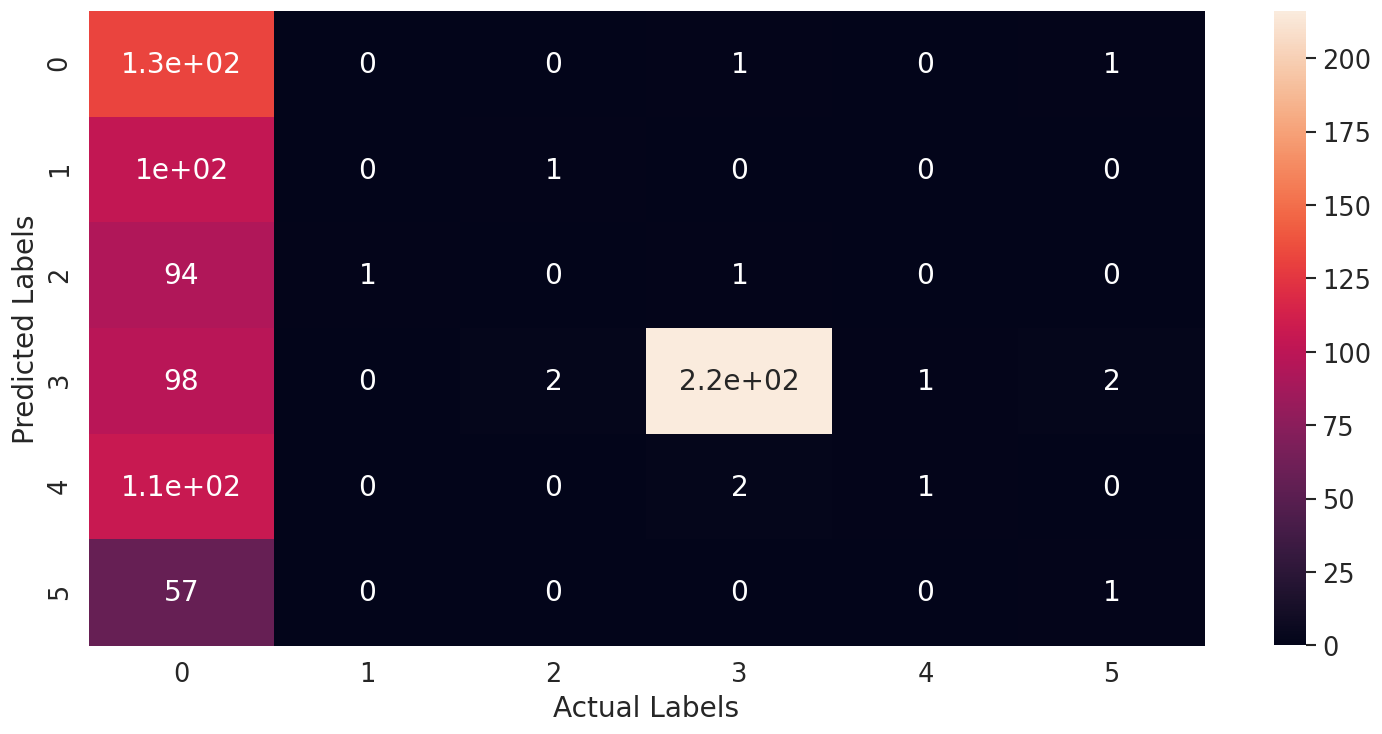

In [147]:
plot_confusion_mat(y_test, tree_pred)

#### ROC Curve

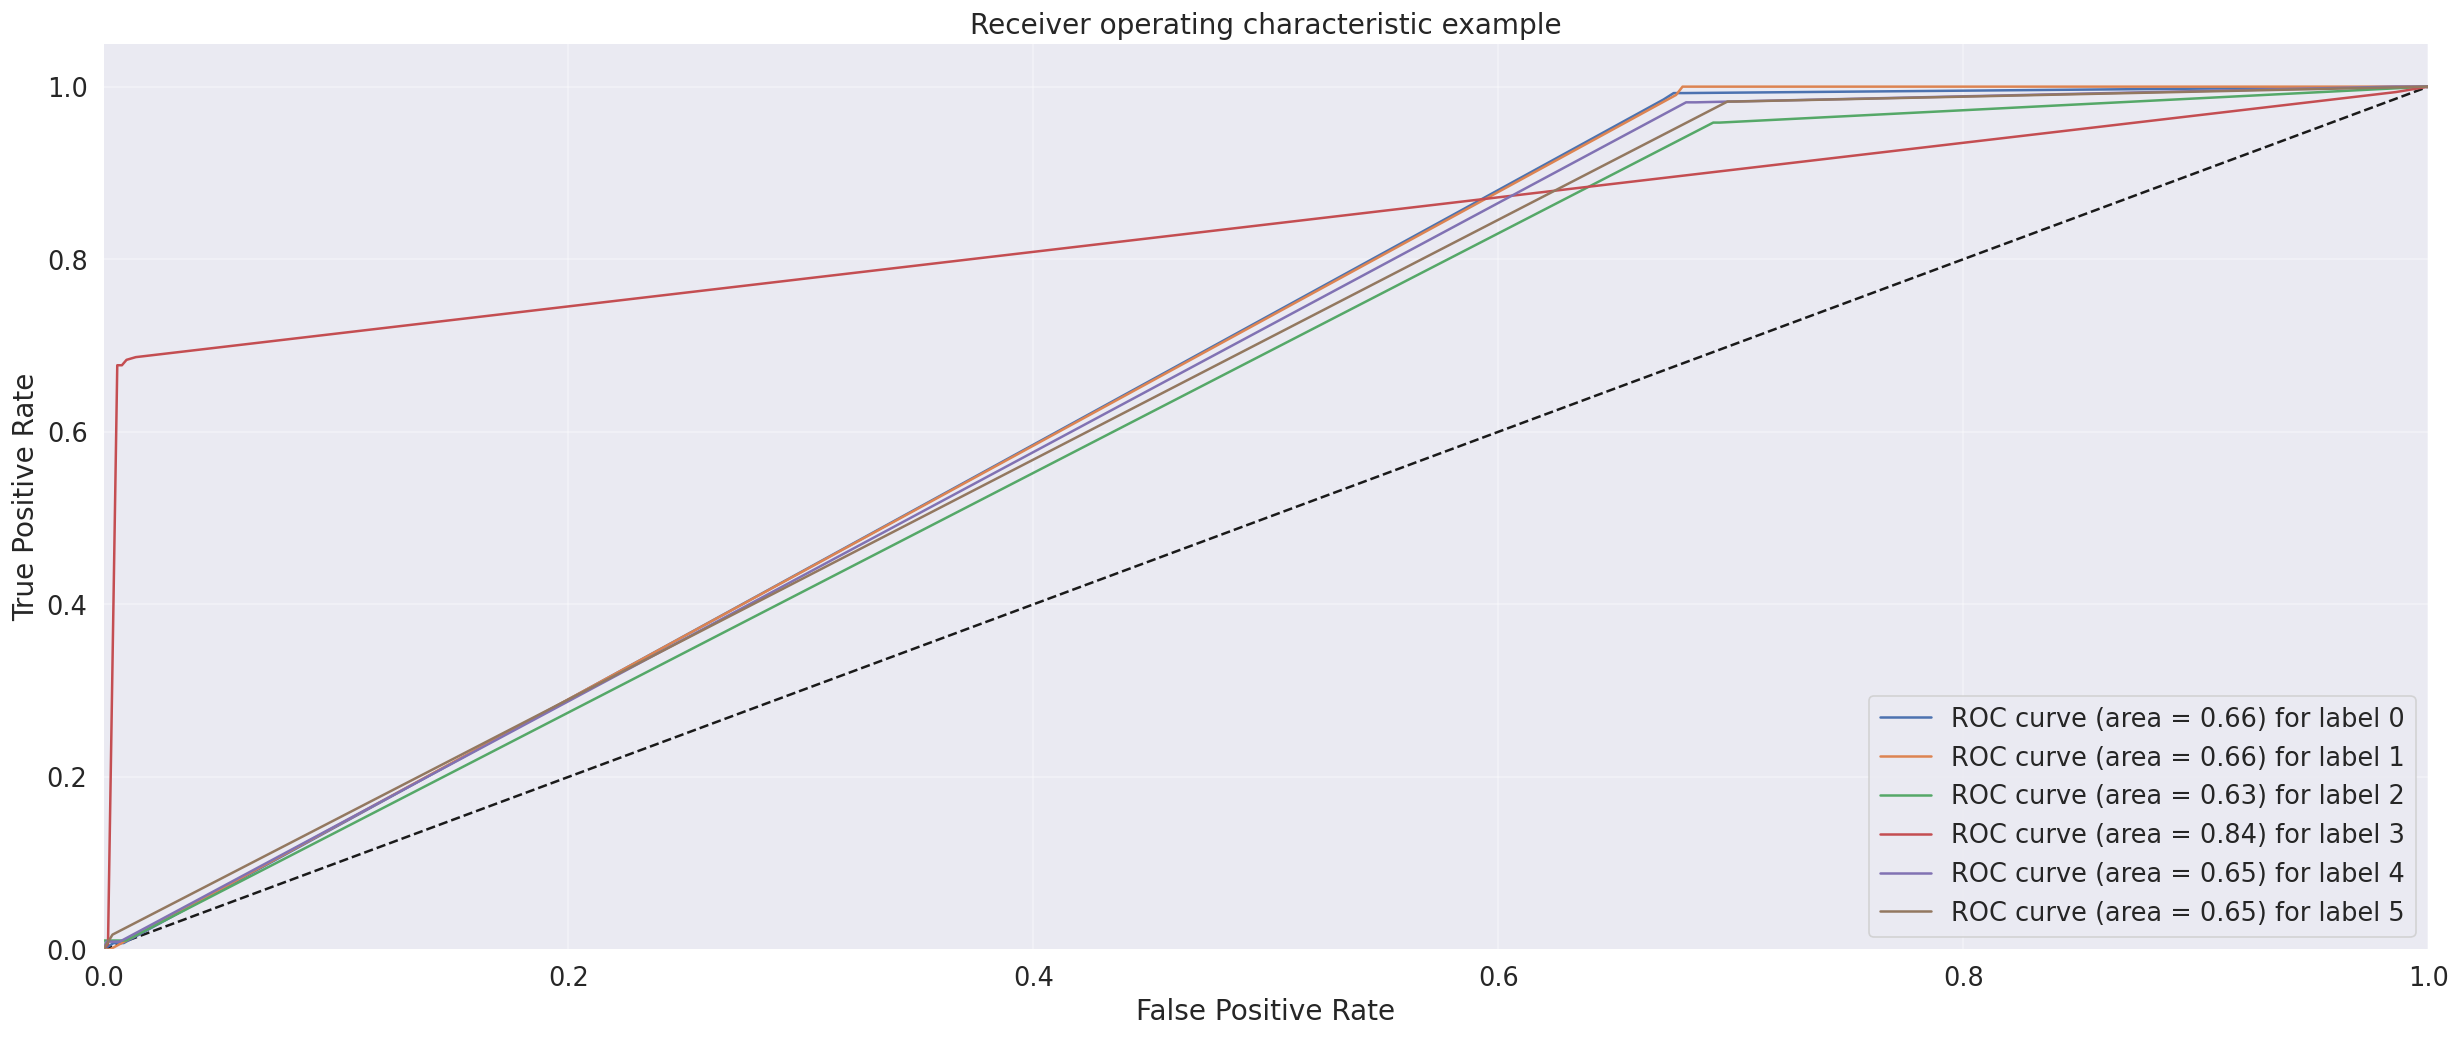

In [148]:
plot_multiclass_roc(clf1, X_test, y_test, n_classes=6, figsize=(7, 5))

## MultinomialNB on Liar-Liar and News Category

In [149]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [0]:
y_pred = clf.predict(X_test)

In [151]:
accuracy = accuracy_score(y_test, y_pred)* 100.0
precision = metrics.precision_score(y_test, y_pred, average='weighted')*100.0
recall = metrics.recall_score(y_test, y_pred, average='weighted') * 100.0
f1score = metrics.f1_score(y_test, y_pred, average='weighted') * 100.0

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### Overall Metrics DataFrame

In [152]:
val = {'Model': ['MultinomianNB (on Liar-Liar/News Category)'], 'Accuracy': [accuracy], 'Precision': [precision], 'Recall': [recall], 'F1-Score': f1score}
outputDf14 = pd.DataFrame(val, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])
outputDf = pd.concat([outputDf, outputDf14], ignore_index=True, sort=False)
outputDf.head(20)

Model   Accuracy  ...     Recall   F1-Score
0                 RandomForest (on Liar-Liar)  19.633943  ...  19.633943   6.444521
1                Decision Tree (on Liar-Liar)  19.633943  ...  19.633943   6.444521
2                      XGBoost (on Liar-Liar)  20.133111  ...  20.133111  11.448511
3                MultinomialNB (on Liar-Liar)  17.970050  ...  17.970050   8.394355
4   RandomForest (on Liar-Liar/News Category)  16.321559  ...  16.321559   4.580291
5        XGBoost (on Liar-Liar/News Category)  40.925700  ...  40.925700  38.623256
6  Decision Tree (on Liar-Liar/News Category)  16.321559  ...  16.321559   4.580291
7  MultinomianNB (on Liar-Liar/News Category)  38.855055  ...  38.855055  21.745197

[8 rows x 5 columns]

#### Plotting Confusion Matrix

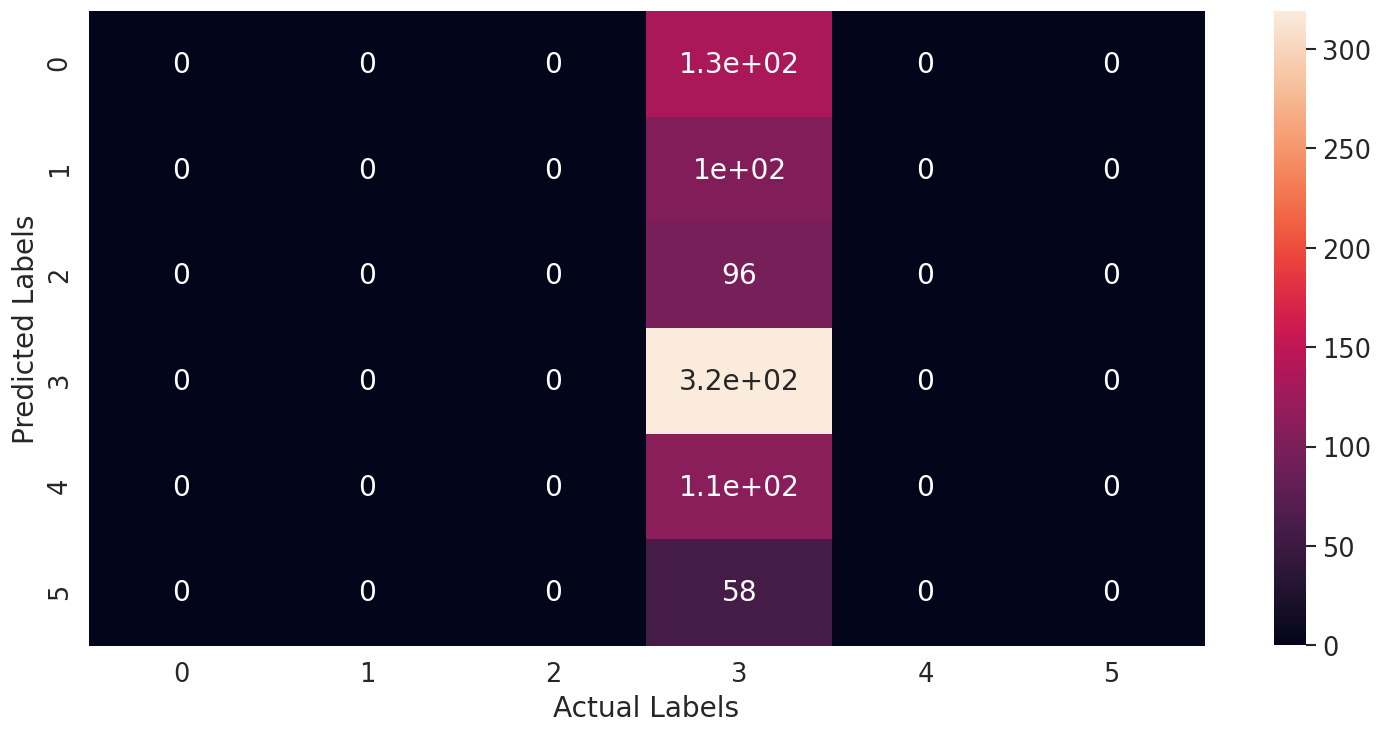

In [153]:
plot_confusion_mat(y_test, y_pred)

#### ROC Curve

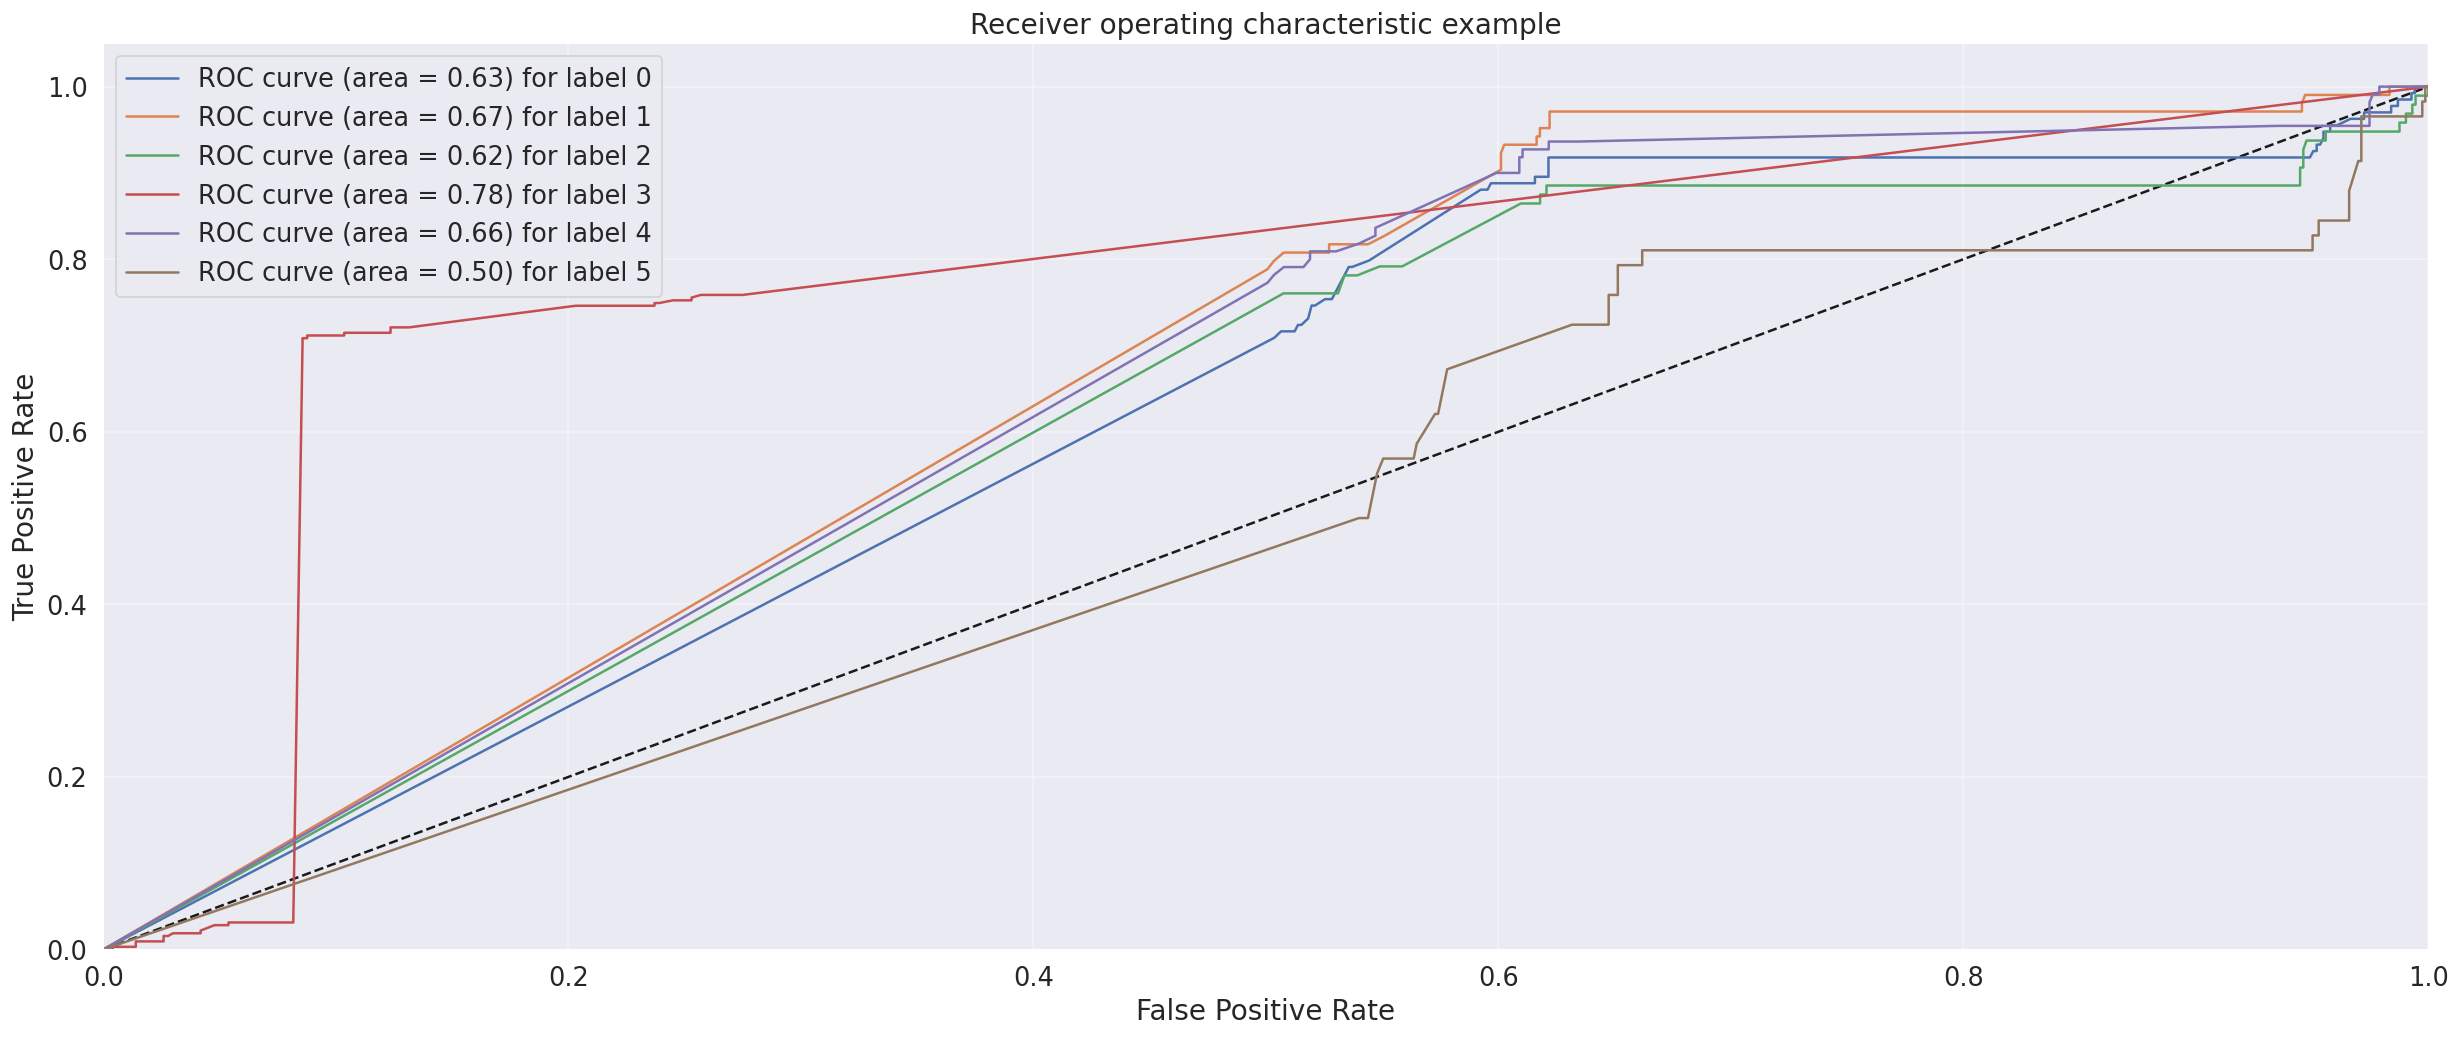

In [154]:
plot_multiclass_roc(clf, X_test, y_test, n_classes=6, figsize=(7, 5))

# Preprocessing columns to include as features in classification

In [155]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [0]:
from nltk.stem import WordNetLemmatizer 
def lemmatization(x):
  lemmatizer = WordNetLemmatizer() 
  text = lemmatizer.lemmatize(x)
  return text

In [0]:
import re
def removenumbers(x):
  text = re.sub(r'\d+', '', x)
  return text

In [0]:
def removespecialchars(x):
  x = str(x)
  x = x.lower()
  regex = re.compile('[^ a-zA-Z]')
  return regex.sub('',x)

In [0]:
def removewhitespace(x):
  text = x.rstrip()
  text = text.lstrip()
  return text

In [160]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [0]:
from nltk.tokenize import word_tokenize
from spacy.lang.en.stop_words import STOP_WORDS
stop_words = STOP_WORDS
def removestopwords(x):
  tokens = word_tokenize(x)
  result = [i for i in tokens if not i in stop_words]
  return result

In [0]:
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
stemmer= PorterStemmer()
def stemming(wordList):
  res = []
  for word in wordList:
    res.append(stemmer.stem(word))
  return res

In [0]:
def preprocess_text(x):
  text = removenumbers(x)
  text = removespecialchars(text)
  text = removewhitespace(text)
  wordList = removestopwords(text)
  text = ' '.join(wordList)
  res = lemmatization(text)
  return res

In [0]:
df_amalgamate['processed_statement'] = df_amalgamate['clean_statement'].apply(str).apply(preprocess_text)

In [0]:
df_amalgamate = df_amalgamate.drop(columns=['clean_statement'])

In [166]:
df_amalgamate.head(5)

labels  ...                                processed_statement
0        FALSE  ...  says annies list political group supports thir...
1    half-true  ...  decline coal start started natural gas took st...
2  mostly-true  ...  hillary clinton agrees john mccain voting geor...
3        FALSE  ...  health care reform legislation likely mandate ...
4    half-true  ...               economic turnaround started end term

[5 rows x 8 columns]

# Distillation

In [0]:
import gensim
from gensim.models import word2vec
from gensim.models.doc2vec import TaggedDocument
from gensim.models import Doc2Vec

from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.parsing.preprocessing import preprocess_string, strip_punctuation, strip_numeric

import math

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

## LDA

In [0]:
def get_word_tokens(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if len(token) > 3:
            result.append(token)
    return result

In [0]:
#train LDA model. Build a dictionary using train data set. Build a corpus using the Bag of words model. Using this corpus we build LDA model to provide the top 10 topics.
documents = df_amalgamate[['processed_statement']]
processed_docs = documents['processed_statement'].map(get_word_tokens)
dictionary = gensim.corpora.Dictionary(processed_docs)
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=10, id2word=dictionary, passes=2, workers=2)

In [0]:
# Bow Corpus
# [(14, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1)]
# Bow vector
# [(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1)]
# [(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1)]
# [(9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 2), (19, 1)]
# lda_model[bow_vector]
# [(1, 0.93999004)],
# [(0, 0.014288836), (1, 0.014290171), (2, 0.8713907), (3, 0.014287483), (4, 0.014292235), (5, 0.01428752), (6, 0.014289266), (7, 0.014289754), (8, 0.014288508), (9, 0.014295576)]

In [0]:
#Idnetify the topic number and the topic score for each text in test and train data set
def identify_topic_number_score(text):
    bow_vector = dictionary.doc2bow(get_word_tokens(text))
    topic_number , topic_score = sorted(lda_model[bow_vector], key=lambda tup: -1*tup[1])[0]
    return pd.Series([topic_number, topic_score])

In [172]:
lda_topics = lda_model.show_topics(num_words=10)
topics = []
filters = [lambda x: x.lower(), strip_punctuation, strip_numeric]
for topic in lda_topics:
    topics.append(preprocess_string(topic[1], filters))
print(topics)

[['trump', 'second', 'public', 'capitol', 'pension', 'reporter', 'teachers', 'states', 'state', 'year'], ['said', 'trump', 'secretary', 'veterans', 'idea', 'announced', 'pruitt', 'wednesday', 'people', 'care'], ['president', 'like', 'said', 'state', 'congress', 'wisconsin', 'florida', 'legal', 'says', 'trump'], ['obama', 'says', 'states', 'voted', 'money', 'change', 'government', 'trump', 'away', 'things'], ['students', 'come', 'november', 'rental', 'says', 'obama', 'year', 'immigration', 'history', 'wants'], ['state', 'said', 'stupid', 'amid', 'says', 'education', 'florida', 'percent', 'unemployment', 'high'], ['school', 'says', 'trump', 'close', 'chicken', 'people', 'house', 'million', 'schools', 'washington'], ['said', 'trump', 'news', 'sinclair', 'country', 'time', 'state', 'group', 'according', 'want'], ['think', 'says', 'delivery', 'supporters', 'president', 'said', 'year', 'million', 'republican', 'people'], ['state', 'said', 'plan', 'federal', 'scott', 'raise', 'bill', 'rights'

In [173]:
df_amalgamate.shape

(4101, 8)

In [174]:
#topic modelling for train data
df_amalgamate[['topic_number','topic_score']] = df_amalgamate.apply(lambda row: identify_topic_number_score(row['processed_statement']), axis=1)
df_amalgamate.head(5)

labels         speaker  ... topic_number  topic_score
0        FALSE    dwayne-bohac  ...          4.0     0.652457
1    half-true  scott-surovell  ...          5.0     0.712544
2  mostly-true    barack-obama  ...          7.0     0.460997
3        FALSE    blog-posting  ...          8.0     0.477106
4    half-true   charlie-crist  ...          9.0     0.819981

[5 rows x 10 columns]

## Ranking

In [0]:
import collections
def find_top_10_speakers(df):
    top_10 = []
    frequency = collections.Counter(df['speaker'])
    values = frequency.most_common()
    for i in range(10):
        speaker_freq = {'speaker':values[i][0], 'frequency':values[i][1]}
        top_10.append(speaker_freq)
    return top_10

speaker_freq = pd.DataFrame(find_top_10_speakers(df_amalgamate))
# print("The top 10 speakers")
# speaker_freq

In [0]:
#assign speaker importance by taking log of frequency. For speakers not in this top 10 list I will assign least value of 1
def assign_speaker_rank(df):
    speakers = speaker_freq['speaker']
    frequency = speaker_freq['frequency']
    ranks = {}
    index = 0
    for i in speakers:
        ranks[i] = math.log(frequency[index])
        index += 1 
    speaker_rank = []
    for index,row in df.iterrows():
        if row['speaker'] not in ranks:
            speaker_rank.append(1)
        else:
            speaker_rank.append(ranks[row['speaker']])        
    return speaker_rank

In [177]:
#find speaker importance for train data
speaker_rank = assign_speaker_rank(df_amalgamate)
df_amalgamate['speaker_rank'] = speaker_rank
df_amalgamate.head(5)

labels         speaker  ... topic_score  speaker_rank
0        FALSE    dwayne-bohac  ...    0.652457      1.000000
1    half-true  scott-surovell  ...    0.712544      1.000000
2  mostly-true    barack-obama  ...    0.460997      4.983607
3        FALSE    blog-posting  ...    0.477106      1.000000
4    half-true   charlie-crist  ...    0.819981      1.000000

[5 rows x 11 columns]

## Sentiment Analysis

In [0]:
def sentiment_subjectivity(x):
  return TextBlob(x).sentiment[-1]

In [0]:
def sentiment_polarity(x):
  return TextBlob(x).sentiment[0]

In [0]:
df_amalgamate['sentiment_polarity'] = df_amalgamate['processed_statement'].apply(sentiment_polarity)

In [0]:
df_amalgamate['sentiment_subjectivity'] = df_amalgamate['processed_statement'].apply(sentiment_subjectivity)

In [182]:
df_amalgamate.head()

labels         speaker  ... sentiment_polarity  sentiment_subjectivity
0        FALSE    dwayne-bohac  ...                0.0                     0.1
1    half-true  scott-surovell  ...                0.1                     0.4
2  mostly-true    barack-obama  ...                0.0                     0.0
3        FALSE    blog-posting  ...                0.2                     0.9
4    half-true   charlie-crist  ...                0.2                     0.2

[5 rows x 13 columns]

In [0]:
with open(base_dir + '/Alternus_vera/FinalDataFrame.csv', 'a') as f:
  df_amalgamate.to_csv(f)

In [0]:
#df_amalgamate['pagerank'] = df_amalgamate['pagerank'].apply(lambda x: x*10)
df_amalgamate['topic_score'] = df_amalgamate['topic_score'].apply(lambda x: x*10)

In [0]:
df_amalgamate = df_amalgamate.astype({'edges': 'int32', 'pagerank': 'int32'})

In [0]:
X = df_amalgamate[['pagerank', 'edges', 'nodes', 'topic_number', 'topic_score', 'speaker_rank', 'sentiment_polarity', 'sentiment_subjectivity']]
y = df_amalgamate.labels_cat

In [0]:
scaler = MinMaxScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Correlation Plot for Features

In [0]:
numericDF2 = df_amalgamate[['pagerank', 'edges', 'nodes', 'topic_number', 'topic_score', 'speaker_rank', 'sentiment_polarity', 'sentiment_subjectivity']]

In [0]:
col_names_list = list(numericDF2.columns.values)

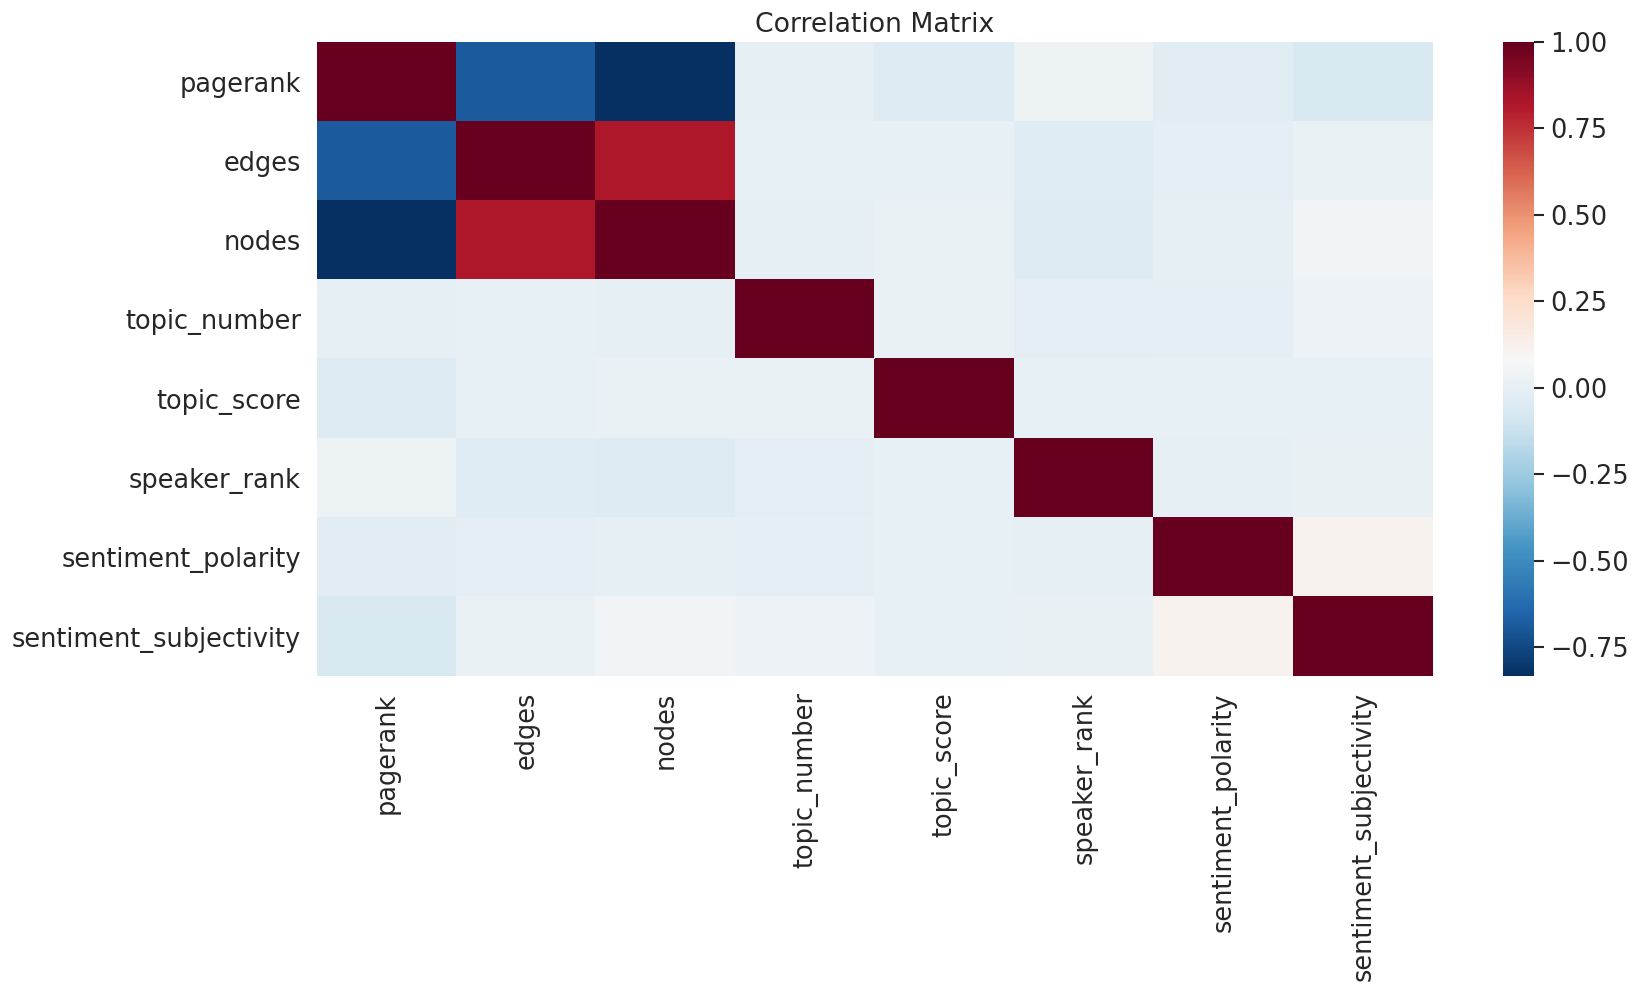

In [191]:
corr_numeric = numericDF2.corr()
sns.heatmap(corr_numeric, cbar=True, cmap="RdBu_r")
plt.title("Correlation Matrix", fontsize=16,)
plt.show()

# Applying Classifier models on amalgamated dataset - Liar Liar and NewsCat - After Distillation

## MultinomialNB after Distillation

In [192]:
clf = MultinomialNB()
clf.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [0]:
y_pred = clf.predict(X_test)

In [0]:
accuracy = accuracy_score(y_test, y_pred)* 100.0
precision = metrics.precision_score(y_test, y_pred, average='weighted')*100.0
recall = metrics.recall_score(y_test, y_pred, average='weighted') * 100.0
f1score = metrics.f1_score(y_test, y_pred, average='weighted') * 100.0

#### Overall Metrics DataFrame

In [195]:
val = {'Model': ['MultinomialNB (after distillation - on Liar-Liar/News Category)'], 'Accuracy': [accuracy], 'Precision': [precision], 'Recall': [recall], 'F1-Score': f1score}
outputDf11 = pd.DataFrame(val, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])
outputDf = pd.concat([outputDf, outputDf11], ignore_index=True, sort=False)
outputDf.head(20)

Model  ...   F1-Score
0                        RandomForest (on Liar-Liar)  ...   6.444521
1                       Decision Tree (on Liar-Liar)  ...   6.444521
2                             XGBoost (on Liar-Liar)  ...  11.448511
3                       MultinomialNB (on Liar-Liar)  ...   8.394355
4          RandomForest (on Liar-Liar/News Category)  ...   4.580291
5               XGBoost (on Liar-Liar/News Category)  ...  38.623256
6         Decision Tree (on Liar-Liar/News Category)  ...   4.580291
7         MultinomianNB (on Liar-Liar/News Category)  ...  21.745197
8  MultinomialNB (after distillation - on Liar-Li...  ...  22.571406

[9 rows x 5 columns]

#### Plotting Confusion Matrix

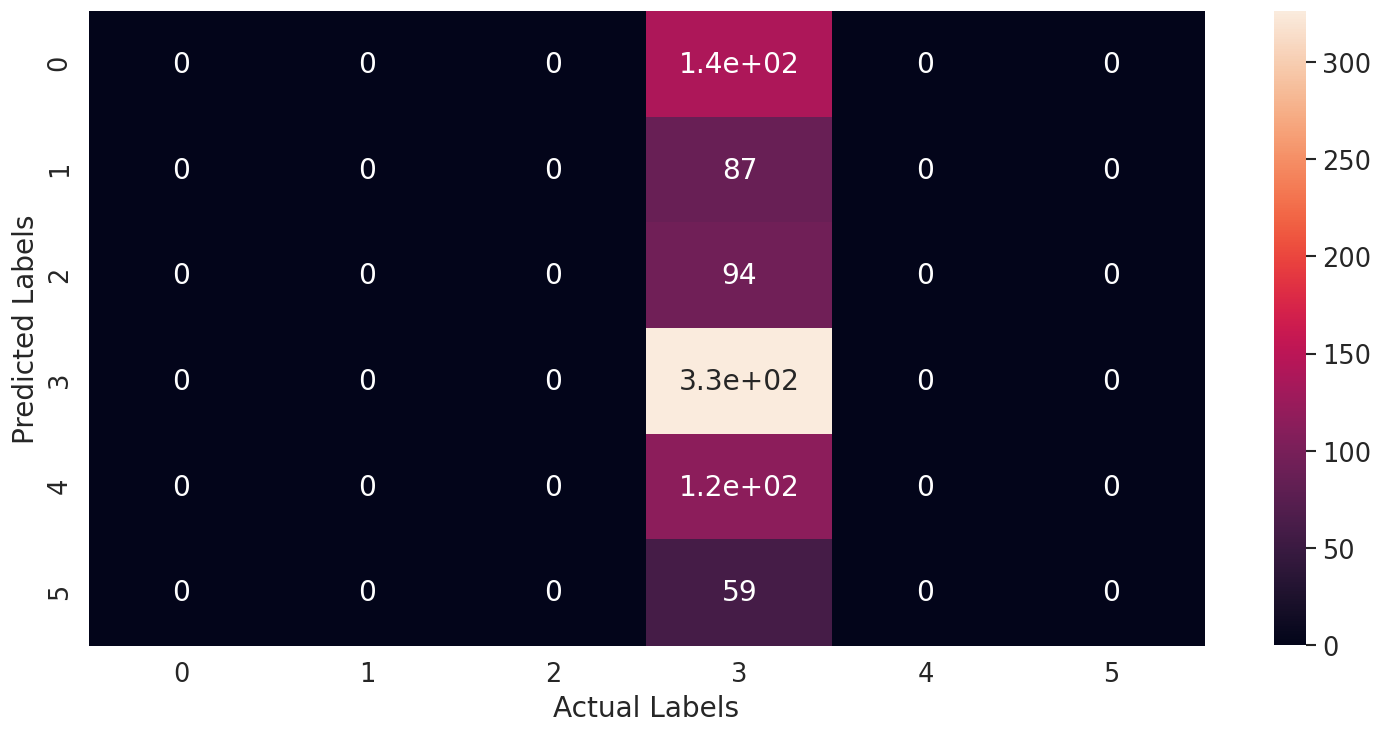

In [196]:
plot_confusion_mat(y_test, y_pred)

#### ROC Curve

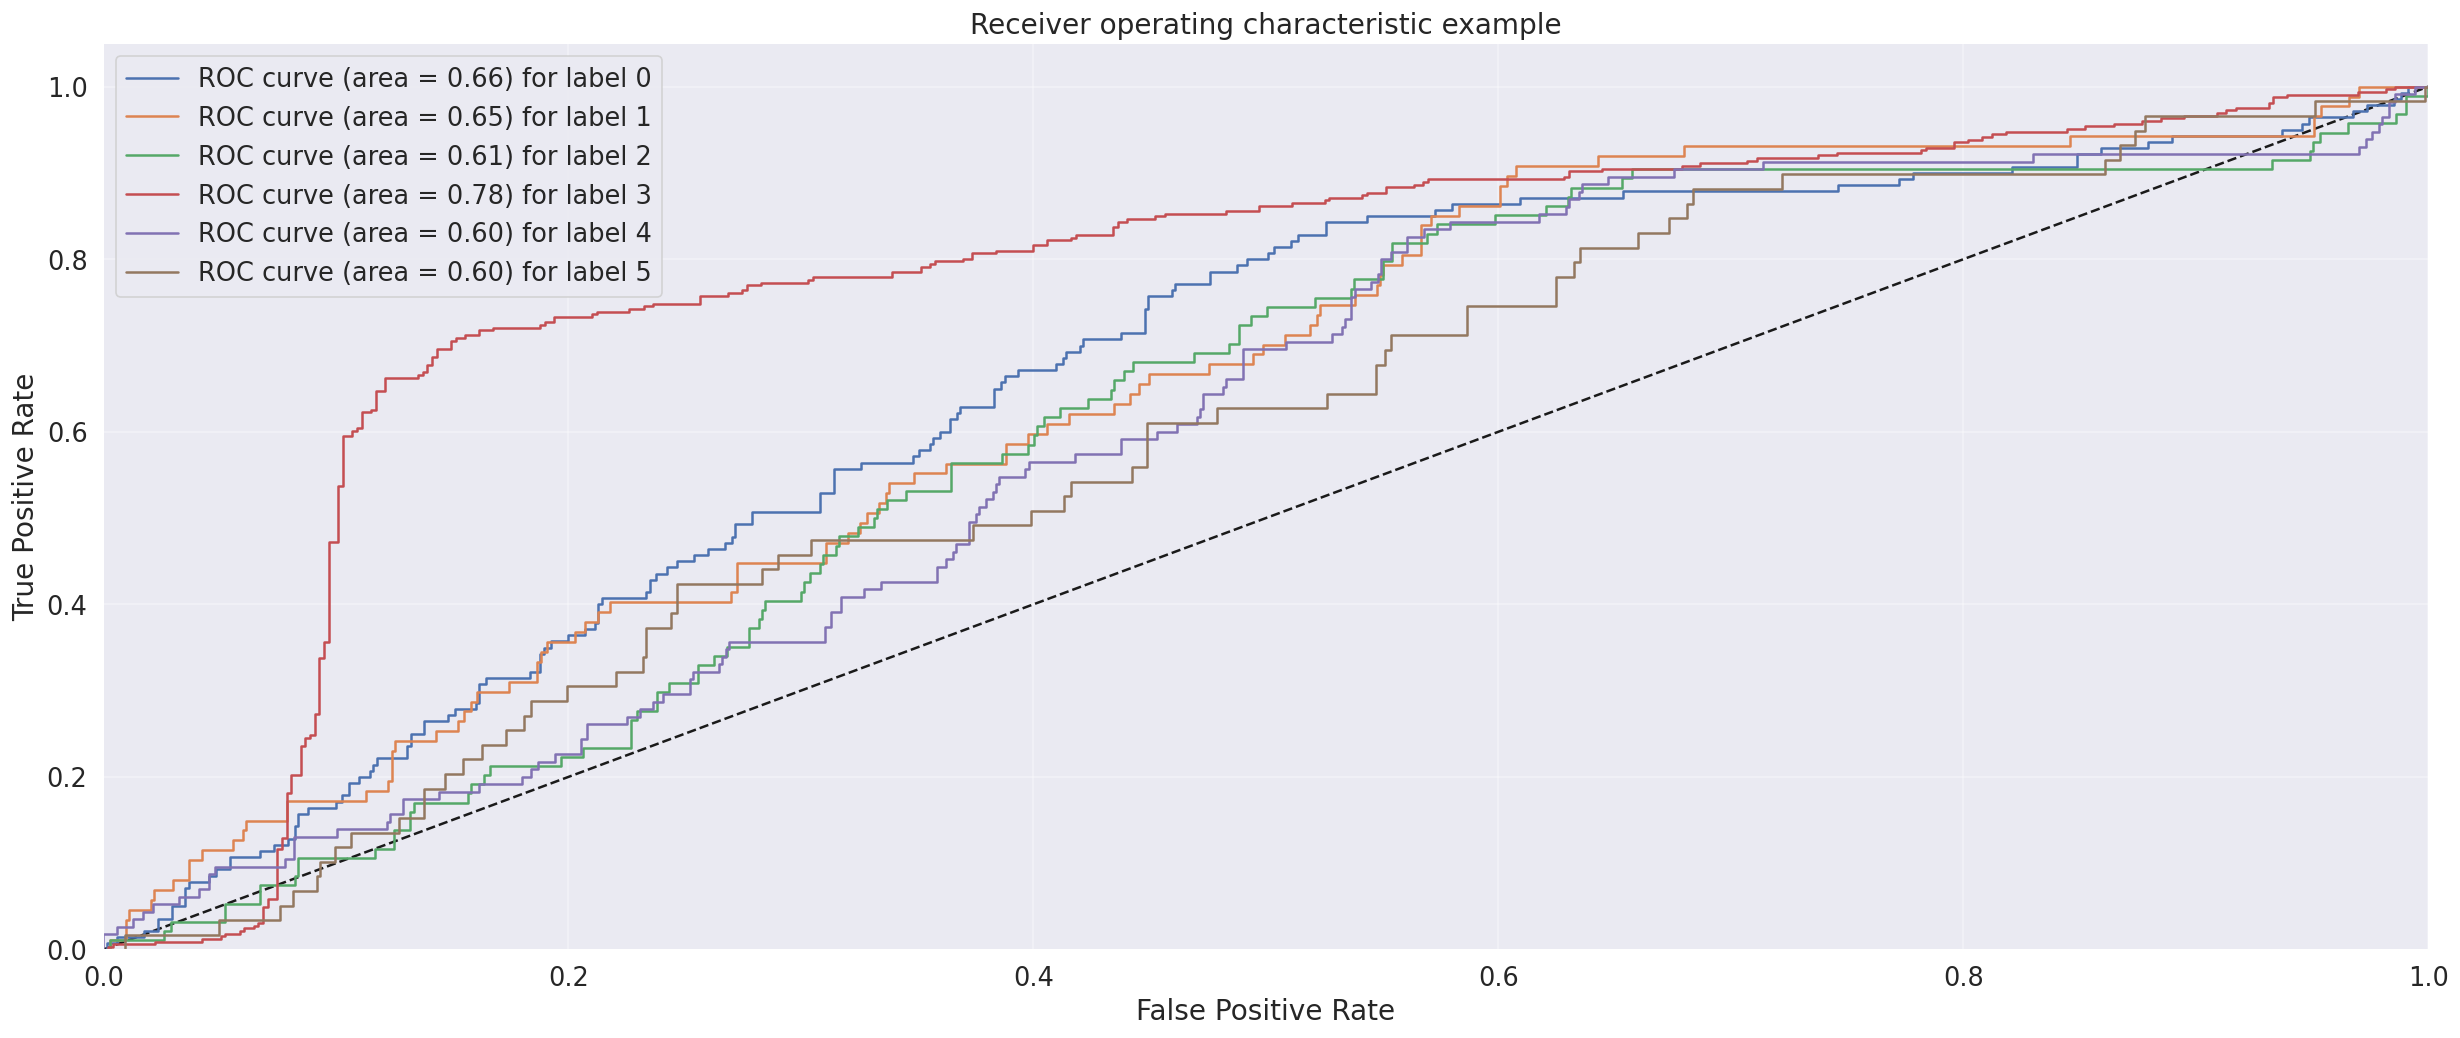

In [197]:
plot_multiclass_roc(clf, X_test, y_test, n_classes=6, figsize=(7, 5))

## Random Forest after Distillation

In [198]:
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [0]:
rf_predictions = rf_classifier.predict(X_test)  

In [0]:
rf_predictions_labels = [np.argmax(p) for p in rf_predictions]

In [0]:
accuracy = accuracy_score(y_test, rf_predictions_labels)* 100.0
precision = metrics.precision_score(y_test, rf_predictions_labels, average='weighted')*100.0
recall = metrics.recall_score(y_test, rf_predictions_labels, average='weighted') * 100.0
f1score = metrics.f1_score(y_test, rf_predictions_labels, average='weighted') * 100.0

#### Feature Importance

In [202]:
feature_imp = pd.Series(rf_classifier.feature_importances_, index=['pagerank', 'edges', 'nodes', 'topic_number', 'topic_score', 'speaker_rank', 'sentiment_polarity', 'sentiment_subjectivity']).sort_values(ascending=False)
feature_imp

topic_score               0.395218
edges                     0.108589
topic_number              0.108238
sentiment_subjectivity    0.099994
pagerank                  0.094682
sentiment_polarity        0.088255
nodes                     0.064581
speaker_rank              0.040442
dtype: float64

No handles with labels found to put in legend.


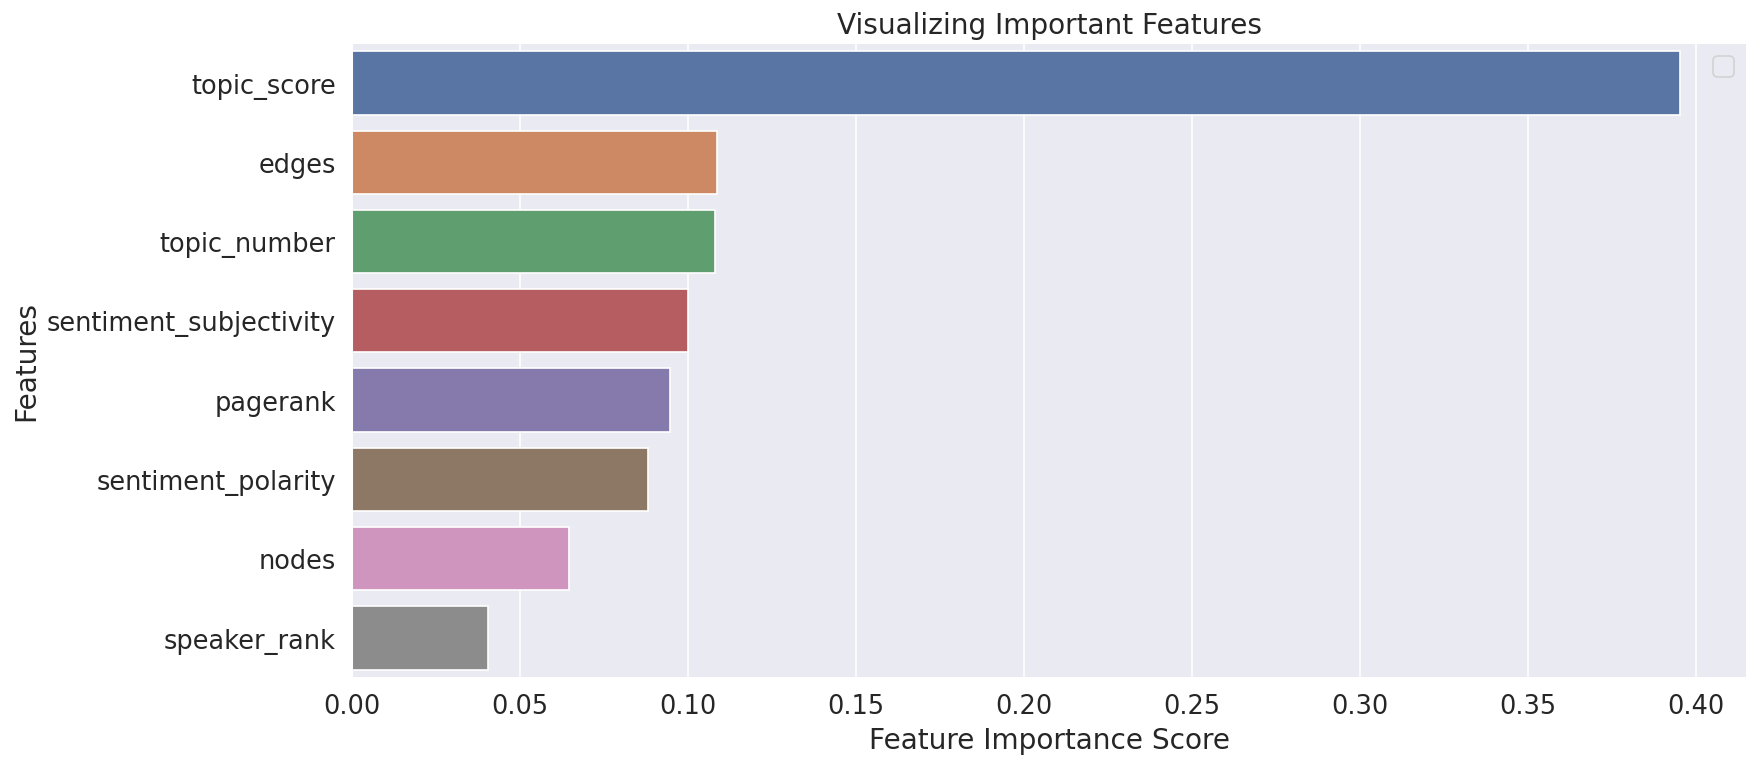

In [203]:
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.rcParams['figure.figsize'] = [15, 7]
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

#### Overall Metrics DataFrame

In [204]:
val = {'Model': ['RandomForest (after distillation - on Liar-Liar/News Category)'], 'Accuracy': [accuracy], 'Precision': [precision], 'Recall': [recall], 'F1-Score': f1score}
outputDf12 = pd.DataFrame(val, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])
outputDf = pd.concat([outputDf, outputDf12], ignore_index=True, sort=False)
outputDf.head(20)

Model  ...   F1-Score
0                        RandomForest (on Liar-Liar)  ...   6.444521
1                       Decision Tree (on Liar-Liar)  ...   6.444521
2                             XGBoost (on Liar-Liar)  ...  11.448511
3                       MultinomialNB (on Liar-Liar)  ...   8.394355
4          RandomForest (on Liar-Liar/News Category)  ...   4.580291
5               XGBoost (on Liar-Liar/News Category)  ...  38.623256
6         Decision Tree (on Liar-Liar/News Category)  ...   4.580291
7         MultinomianNB (on Liar-Liar/News Category)  ...  21.745197
8  MultinomialNB (after distillation - on Liar-Li...  ...  22.571406
9  RandomForest (after distillation - on Liar-Lia...  ...   4.968434

[10 rows x 5 columns]

#### Plotting Confusion Matrix

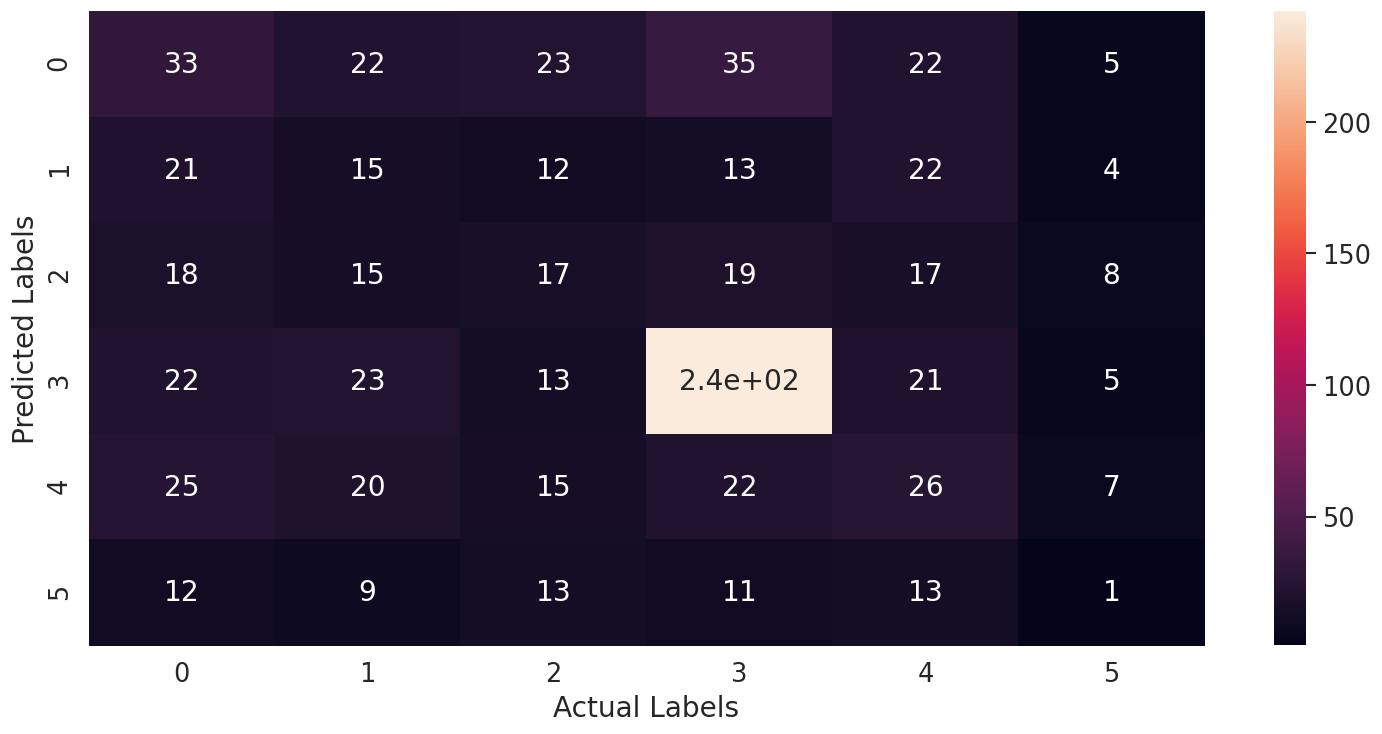

In [205]:
plot_confusion_mat(y_test, rf_predictions)

#### ROC Curve

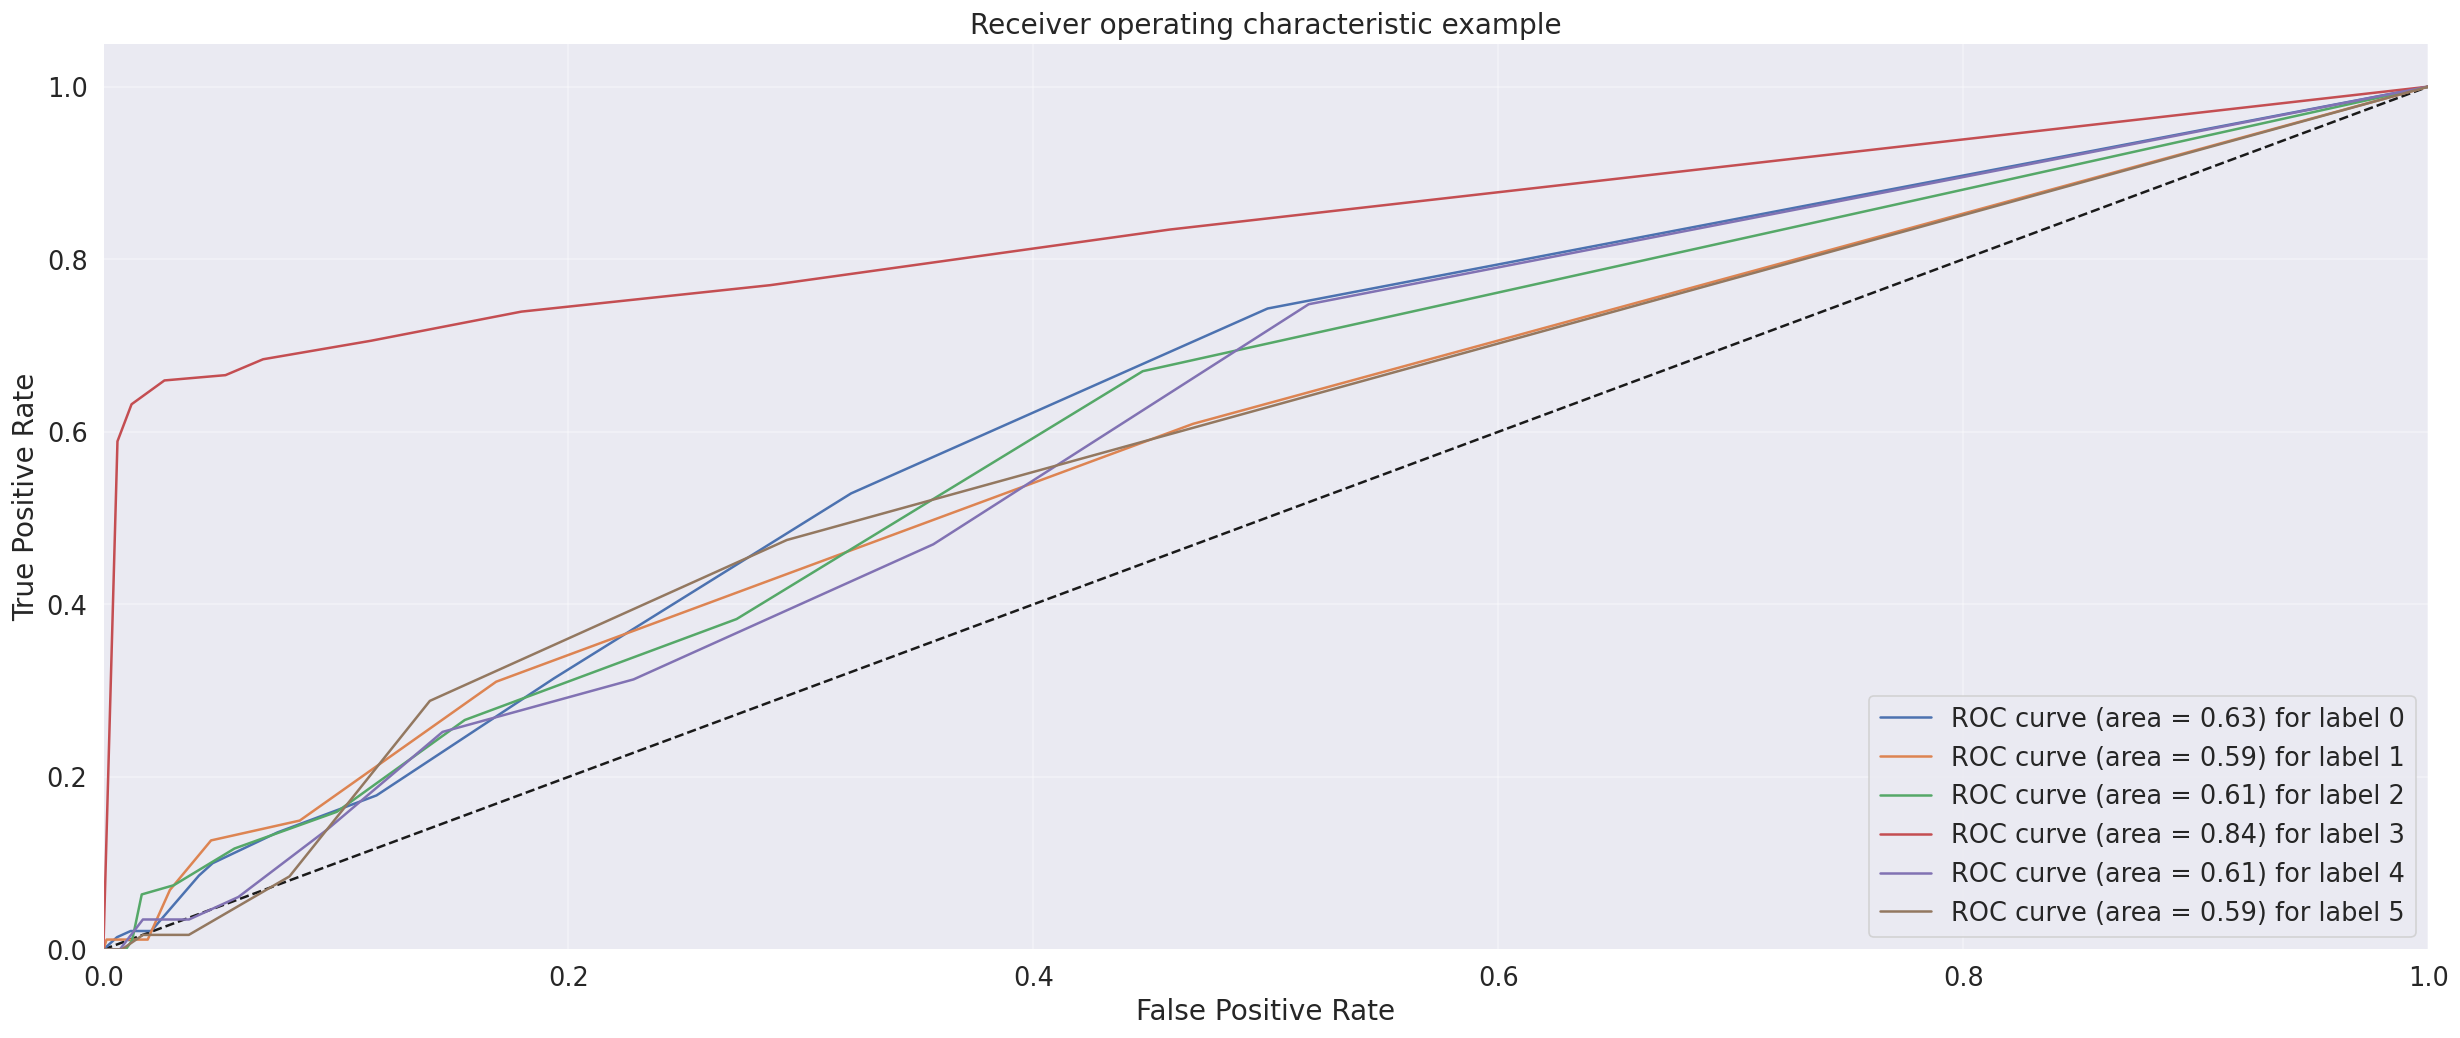

In [206]:
plot_multiclass_roc(rf_classifier, X_test, y_test, n_classes=6, figsize=(7, 5))

## Decision Tree after Distillation

In [0]:
clf1 = tree.DecisionTreeClassifier(criterion='gini', max_depth=6) 
clf1 = clf1.fit(X_train, y_train)

In [0]:
tree_pred = clf1.predict(X_test)

#### Plot for Feature Importance based on Gini Index

Text(0, 0.5, 'Feature Importance')

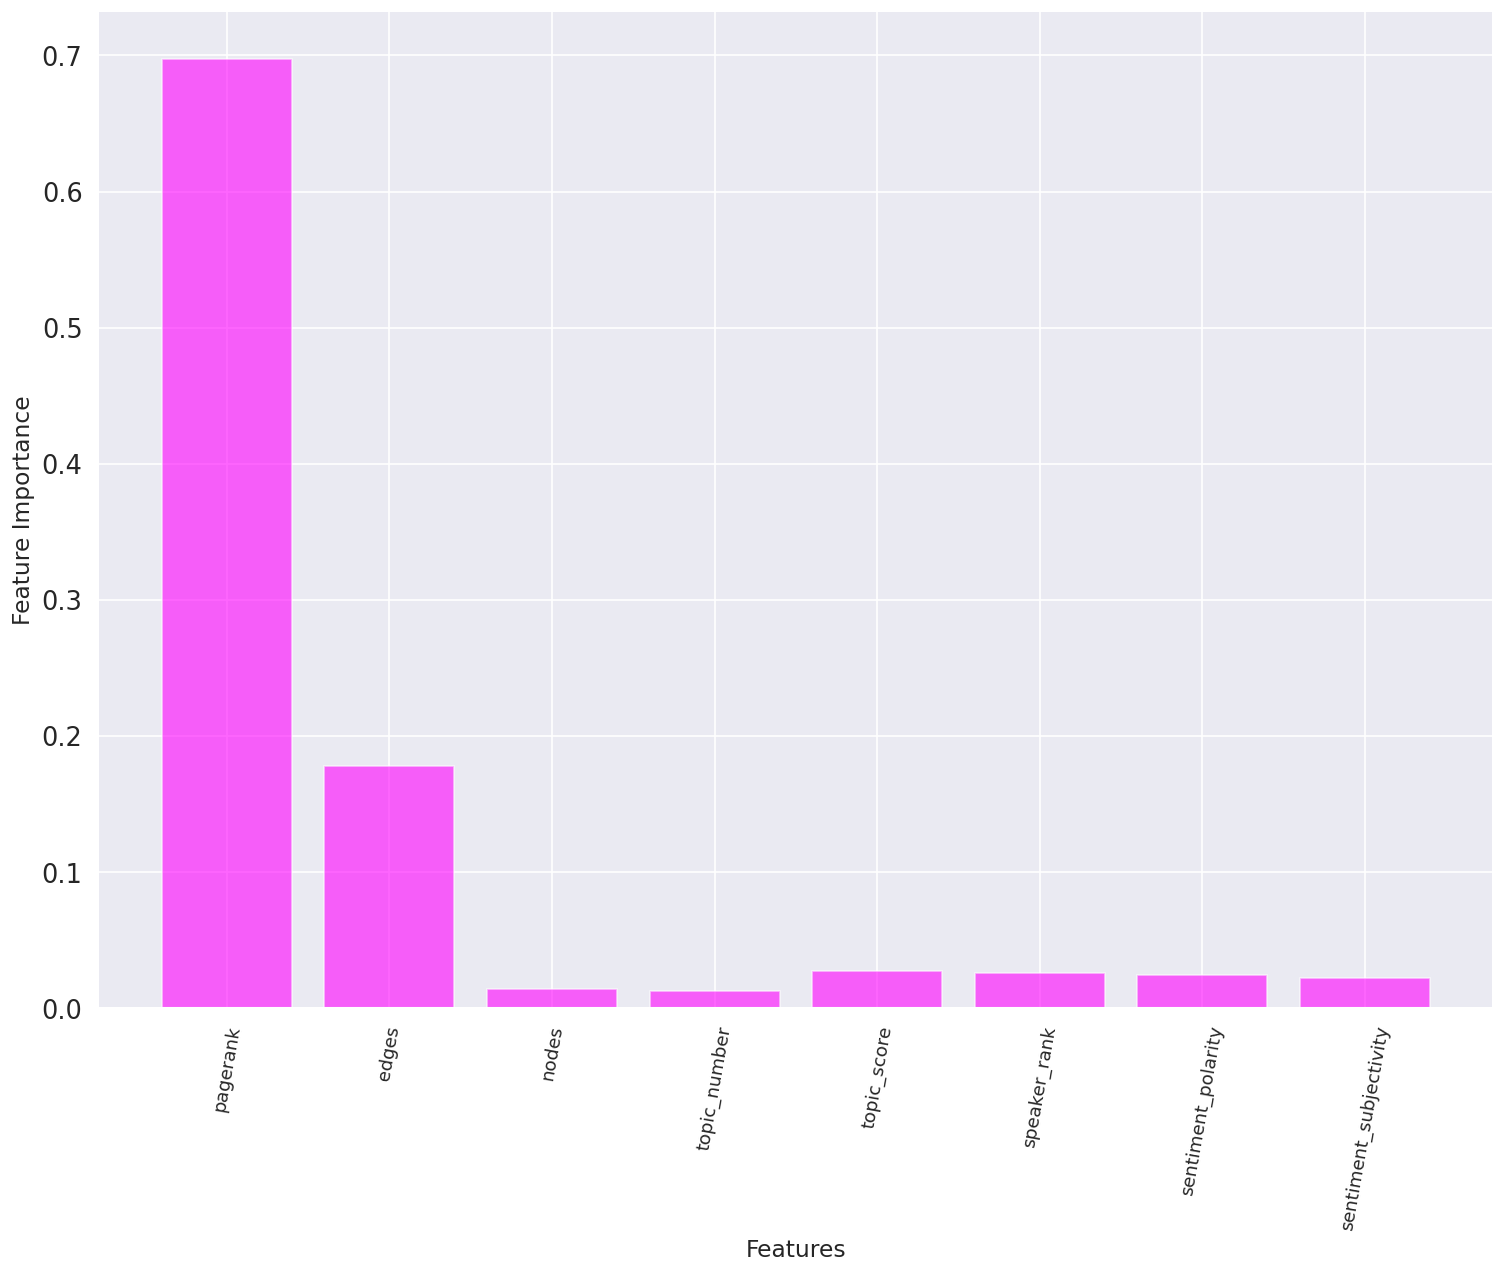

In [209]:
n_features = len(col_names_list)
fig = plt.figure(figsize=(15, 11))
fig.tight_layout()
plt.bar(range(n_features), clf1.feature_importances_, color="magenta", align="center", alpha=0.6)
plt.xticks(np.arange(n_features), col_names_list, rotation=80, fontsize=11)
plt.xlabel("Features", fontsize=14)
plt.ylabel("Feature Importance", fontsize=14)

In [0]:
tree_pred_labels = [np.argmax(p) for p in tree_pred]

In [0]:
accuracy = accuracy_score(y_test, tree_pred_labels)* 100.0
precision = metrics.precision_score(y_test, tree_pred_labels, average='weighted')*100.0
recall = metrics.recall_score(y_test, tree_pred_labels, average='weighted') * 100.0
f1score = metrics.f1_score(y_test, tree_pred_labels, average='weighted') * 100.0

In [0]:
val = {'Model': ['Decision Tree (after Distillation - on Liar-Liar/News Category)'], 'Accuracy': [accuracy], 'Precision': [precision], 'Recall': [recall], 'F1-Score': f1score}
outputDf13 = pd.DataFrame(val, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])
outputDf = pd.concat([outputDf, outputDf13], ignore_index=True, sort=False)

#### Overall Metrics DataFrame

In [213]:
outputDf.head(20)

Model  ...   F1-Score
0                         RandomForest (on Liar-Liar)  ...   6.444521
1                        Decision Tree (on Liar-Liar)  ...   6.444521
2                              XGBoost (on Liar-Liar)  ...  11.448511
3                        MultinomialNB (on Liar-Liar)  ...   8.394355
4           RandomForest (on Liar-Liar/News Category)  ...   4.580291
5                XGBoost (on Liar-Liar/News Category)  ...  38.623256
6          Decision Tree (on Liar-Liar/News Category)  ...   4.580291
7          MultinomianNB (on Liar-Liar/News Category)  ...  21.745197
8   MultinomialNB (after distillation - on Liar-Li...  ...  22.571406
9   RandomForest (after distillation - on Liar-Lia...  ...   4.968434
10  Decision Tree (after Distillation - on Liar-Li...  ...   4.968434

[11 rows x 5 columns]

#### Plotting Confusion Matrix

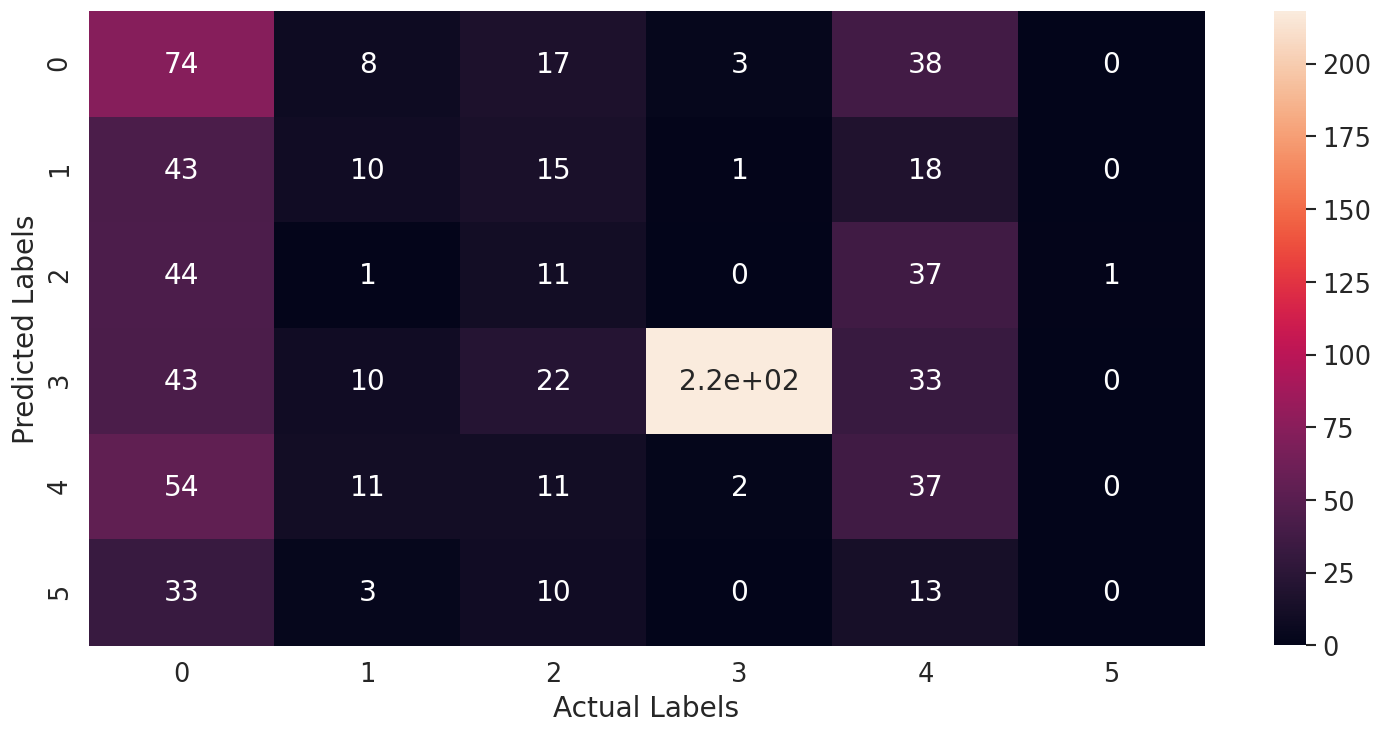

In [214]:
plot_confusion_mat(y_test, tree_pred)

#### ROC Curve

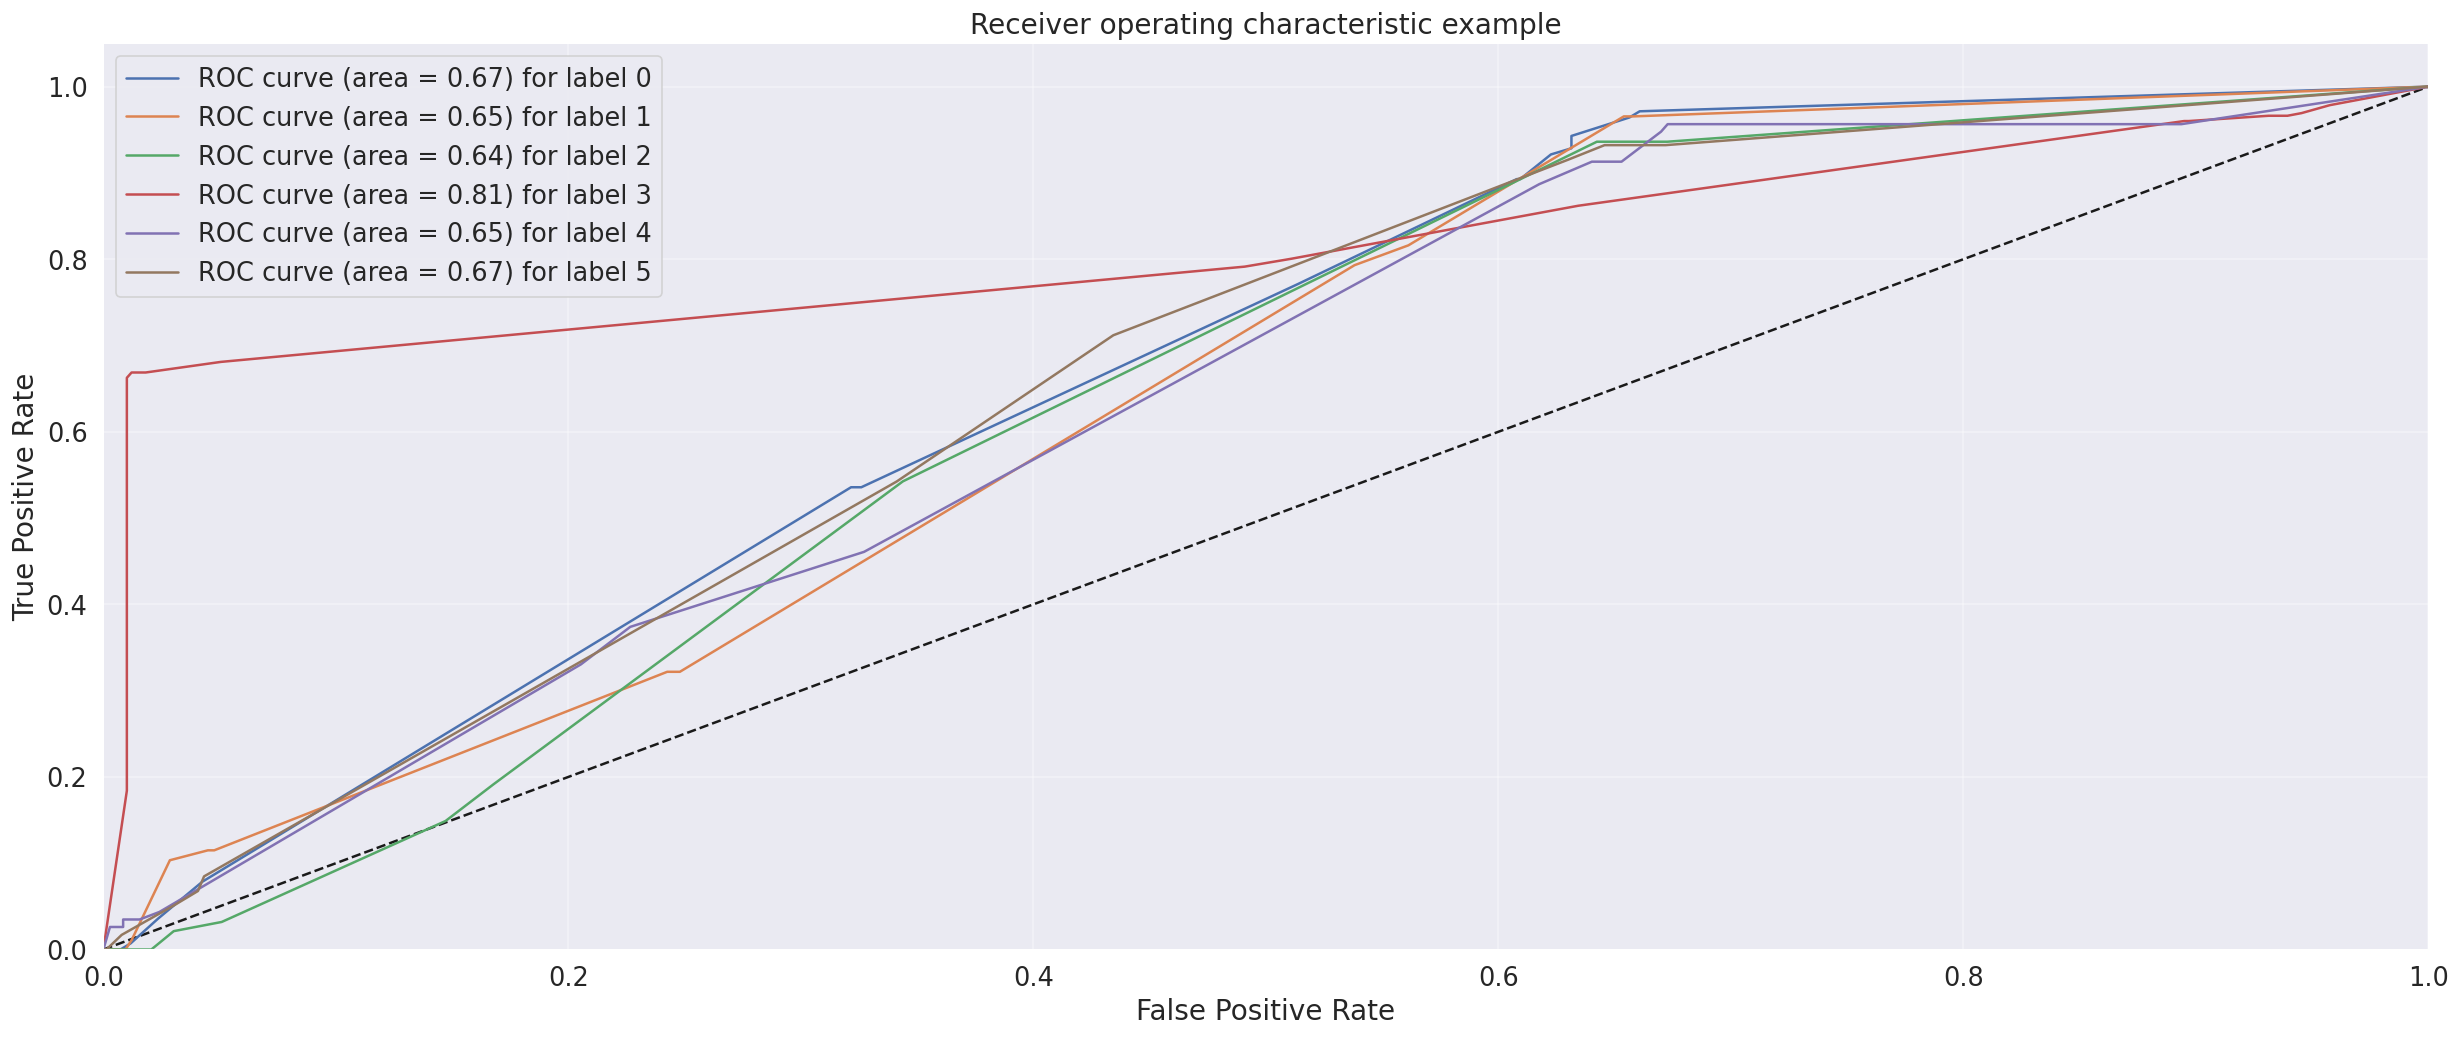

In [215]:
plot_multiclass_roc(clf1, X_test, y_test, n_classes=6, figsize=(7, 5))

## XGBoost After Distillation

In [216]:
xgModelFinal = XGBClassifier()
xgModelFinal.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='multi:softprob', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

In [0]:
y_pred = xgModelFinal.predict(X_test)
xgb_predictions_labels = [round(value) for value in y_pred]

In [0]:
import pickle
#write to file
with open('/content/gdrive/My Drive/MLSpring2020/the_expendables_AirQuality_Traffic/node.pkl', 'wb') as f:
    pickle.dump(xgModelFinal, f)

#read from file
with open('/content/gdrive/My Drive/MLSpring2020/the_expendables_AirQuality_Traffic/node.pkl', 'rb') as f:
    xg = pickle.load(f)

In [0]:
ypickle = xg.predict(X)
ypickleList = ypickle.tolist()
labels = list(le.inverse_transform(ypickleList))

In [0]:
df_amalgamate['NodeRankClass'] = labels

In [0]:
dfCopy = df_amalgamate.copy()

In [0]:
dfCopy = dfCopy['NodeRankClass']

In [223]:
dfCopy.shape

(4101,)

In [0]:
dfCopy = dfCopy.head(3000)

In [225]:
dfCopy.shape

(3000,)

In [0]:
# with open(base_dir + '/Alternus_vera/Classification.csv', 'a') as f:
#   dfCopy.to_csv(f)

In [0]:
accuracy = accuracy_score(y_test, xgb_predictions_labels)* 100.0
precision = metrics.precision_score(y_test, xgb_predictions_labels, average='weighted')*100.0
recall = metrics.recall_score(y_test, xgb_predictions_labels, average='weighted') * 100.0
f1score = metrics.f1_score(y_test, xgb_predictions_labels, average='weighted') * 100.0

#### Feature Importance

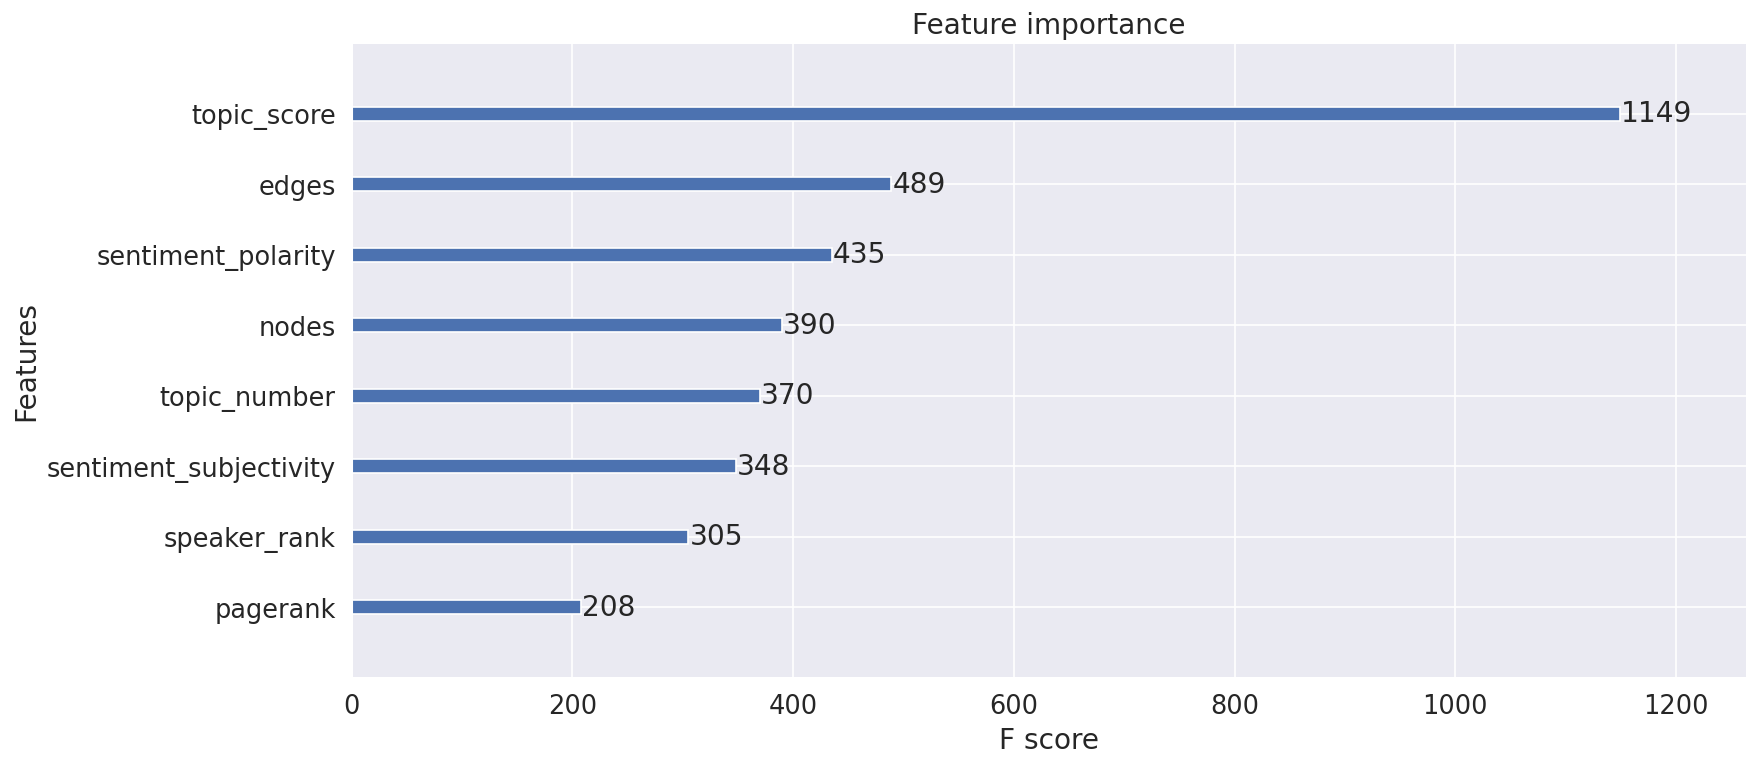

In [228]:
plot_importance(xgModelFinal)
plt.show()

#### Plotting Confusion Matrix

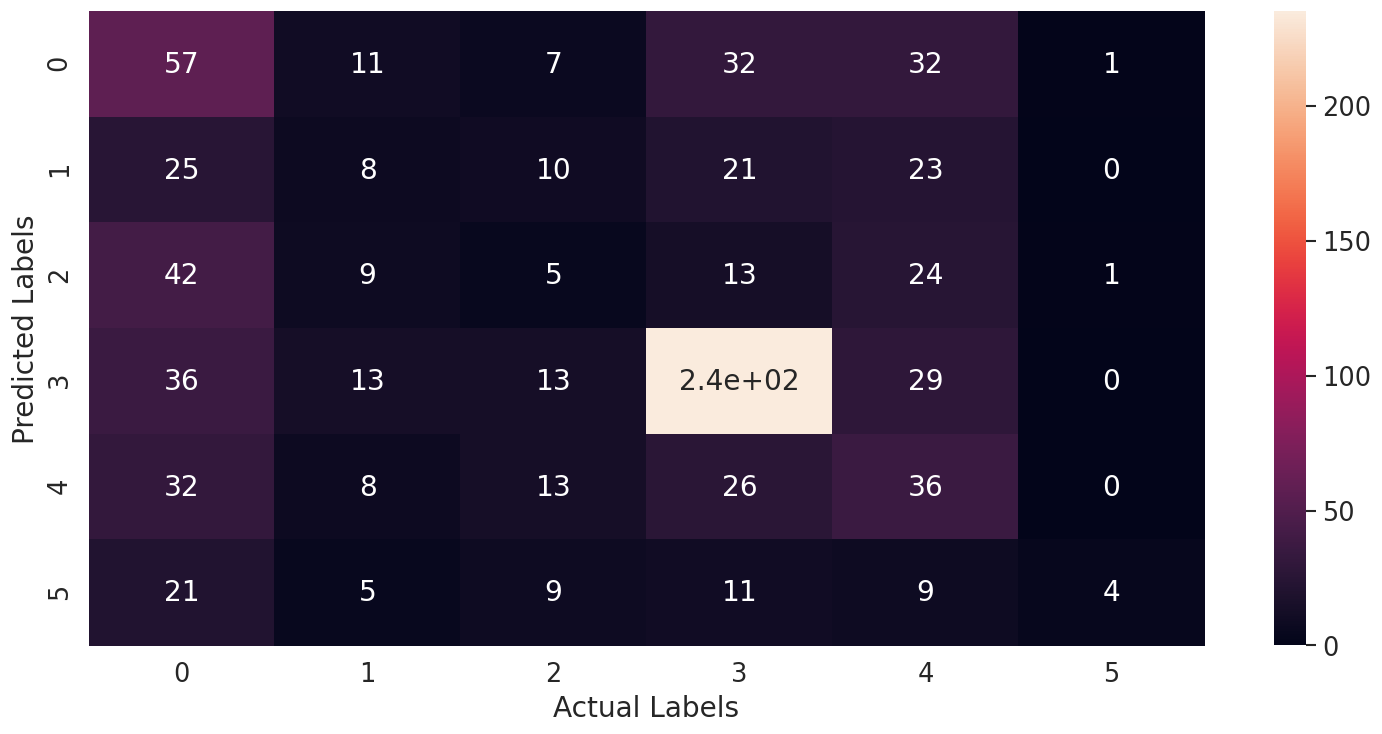

In [229]:
plot_confusion_mat(y_test, y_pred)

#### ROC Curve

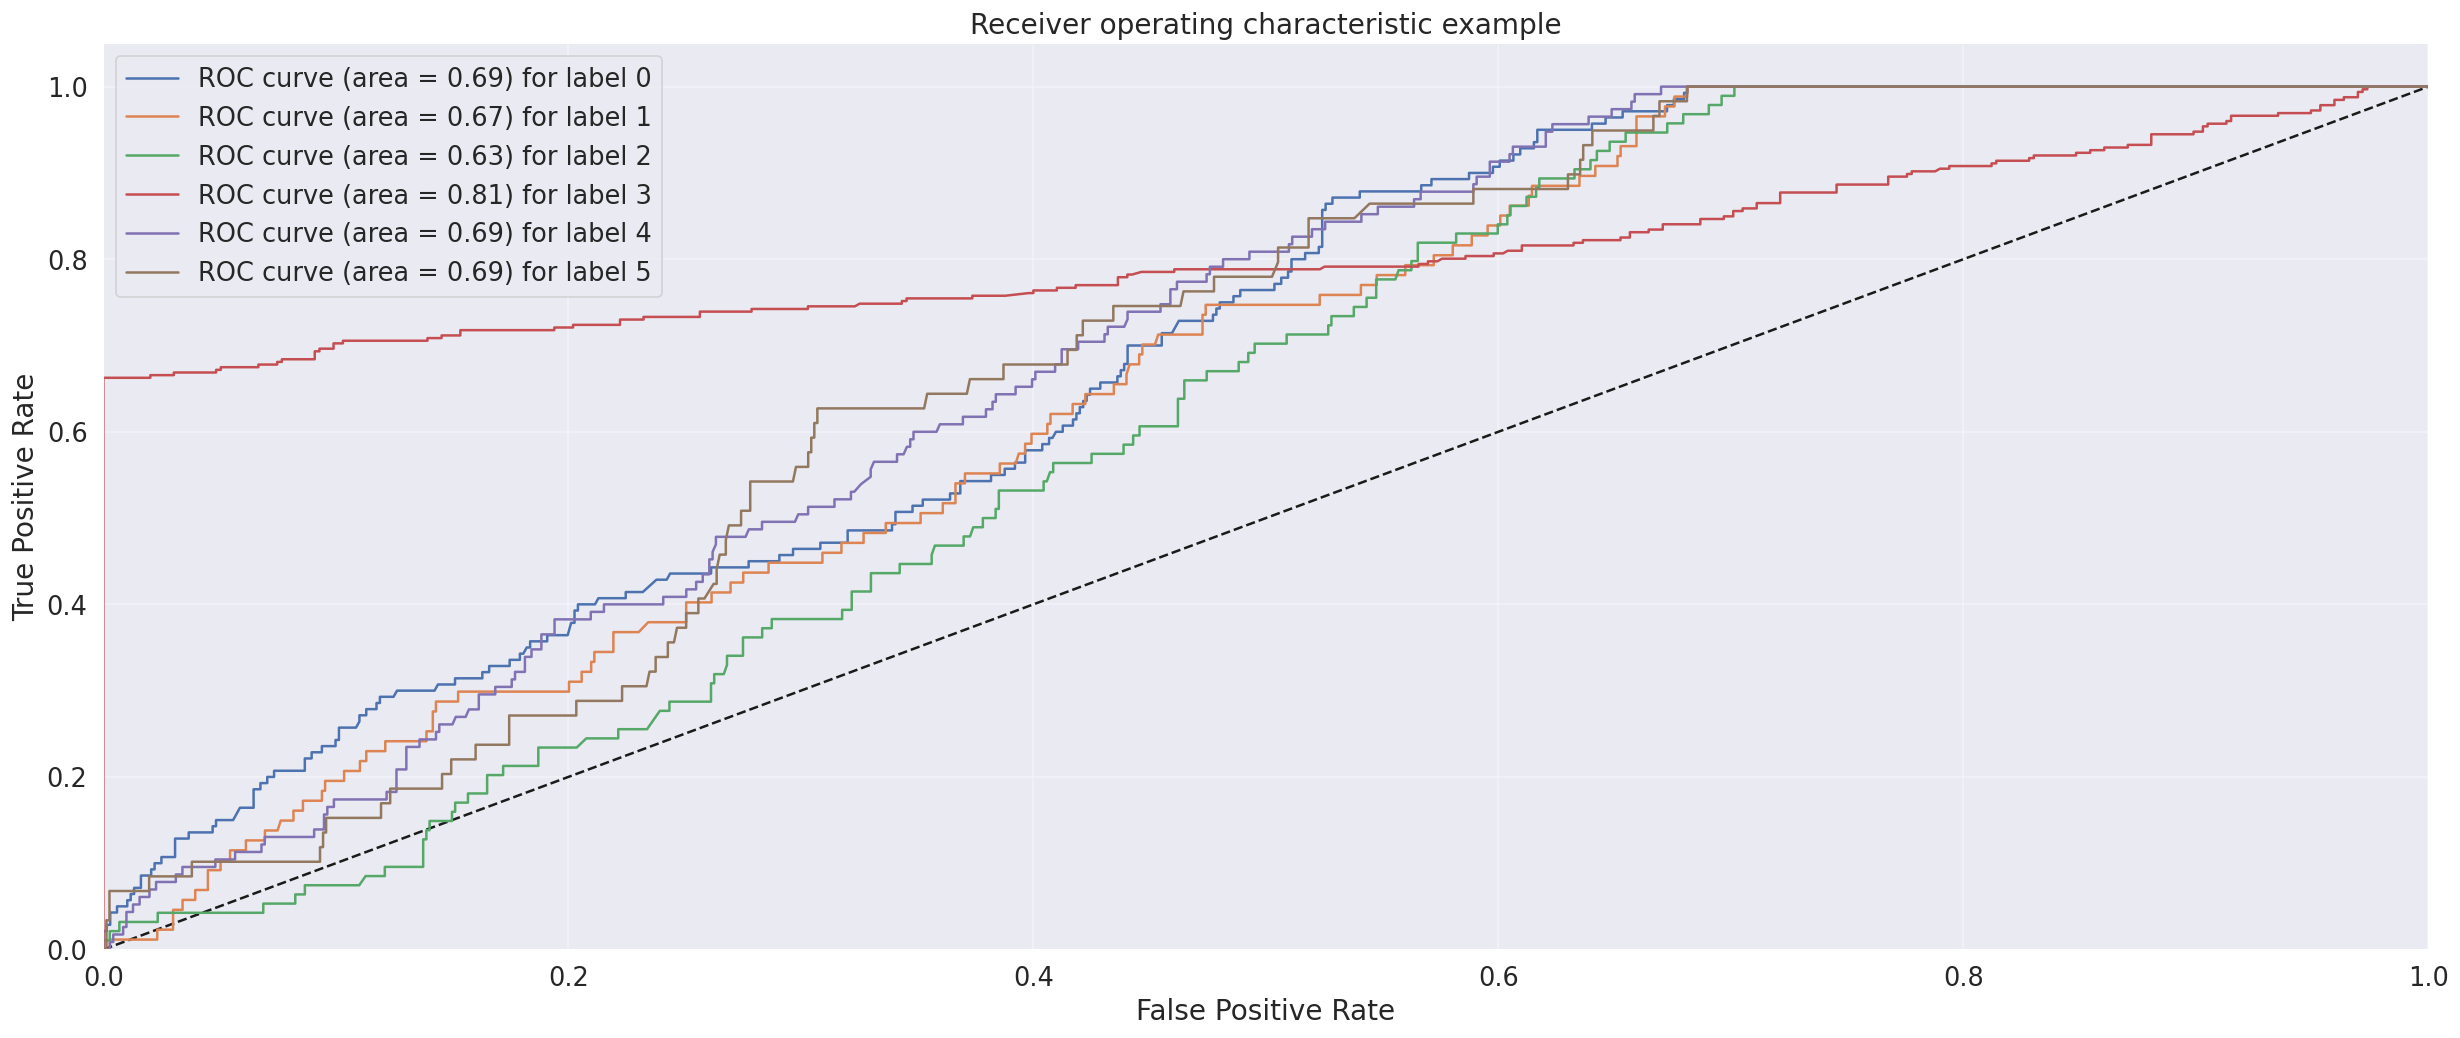

In [230]:
plot_multiclass_roc(xgModelFinal, X_test, y_test, n_classes=6, figsize=(7, 5))

#### Overall Metrics DataFrame

In [231]:
val = {'Model': ['XGBoost (after distillation - on Liar-Liar/News Category)'], 'Accuracy': [accuracy], 'Precision': [precision], 'Recall': [recall], 'F1-Score': f1score}
outputDf13 = pd.DataFrame(val, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])
outputDf = pd.concat([outputDf, outputDf13], ignore_index=True, sort=False)
outputDf.head(20)

Model  ...   F1-Score
0                         RandomForest (on Liar-Liar)  ...   6.444521
1                        Decision Tree (on Liar-Liar)  ...   6.444521
2                              XGBoost (on Liar-Liar)  ...  11.448511
3                        MultinomialNB (on Liar-Liar)  ...   8.394355
4           RandomForest (on Liar-Liar/News Category)  ...   4.580291
5                XGBoost (on Liar-Liar/News Category)  ...  38.623256
6          Decision Tree (on Liar-Liar/News Category)  ...   4.580291
7          MultinomianNB (on Liar-Liar/News Category)  ...  21.745197
8   MultinomialNB (after distillation - on Liar-Li...  ...  22.571406
9   RandomForest (after distillation - on Liar-Lia...  ...   4.968434
10  Decision Tree (after Distillation - on Liar-Li...  ...   4.968434
11  XGBoost (after distillation - on Liar-Liar/New...  ...  40.221686

[12 rows x 5 columns]

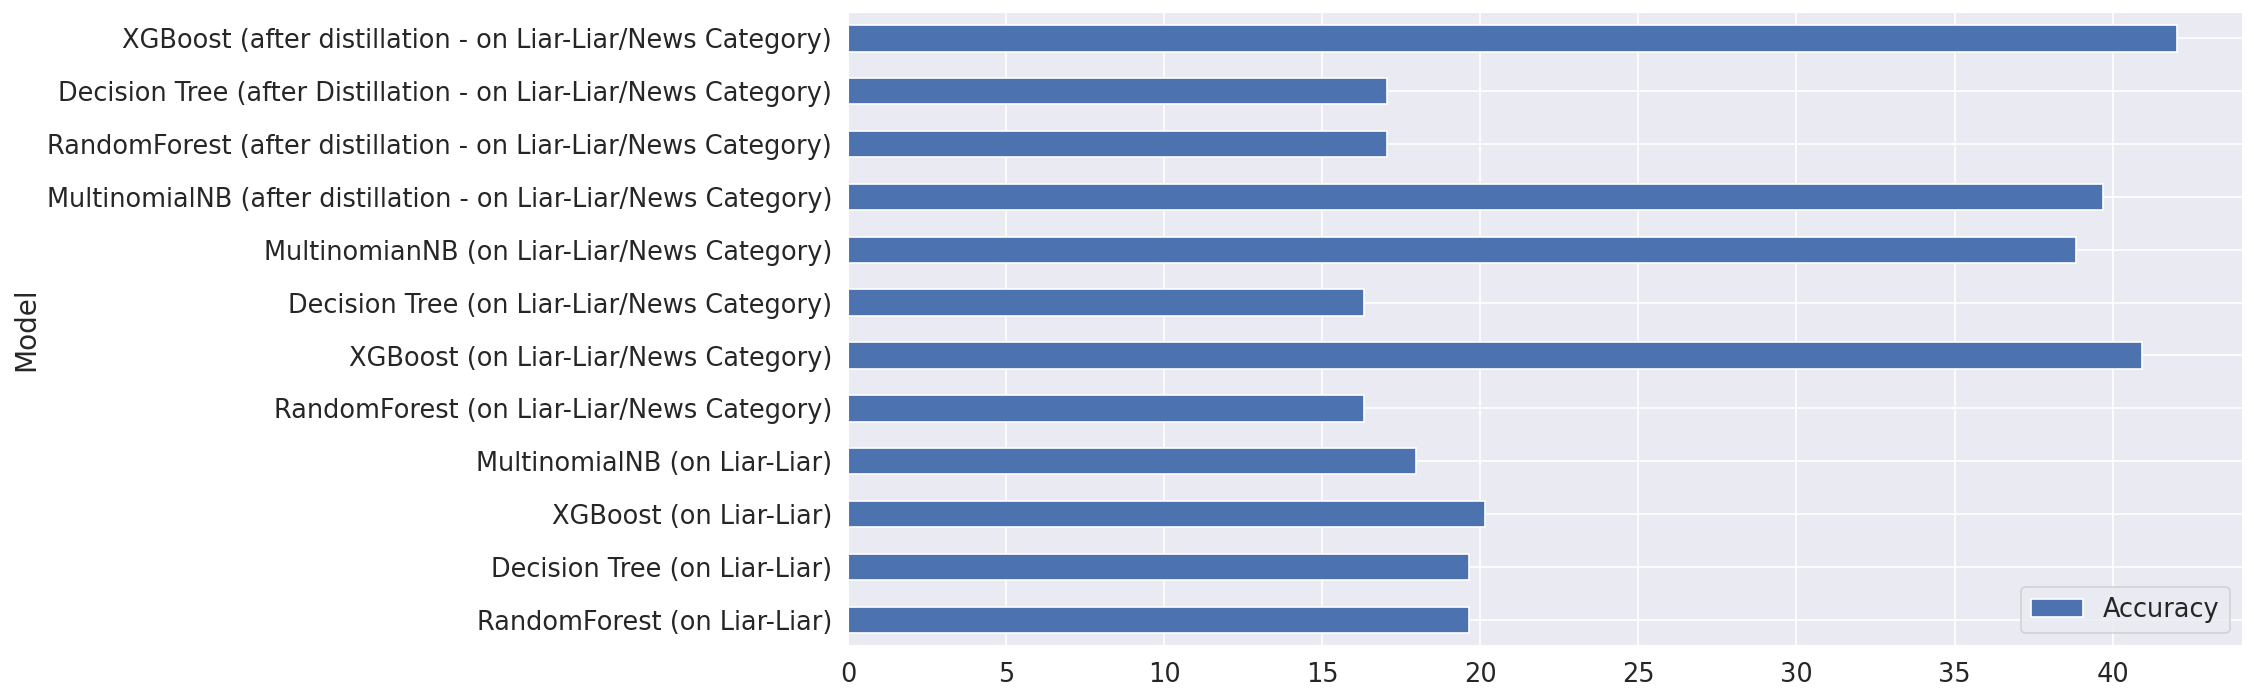

In [232]:
fig, ax = plt.subplots()
outputDf.plot(kind='barh',x='Model',y='Accuracy', ax=ax, color='b')

## Working with Imbalance Dataset

In [233]:
df_amalgamate.head(2)

labels         speaker  ... sentiment_subjectivity  NodeRankClass
0      FALSE    dwayne-bohac  ...                    0.1          FALSE
1  half-true  scott-surovell  ...                    0.4    mostly-true

[2 rows x 14 columns]

In [234]:
df_amalgamate['labels'].value_counts()

half-true      1660
FALSE           618
mostly-true     594
TRUE            508
barely-true     462
pants-fire      259
Name: labels, dtype: int64

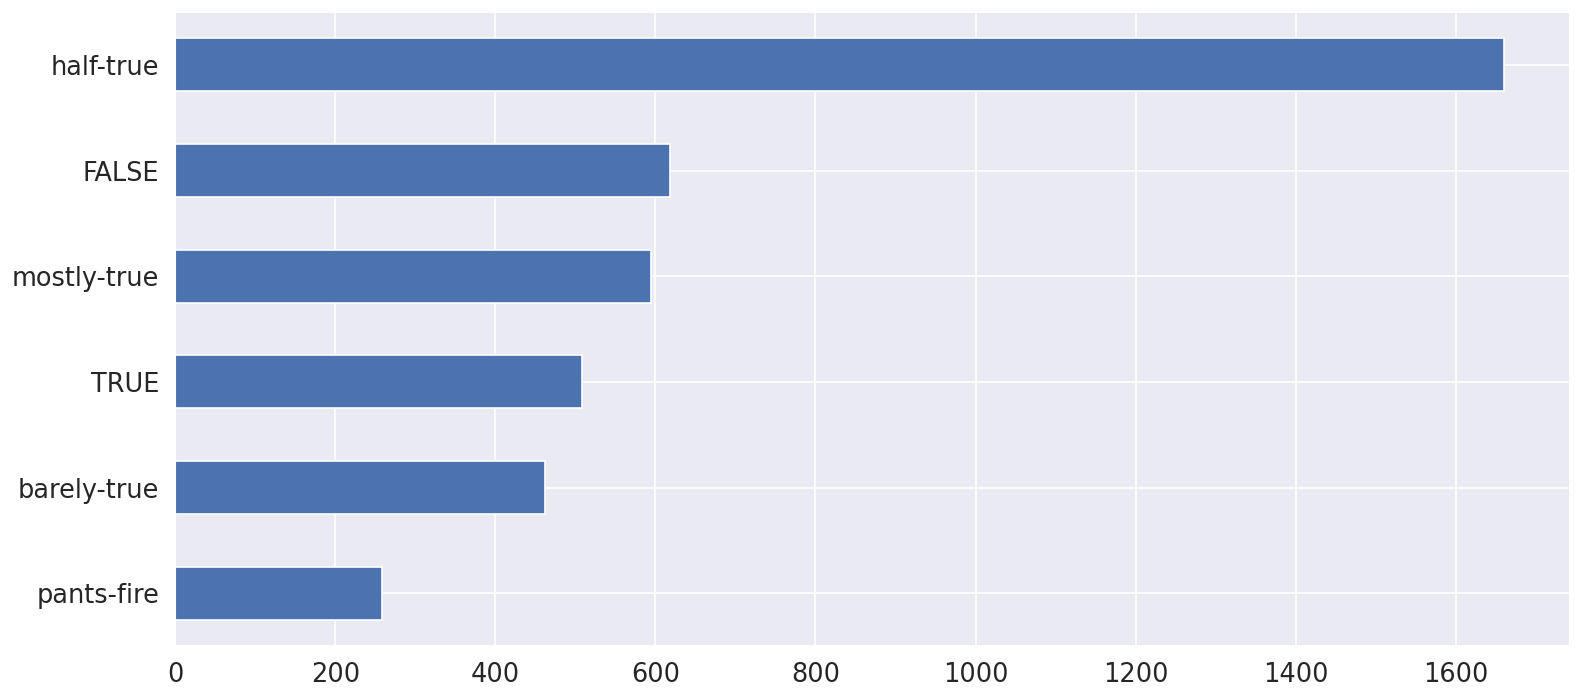

In [235]:
df_amalgamate.labels.value_counts().sort_values().plot(kind = 'barh')

In [0]:
X_imb = df_amalgamate[['pagerank', 'edges', 'nodes', 'topic_number', 'topic_score', 'speaker_rank', 'sentiment_polarity', 'sentiment_subjectivity']]
y_imb = df_amalgamate.labels_cat

In [0]:
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight('balanced', np.unique(y_imb), y_imb)

In [238]:
weights

array([1.10598706, 1.34547244, 1.47943723, 0.41174699, 1.1506734 ,
       2.63899614])

## Using BERT - Classification

In [239]:
!pip install pytorch_pretrained_bert

In [240]:
!pip install torchnlp

In [241]:
import pandas as pd 
import numpy as np 
import torch.nn as nn
from pytorch_pretrained_bert import BertTokenizer, BertModel
import torch
from keras.preprocessing.sequence import pad_sequences
import torch.utils.data

Using TensorFlow backend.


In [0]:
def label_gen(x):
  if (x == 'FALSE') or (x == 'barely-true') or (x == 'pants-fire'):
    return 1
  elif (x == 'mostly-true') or (x == 'TRUE') or (x == 'half-true'):
    return 0

In [0]:
df_amalgamate['fakeness'] = df_amalgamate['labels'].apply(func=label_gen)

In [0]:
train_data = df_amalgamate.head(20)
test_data = df_amalgamate.tail(10)

In [0]:
train_data = [{'processed_statement': text, 'fakeness': type_data } for text in list(train_data['processed_statement']) for type_data in list(train_data['fakeness'])]
test_data = [{'processed_statement': text, 'fakeness': type_data } for text in list(test_data['processed_statement']) for type_data in list(test_data['fakeness'])]

In [0]:
train_texts, train_labels = list(zip(*map(lambda d: (d['processed_statement'], d['fakeness']), train_data)))
test_texts, test_labels = list(zip(*map(lambda d: (d['processed_statement'], d['fakeness']), test_data)))

In [0]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
train_tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[:10], train_texts))
test_tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[:10], test_texts))

In [0]:
train_tokens_ids = list(map(tokenizer.convert_tokens_to_ids, train_tokens))
test_tokens_ids = list(map(tokenizer.convert_tokens_to_ids, test_tokens))

In [0]:
train_tokens_ids = pad_sequences(train_tokens_ids, maxlen=11, truncating="post", padding="post", dtype="int")
test_tokens_ids = pad_sequences(test_tokens_ids, maxlen=11, truncating="post", padding="post", dtype="int")

In [0]:
# train_y = np.array(train_labels) == 'fake'
# test_y = np.array(test_labels) == 'fake'

train_y = train_labels
test_y = test_labels

In [0]:
class BertClassifier(nn.Module):
    def __init__(self, dropout=0.1):
        super(BertClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, tokens, masks=None):
        _, pooled_output = self.bert(tokens, attention_mask=masks, output_all_encoded_layers=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        proba = self.sigmoid(linear_output)
        return proba

In [0]:
BATCH_SIZE = 1
EPOCHS = 1

train_masks = [[float(i > 0) for i in ii] for ii in train_tokens_ids]
test_masks = [[float(i > 0) for i in ii] for ii in test_tokens_ids]
train_masks_tensor = torch.tensor(train_masks)
test_masks_tensor = torch.tensor(test_masks)

train_tokens_tensor = torch.tensor(train_tokens_ids)
train_y_tensor = torch.tensor(np.array(train_y).reshape(-1, 1)).float()
test_tokens_tensor = torch.tensor(test_tokens_ids)
test_y_tensor = torch.tensor(np.array(test_y).reshape(-1, 1)).float()
train_dataset =  torch.utils.data.TensorDataset(train_tokens_tensor, train_masks_tensor, train_y_tensor)
train_sampler =  torch.utils.data.RandomSampler(train_dataset)
train_dataloader =  torch.utils.data.DataLoader(train_dataset, sampler=train_sampler, batch_size=BATCH_SIZE)
test_dataset =  torch.utils.data.TensorDataset(test_tokens_tensor, test_masks_tensor, test_y_tensor)
test_sampler =  torch.utils.data.SequentialSampler(test_dataset)
test_dataloader =  torch.utils.data.DataLoader(test_dataset, sampler=test_sampler, batch_size=BATCH_SIZE)


In [0]:
bert_clf = BertClassifier()
optimizer = torch.optim.Adam(bert_clf.parameters(), lr=3e-6)

In [254]:
for epoch_num in range(EPOCHS):
    bert_clf.train()
    train_loss = 0
    for step_num, batch_data in enumerate(train_dataloader):
        token_ids, masks, labels = tuple(t for t in batch_data)
        probas = bert_clf(token_ids, masks)
        loss_func = nn.BCELoss()
        batch_loss = loss_func(probas, labels)
        train_loss += batch_loss.item()
        bert_clf.zero_grad()
        batch_loss.backward()
        optimizer.step()
        print('Epoch: ', epoch_num + 1)
        print("\r" + "{0}/{1} loss: {2} ".format(step_num, len(train_data) / BATCH_SIZE, train_loss / (step_num + 1)))

Epoch:  1
0/400.0 loss: 0.5438339710235596 
Epoch:  1
1/400.0 loss: 0.6284015774726868 
Epoch:  1
2/400.0 loss: 0.5738712946573893 
Epoch:  1
3/400.0 loss: 0.6051720380783081 
Epoch:  1
4/400.0 loss: 0.6005327939987183 
Epoch:  1
5/400.0 loss: 0.5896187225977579 
Epoch:  1
6/400.0 loss: 0.5746741976056781 
Epoch:  1
7/400.0 loss: 0.5677023679018021 
Epoch:  1
8/400.0 loss: 0.6388025548723009 
Epoch:  1
9/400.0 loss: 0.670281708240509 
Epoch:  1
10/400.0 loss: 0.6601527550003745 
Epoch:  1
11/400.0 loss: 0.6428563768664995 
Epoch:  1
12/400.0 loss: 0.6627638454620655 
Epoch:  1
13/400.0 loss: 0.6469065951449531 
Epoch:  1
14/400.0 loss: 0.6472135603427887 
Epoch:  1
15/400.0 loss: 0.6837973725050688 
Epoch:  1
16/400.0 loss: 0.6683596267419702 
Epoch:  1
17/400.0 loss: 0.6585900104708142 
Epoch:  1
18/400.0 loss: 0.6516606697910711 
Epoch:  1
19/400.0 loss: 0.6401676639914513 
Epoch:  1
20/400.0 loss: 0.6575562201795124 
Epoch:  1
21/400.0 loss: 0.6513765982606194 
Epoch:  1
22/400.0 lo

In [0]:
bert_clf.eval()
bert_predicted = []
all_logits = []
with torch.no_grad():
    for step_num, batch_data in enumerate(test_dataloader):
        token_ids, masks, labels = tuple(t for t in batch_data)
        logits = bert_clf(token_ids, masks)
        loss_func = nn.BCELoss()
        loss = loss_func(logits, labels)
        numpy_logits = logits.cpu().detach().numpy()
        bert_predicted += list(numpy_logits[:, 0] > 0.33)
        all_logits += list(numpy_logits[:, 0])

In [267]:
print(classification_report(test_y, bert_predicted))

              precision    recall  f1-score   support

           0       1.00      0.10      0.18       100
           1       0.00      0.00      0.00         0

   micro avg       0.10      0.10      0.10       100
   macro avg       0.50      0.05      0.09       100
weighted avg       1.00      0.10      0.18       100



## Conclusion:
Feature Importance:

> Gini Index based on Decision Tree is plotted both before and after the distillation process on amalgamated dataset. The feature importance shows 'page rank' is given higher importance of all other features. 

> Feature Importance based on XGBoost and Random Forest are also plotted. Both gives importance for 'Topic Score' feature added after LDA Distillation process.

> Decision Tree doesnot perform well as XGBoost and Random Forest.

Result Comparision: For all the processes are plotted.

> XGBoost Classifier perfomed well overall with 42% accuracy after distillation and 40% before distillation (Both on Amalgamated dataset).

Amalgamation:

> Before Amalgamation, all the classifiers had below avergae accuracies.

> After Amalgamation, XGBoost Classifier produces results closer to the one after distillation.

Distillation:

> Distillation process certainly improved the overall accuracy for Multinomial NaiveBayes and XGBoost in particular.

> Both Amalagamation and Distillation produced better results.

Different Dataset Results:

> with only Liar Liar, maximum accuracy is 20%.

> with both Liar-Liar and Kaggle News Category datasets, maximum accuracy is 40%.

Working with Imbalanced Dataset.

> In the Amalgamated dataset considered, rows with target labels as 'half-true' appears more. The Plot for all the target label frequency is also plotted above.

>  To Overcome imbalance, class weights can be given for each of the classes using compute_class_weight from scikit learn as done above.

> During the training process, these weights can be given as class weights to the classifier.

> The classes with higher frequency is given a lower weight and the one with lower frequency is given higher weight.

Accuracy:

> For all the metrics, weighted average is taken.

Role of Distillation:

> Using LDA, topic score and topic number features were added. Using Ranking process, ranks were given for speakers. Using Sentiment analysis, Sentiment score - both subjectivity and polarity were included to the dataset.

> These features inmproved the accuracy for Multinomial Naive Bayes and XGBoost classifiers.

BERT:

> Bert was used for classification.

Topic Modelling:

> Clean the news statements. Train LDA model. Build a dictionary using train data set. Build a corpus using the Bag of words model. Using this corpus we build LDA model to provide the top 10 topics.

> The processed statements are considered, converted to word tokens and bag of words vectors. Using LDA Model, to get the topic number and score.

Other conclusions:

> Dataset can be made balanced to make it perform better with Random Forest and Decision Tree classifiers.

> As the features in the dataset increased, the accuracy is better. More Columns for Classification can be added.